In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from itertools import product
import pandas as pd
import wandb
from scipy import stats
import os

# CONFIGURATION
METRIC = 'accuracy'  # Options: 'accuracy', 'auroc', 'precision', 'recall', etc.
CONFIDENCE_LEVEL = 0.95  # For confidence intervals

# Set publication style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'errorbar.capsize': 3,
    'figure.dpi': 300
})

def load_cross_project_data(source_project, filter_conditions, target_experiment_name, target_param_value):
    """
    Load data from a source project with specific filter conditions and remap it for target experiment.
    
    Args:
        source_project: The wandb project to load from
        filter_conditions: Dict of conditions to filter runs (e.g., {'homophily_range': [0.4, 0.6]})
        target_experiment_name: The experiment name to assign to filtered runs
        target_param_value: The parameter value to assign to filtered runs
    
    Returns:
        List of processed run data
    """
    api = wandb.Api(timeout=100)
    runs = api.runs(source_project)
    
    cross_project_data = []
    
    for run in runs:
        # Get summary and config
        summary = run.summary._json_dict
        config = run.config
        
        # Check if this run matches our filter conditions
        matches_filter = True
        for filter_key, filter_value in filter_conditions.items():
            # Extract the actual parameter value from the run
            run_param_value = safe_get_nested(config, ['dataset', 'loader', 'parameters', 'generation_parameters', 'family_parameters', filter_key])
            
            if run_param_value != filter_value:
                matches_filter = False
                break
        
        if matches_filter:
            # Create a copy of the run data and modify it for the target experiment
            summary['run_name'] = run.name
            summary['run_id'] = run.id
            summary['source_project'] = source_project
            summary[f'original_source_project'] = source_project  # Track original source
            
            # Add config parameters with 'config_' prefix
            for key, value in config.items():
                summary[f'config_{key}'] = value
            
            # IMPORTANT: Modify the dataset config to reflect the target experiment
            if 'config_dataset' in summary:
                # Deep copy the dataset config
                import copy
                modified_dataset = copy.deepcopy(summary['config_dataset'])
                
                # Update the generation parameters to reflect the target experiment
                if 'loader' in modified_dataset and 'parameters' in modified_dataset['loader']:
                    if 'generation_parameters' not in modified_dataset['loader']['parameters']:
                        modified_dataset['loader']['parameters']['generation_parameters'] = {}
                    
                    if 'family_parameters' not in modified_dataset['loader']['parameters']['generation_parameters']:
                        modified_dataset['loader']['parameters']['generation_parameters']['family_parameters'] = {}
                    
                    # Set the target parameter
                    if target_experiment_name == 'cluster_variance':
                        modified_dataset['loader']['parameters']['generation_parameters']['universe_parameters']['cluster_variance'] = target_param_value
                    else:
                        modified_dataset['loader']['parameters']['generation_parameters']['family_parameters'][target_experiment_name] = target_param_value
                
                # Replace the config_dataset with modified version
                summary['config_dataset'] = modified_dataset
            
            cross_project_data.append(summary)
    
    return cross_project_data

def load_experiment_data_enhanced(experiment_name):
    """Enhanced data loading that handles cross-project dependencies"""
    api = wandb.Api(timeout=1000)
    print("Loading experiment data...")
    
    # Define the standard project mappings (updated to include cluster_variance)
    standard_run_to_api_dict = {
        'avg_degree_range': ['graphuniverse/final_degree_experiments'],
        'homophily_range': 'graphuniverse/final_homophily_experiments',
        'num_nodes_range': 'graphuniverse/final_num_nodes_experiments',
        'cluster_variance': 'graphuniverse/final_cluster_variance_experiments'  # Added this line
    }
    
    # Define cross-project dependencies (updated to include cluster_variance)
    cross_project_dependencies = {
        'avg_degree_range': [
            {
                'source_project': 'graphuniverse/final_homophily_experiments',
                'filter_conditions': {'homophily_range': [0.4, 0.6]},
                'target_param_value': [1, 5]  # This is the missing degree range
            }
        ],
        'num_nodes_range': [
            {
                'source_project': 'graphuniverse/final_homophily_experiments',
                'filter_conditions': {'homophily_range': [0.4, 0.6]},
                'target_param_value': [50, 200]  # This is the missing node count
            }
        ],
        'cluster_variance': [  # Added cluster_variance support
            {
                'source_project': 'graphuniverse/final_homophily_experiments',
                'filter_conditions': {'homophily_range': [0.4, 0.6]},
                'target_param_value': 0.5  # Single value, not a range
            }
        ]
    }
    
    # Get standard API project(s) for this experiment
    api_projects = standard_run_to_api_dict[experiment_name]
    
    # Handle both single project and list of projects
    if isinstance(api_projects, str):
        api_projects = [api_projects]
    
    # Collect data from standard projects
    all_data = []
    for project in api_projects:
        print(f"  Loading from standard project: {project}")
        runs = api.runs(project)
        
        project_data = []
        for run in runs:
            # Get summary metrics
            summary = run.summary._json_dict
            summary['run_name'] = run.name
            summary['run_id'] = run.id
            summary['source_project'] = project
            
            # Add config parameters with 'config_' prefix to avoid name conflicts
            config = run.config
            for key, value in config.items():
                summary[f'config_{key}'] = value
            
            project_data.append(summary)
        
        print(f"    Loaded {len(project_data)} runs from {project}")
        all_data.extend(project_data)
    
    # Handle cross-project dependencies
    if experiment_name in cross_project_dependencies:
        print(f"  Loading cross-project dependencies for {experiment_name}...")
        
        for dependency in cross_project_dependencies[experiment_name]:
            source_project = dependency['source_project']
            filter_conditions = dependency['filter_conditions']
            target_param_value = dependency['target_param_value']
            
            print(f"    Loading from {source_project} with filter {filter_conditions}")
            print(f"    Remapping to {experiment_name} = {target_param_value}")
            
            cross_data = load_cross_project_data(
                source_project=source_project,
                filter_conditions=filter_conditions,
                target_experiment_name=experiment_name,
                target_param_value=target_param_value
            )
            
            print(f"    Loaded {len(cross_data)} cross-project runs")
            all_data.extend(cross_data)
    
    print(f"  Total runs loaded: {len(all_data)}")
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    
    # Rest of the function remains the same as your original
    def safe_get_nested(obj, keys, default=None):
        """Safely get nested dictionary values"""
        try:
            for key in keys:
                obj = obj[key]
            return obj
        except (KeyError, TypeError, IndexError):
            return default
    
    def dict_to_sorted_string(d):
        """Convert nested dict to consistent sorted string"""
        if d is None:
            return "None"
        return json.dumps(d, sort_keys=True, separators=(',', ':'))
    
    # Debug counter for limiting debug output
    debug_count = 0
    
    # Create enhanced generation parameters string that includes both generation_parameters and direct params
    def create_enhanced_generation_params_str(dataset_config, experiment_name):
        """Create enhanced generation parameters string including direct params"""
        nonlocal debug_count
        try:
            enhanced_params = {}
            
            # Get standard generation parameters
            gen_params = safe_get_nested(dataset_config, ['loader', 'parameters', 'generation_parameters'])
            if gen_params:
                enhanced_params.update(gen_params)
            
            # Handle special cases for different experiment types
            if experiment_name == 'num_nodes_range':
                num_nodes_range = safe_get_nested(dataset_config, ['loader', 'parameters', 'num_nodes_range'])
                
                if debug_count < 3:
                    print(f"Debug - Found num_nodes_range at correct location: {num_nodes_range}")
                
                if num_nodes_range is not None:
                    # Add to family_parameters if it exists, otherwise create it
                    if 'family_parameters' not in enhanced_params:
                        enhanced_params['family_parameters'] = {}
                    enhanced_params['family_parameters']['num_nodes_range'] = num_nodes_range
                    
                    if debug_count < 3:
                        print(f"Debug - Added num_nodes_range to family_parameters: {num_nodes_range}")
            
            elif experiment_name == 'cluster_variance':  # Added cluster_variance handling
                # For cluster_variance, look in universe_parameters
                cluster_variance = safe_get_nested(dataset_config, ['loader', 'parameters', 'generation_parameters', 'universe_parameters', 'cluster_variance'])
                
                if debug_count < 3:
                    print(f"Debug - Found cluster_variance in universe_parameters: {cluster_variance}")
                
                if cluster_variance is not None:
                    # Add to universe_parameters if it exists, otherwise create it
                    if 'universe_parameters' not in enhanced_params:
                        enhanced_params['universe_parameters'] = {}
                    enhanced_params['universe_parameters']['cluster_variance'] = cluster_variance
                    
                    if debug_count < 3:
                        print(f"Debug - Added cluster_variance to universe_parameters: {cluster_variance}")
            
            result = dict_to_sorted_string(enhanced_params)
            if debug_count < 3:
                print(f"Debug - Final enhanced_params result: {result[:200]}...")
                if 'family_parameters' in enhanced_params:
                    print(f"Debug - family_parameters keys: {list(enhanced_params['family_parameters'].keys())}")
                if 'universe_parameters' in enhanced_params:  # Added debug for universe_parameters
                    print(f"Debug - universe_parameters keys: {list(enhanced_params['universe_parameters'].keys())}")
                debug_count += 1
            return result
        except Exception as e:
            print(f"Error creating enhanced params: {e}")
            return "None"
    
    # Create string representations for sorting using enhanced params
    df['generation_params_str'] = df.apply(
        lambda row: create_enhanced_generation_params_str(row['config_dataset'], experiment_name),
        axis=1
    )
    
    # Debug: Check what we got
    print(f"Debug - generation_params_str unique values:")
    unique_gen_params = df['generation_params_str'].unique()
    for i, param in enumerate(unique_gen_params[:5]):  # Show first 5
        print(f"  {i}: {param}")
    print(f"  Total unique generation_params_str: {len(unique_gen_params)}")
    
    # Check how many are "None"
    none_count = sum(df['generation_params_str'] == "None")
    print(f"  'None' values: {none_count} out of {len(df)}")
    
    df['model_name'] = df['config_model'].apply(
        lambda x: safe_get_nested(x, ['model_name'])
    )
    
    # Sort by generation parameters first, then model name second (keeps ALL columns)
    df_sorted = df.sort_values(['generation_params_str', 'model_name'])

    print(df_sorted.columns)
    
    # Print summary of loaded data by parameter ranges
    if not df_sorted.empty:
        print(f"  Data summary for {experiment_name}:")
        try:
            # Extract parameter values for summary
            param_values = df_sorted['generation_params_str'].apply(
                lambda x: safe_get_nested(json.loads(x) if x != "None" else {}, 
                                        ['family_parameters', experiment_name])
            ).dropna().unique()
            
            for param_val in sorted(param_values):
                count = sum(df_sorted['generation_params_str'].apply(
                    lambda x: safe_get_nested(json.loads(x) if x != "None" else {}, 
                                            ['family_parameters', experiment_name]) == param_val
                ))
                print(f"    {param_val}: {count} runs")
                
                # Also show source projects for this parameter value
                sources = df_sorted[df_sorted['generation_params_str'].apply(
                    lambda x: safe_get_nested(json.loads(x) if x != "None" else {}, 
                                            ['family_parameters', experiment_name]) == param_val
                )]['source_project'].unique()
                print(f"      Sources: {', '.join(sources)}")
        except Exception as e:
            print(f"    Could not parse parameter summary: {e}")
    
    return df_sorted

# Rest of your helper functions remain the same
def dict_to_sorted_string_no_seed(d, seed_keys=['seed', 'random_seed', 'random_state']):
    """Convert nested dict to consistent sorted string, excluding seed-related keys"""
    if d is None:
        return "None"
    
    def remove_seeds(obj):
        if isinstance(obj, dict):
            return {k: remove_seeds(v) for k, v in obj.items() if k not in seed_keys}
        elif isinstance(obj, list):
            return [remove_seeds(item) for item in obj]
        else:
            return obj
    
    cleaned_dict = remove_seeds(d)
    return json.dumps(cleaned_dict, sort_keys=True, separators=(',', ':'))

def dict_to_sorted_string(d):
        """Convert nested dict to consistent sorted string"""
        if d is None:
            return "None"
        return json.dumps(d, sort_keys=True, separators=(',', ':'))

def extract_transform_info(config_transforms, model_name):
    """Extract relevant transform information based on model type"""
    if pd.isna(config_transforms) or config_transforms is None:
        return "no_transform"
    
    if model_name in ['GPS', 'nsd']:
        # Extract encodings for GPS and NSD
        if 'CombinedPSEs' in config_transforms:
            encodings = config_transforms['CombinedPSEs'].get('encodings', [])
            if encodings:
                return '_'.join(sorted(encodings))  # Sort for consistency
        return "no_encoding"
    
    elif model_name == 'topotune':
        return "cell_lifting"
    
    else:
        return "no_transform"

def calculate_confidence_interval(values, confidence=CONFIDENCE_LEVEL):
    """Calculate confidence interval for a set of values"""
    if len(values) <= 1:
        return np.mean(values) if len(values) == 1 else 0, 0, 0
    
    mean_val = np.mean(values)
    sem = stats.sem(values)
    ci = stats.t.interval(confidence, len(values)-1, loc=mean_val, scale=sem)
    
    return mean_val, ci[0], ci[1]

def safe_get_nested(obj, keys, default=None):
    """Safely get nested dictionary values"""
    try:
        for key in keys:
            obj = obj[key]
        return obj
    except (KeyError, TypeError, IndexError):
        return default

# Your process_experiment_data function remains the same
def process_experiment_data(df_sorted, varied_parameter):
    """Process experiment data for a specific parameter with PE logic"""
    # Create model config strings WITHOUT random seeds
    df_sorted['model_config_str'] = df_sorted['config_model'].apply(
        lambda x: dict_to_sorted_string_no_seed(x)
    )
    
    # Extract transform info separately
    df_sorted['transform_info'] = df_sorted.apply(
        lambda row: extract_transform_info(row.get('config_transforms'), row['model_name']), 
        axis=1
    )
    
    # Create enhanced model config string that includes PE info for GPS/NSD
    df_sorted['enhanced_model_config_str'] = df_sorted.apply(
        lambda row: (row['model_config_str'] + f"_PE_{row['transform_info']}") 
                    if row['model_name'] in ['GPS', 'nsd'] 
                    else row['model_config_str'],
        axis=1
    )
    
    # Define validation and test metrics
    VAL_METRIC = f'val/{METRIC}'
    TEST_METRIC = f'test/{METRIC}'
    
    # Filter out rows with missing essential data (need both val and test metrics)
    df_clean = df_sorted.dropna(subset=['generation_params_str', 'enhanced_model_config_str', VAL_METRIC, TEST_METRIC])
    df_clean = df_clean[df_clean['generation_params_str'] != "None"]
    
    # Enhanced extract_params function to handle both nested and direct parameters
    def extract_params(gen_params_str, varied_param):
        try:
            parsed = json.loads(gen_params_str)
            
            # Extract n_graphs (should be in family_parameters for all experiments)
            n_graphs = parsed.get('family_parameters', {}).get('n_graphs')
            
            # Handle cluster_variance specially - it's in universe_parameters and is a single value
            if varied_param == 'cluster_variance':
                varied_param_value = parsed.get('universe_parameters', {}).get('cluster_variance')
            else:
                # For other parameters, look in family_parameters
                varied_param_value = parsed.get('family_parameters', {}).get(varied_param)
            
            # Convert to tuple if it's a list (for consistency with existing code)
            if isinstance(varied_param_value, list):
                varied_param_value = tuple(varied_param_value)
            
            return n_graphs, varied_param_value
        except Exception as e:
            print(f"Error extracting params: {e}")
            return None, None
            
    df_clean[['n_graphs', varied_parameter]] = df_clean['generation_params_str'].apply(
        lambda x: pd.Series(extract_params(x, varied_parameter))
    )
    
    df_clean = df_clean.dropna(subset=['n_graphs', varied_parameter])
    
    # Return the DataFrame along with the metric names
    return df_clean, VAL_METRIC, TEST_METRIC

# Updated functions for multi-experiment processing
def extract_params_multi(gen_params_str, experiment_type):
    """Extract parameters for each experiment type"""
    try:
        parsed = json.loads(gen_params_str)
        n_graphs = parsed['family_parameters']['n_graphs']
        
        # Get the appropriate parameter based on experiment type
        if experiment_type == 'avg_degree_range':
            varied_param_value = tuple(parsed['family_parameters']['avg_degree_range'])
        elif experiment_type == 'homophily_range':
            varied_param_value = tuple(parsed['family_parameters']['homophily_range'])
        elif experiment_type == 'num_nodes_range':
            varied_param_value = tuple(parsed['family_parameters']['num_nodes_range'])
        elif experiment_type == 'cluster_variance':  # Added cluster_variance support
            # For cluster_variance, it's a single value in universe_parameters
            varied_param_value = parsed['universe_parameters']['cluster_variance']
        else:
            return None, None, None
            
        return n_graphs, varied_param_value, experiment_type
    except:
        return None, None, None

def load_multi_experiment_data(experiments_to_load, local_checkpoint_dir=None, metric='val/accuracy'):
    """
    Load data for multiple experiments with cross-project support
    
    Args:
        experiments_to_load: List of experiment names to load
        local_checkpoint_dir: Directory for local checkpoints (optional)
        metric: Metric to use for evaluation
    
    Returns:
        DataFrame with all experiment data and best models dictionary
    """
    
    # Collect data from all experiments
    all_data = []
    for experiment_name in experiments_to_load:
        print(f"Loading data from experiment: {experiment_name}")
        
        # Use the enhanced loader that handles cross-project dependencies
        df_experiment = load_experiment_data_enhanced(experiment_name)
        
        # Add experiment type identifier
        df_experiment['experiment_type'] = experiment_name
        
        print(f"  Total runs loaded for {experiment_name}: {len(df_experiment)}")
        all_data.append(df_experiment)
    
    # Combine all data
    df = pd.concat(all_data, ignore_index=True)
    print(f"Total runs loaded across all experiments: {len(df)}")
    
    # Print summary by experiment and project
    if not df.empty:
        print("\nData summary:")
        for exp_name in experiments_to_load:
            exp_data = df[df['experiment_type'] == exp_name]
            print(f"  {exp_name}: {len(exp_data)} runs")
            
            # Show breakdown by source project if multiple projects
            if 'source_project' in exp_data.columns:
                for project in exp_data['source_project'].unique():
                    project_count = len(exp_data[exp_data['source_project'] == project])
                    print(f"    from {project}: {project_count} runs")
    
    # Process the data for best model selection
    best_models_dict, best_models_df = process_multi_experiment_data(df, metric, local_checkpoint_dir)
    
    return df, best_models_dict, best_models_df

def process_multi_experiment_data(df, metric, local_checkpoint_dir=None):
    """
    Process multi-experiment data to find best models
    
    Args:
        df: DataFrame with all experiment data
        metric: Metric to optimize for
        local_checkpoint_dir: Directory for local checkpoints
    
    Returns:
        Tuple of (best_models_dict, best_models_df)
    """
    
    # Create string representations for sorting
    df['generation_params_str'] = df['config_dataset'].apply(
        lambda x: dict_to_sorted_string(safe_get_nested(x, ['loader', 'parameters', 'generation_parameters']))
    )
    
    df['model_name'] = df['config_model'].apply(
        lambda x: safe_get_nested(x, ['model_name'])
    )
    
    # Sort by generation parameters first, then model name second
    df_sorted = df.sort_values(['generation_params_str', 'model_name'])
    
    # Extract transform info separately
    df_sorted['transform_info'] = df_sorted.apply(
        lambda row: extract_transform_info(row.get('config_transforms'), row['model_name']), 
        axis=1
    )
    
    # Create enhanced model config string that includes PE info for GPS/NSD
    df_sorted['model_config_str'] = df_sorted.apply(
        lambda row: (dict_to_sorted_string_no_seed(row['config_model']) + f"_PE_{row['transform_info']}") 
                    if row['model_name'] in ['GPS', 'nsd'] 
                    else dict_to_sorted_string_no_seed(row['config_model']),
        axis=1
    )
    
    # Filter out rows with missing essential data
    required_columns = ['generation_params_str', 'model_config_str', metric]
    if local_checkpoint_dir:
        required_columns.append('checkpoint')
    
    df_clean = df_sorted.dropna(subset=required_columns)
    df_clean = df_clean[df_clean['generation_params_str'] != "None"]
    
    # Extract parameters using the multi-experiment function
    df_clean[['n_graphs', 'varied_param_value', 'experiment_type_check']] = df_clean.apply(
        lambda row: pd.Series(extract_params_multi(row['generation_params_str'], row['experiment_type'])), axis=1
    )
    
    df_clean = df_clean.dropna(subset=['n_graphs', 'varied_param_value'])
    
    # Get unique values
    unique_models = sorted(df_clean['model_name'].unique())
    experiments_to_load = df_clean['experiment_type'].unique()
    
    # Dictionary to store the best models for ALL experiments
    best_models_dict = {}
    
    # DataFrame for best models with the full rows AND the local checkpoint paths
    best_models_df = pd.DataFrame()
    
    # Process each experiment type separately
    for experiment_type in experiments_to_load:
        print(f"\nProcessing experiment: {experiment_type}")
        
        # Filter data for this experiment
        experiment_data = df_clean[df_clean['experiment_type'] == experiment_type]
        
        if len(experiment_data) == 0:
            print(f"No data found for experiment: {experiment_type}")
            continue
        
        unique_varied_param_values = sorted(experiment_data['varied_param_value'].unique())
        
        # Process each varied parameter value
        for varied_param_value in unique_varied_param_values:
            subset = experiment_data[experiment_data['varied_param_value'] == varied_param_value]
            
            if len(subset) > 0:
                # Create data config key that includes experiment type
                data_config_key = f"{experiment_type}_{varied_param_value}"
                best_models_dict[data_config_key] = {}
                
                # For each model architecture, find the best configuration
                for model_name in unique_models:
                    model_subset = subset[subset['model_name'] == model_name]
                    
                    if len(model_subset) > 0:
                        # Calculate mean performance for each unique model configuration
                        agg_dict = {
                            metric: ['mean', 'std', 'count']
                        }
                        
                        if local_checkpoint_dir and 'checkpoint' in model_subset.columns:
                            agg_dict['checkpoint'] = lambda x: list(x)
                        
                        model_config_performance = model_subset.groupby('model_config_str').agg(agg_dict).reset_index()
                        
                        # Flatten column names
                        new_columns = ['model_config_str']
                        for col in agg_dict.keys():
                            if col == 'checkpoint':
                                new_columns.append('checkpoints')
                            else:
                                new_columns.extend([f'{col}_mean', f'{col}_std', f'{col}_count'])
                        
                        model_config_performance.columns = new_columns
                        
                        # Find the configuration with the best mean performance
                        if len(model_config_performance) > 0:
                            best_config_idx = model_config_performance[f'{metric}_mean'].idxmax()
                            
                            # Find in the subset, which rows have this model_config_str
                            best_model_full_rows = subset[subset['model_config_str'] == model_config_performance.loc[best_config_idx, 'model_config_str']]
                            
                            if local_checkpoint_dir and 'checkpoints' in model_config_performance.columns:
                                # Get the best checkpoints
                                best_checkpoints = model_config_performance.loc[best_config_idx, 'checkpoints']
                                
                                # Get the local checkpoint directory
                                local_checkpoints_dir_data_config_model = os.path.join(local_checkpoint_dir, data_config_key, model_name)
                                
                                # Get the local checkpoint paths
                                best_checkpoints_local = [os.path.join(local_checkpoints_dir_data_config_model, checkpoint.split("/")[-1]) for checkpoint in best_checkpoints]
                                print(f"Local checkpoints for {model_name}: {best_checkpoints_local}")
                                
                                # Store the checkpoint locations for this model architecture
                                best_models_dict[data_config_key][model_name] = best_checkpoints_local
                                
                                # Check if local checkpoint paths exist
                                for checkpoint in best_checkpoints_local:
                                    if not os.path.exists(checkpoint):
                                        print(f"Checkpoint not found: {checkpoint}")
                                
                                # Add local checkpoint paths column
                                best_model_full_rows = best_model_full_rows.copy()
                                best_model_full_rows['checkpoint_local'] = pd.Series(best_checkpoints_local, index=best_model_full_rows.index)
                            else:
                                # Still store the model info even without checkpoints
                                best_models_dict[data_config_key][model_name] = f"Performance: {model_config_performance.loc[best_config_idx, f'{metric}_mean']:.4f}"
                            
                            # Concatenate the best model full rows with the best models df
                            best_models_df = pd.concat([best_models_df, best_model_full_rows])
    
    # Clean up empty entries
    best_models_dict = {k: v for k, v in best_models_dict.items() if v}
    
    return best_models_dict, best_models_df


# Configuration
EXPERIMENTS_TO_LOAD = ['cluster_variance']
METRIC = 'val/accuracy'  
LOCAL_CHECKPOINT_DIR = '../checkpoints'

# Load everything at once
df, best_models_dict, best_models_df = load_multi_experiment_data(
    experiments_to_load=EXPERIMENTS_TO_LOAD,
    local_checkpoint_dir=LOCAL_CHECKPOINT_DIR,
    metric=METRIC
)

Loading data from experiment: cluster_variance


wandb: Currently logged in as: louis-van-langendonck (louis-van-langendonck-universitat-polit-cnica-de-catalunya) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading experiment data...
  Loading from standard project: graphuniverse/final_cluster_variance_experiments
    Loaded 1088 runs from graphuniverse/final_cluster_variance_experiments
  Loading cross-project dependencies for cluster_variance...
    Loading from graphuniverse/final_homophily_experiments with filter {'homophily_range': [0.4, 0.6]}
    Remapping to cluster_variance = 0.5
    Loaded 2547 cross-project runs
  Total runs loaded: 3635
Debug - Found cluster_variance in universe_parameters: 0.2
Debug - Added cluster_variance to universe_parameters: 0.2
Debug - Final enhanced_params result: {"family_parameters":{"avg_degree_range":[1,5],"degree_distribution":"power_law","degree_heterogeneity":0.5,"degree_separation_range":[0.5,0.8],"homophily_range":[0.4,0.6],"max_communities":6,"max_n_n...
Debug - family_parameters keys: ['seed', 'n_graphs', 'max_n_nodes', 'min_n_nodes', 'use_dccc_sbm', 'homophily_range', 'max_communities', 'min_communities', 'avg_degree_range', 'degree_distrib

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 22.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4067879021167755     │
│        test/auroc         │    0.8093241453170776     │
│         test/loss         │    1.7399177551269531     │
│      test/precision       │    0.39411988854408264    │
│        test/recall        │    0.40510693192481995    │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: -0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=1', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 21.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4766092896461487     │
│        test/auroc         │    0.8525204658508301     │
│         test/loss         │    1.5563617944717407     │
│      test/precision       │    0.46616029739379883    │
│        test/recall        │    0.4754070043563843     │
└───────────────────────────┴───────────────────────────┘

Evaluating run 2328
Evaluating shift: Baseline
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=3', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'da

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 22.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4939460754394531     │
│        test/auroc         │    0.8615081906318665     │
│         test/loss         │    1.5159485340118408     │
│      test/precision       │    0.48935890197753906    │
│        test/recall        │    0.4922989010810852     │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: +0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=3', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 23.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4598288834095001     │
│        test/auroc         │    0.8423115611076355     │
│         test/loss         │    1.6095348596572876     │
│      test/precision       │    0.45549502968788147    │
│        test/recall        │    0.4585484564304352     │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: -0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=3', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5379109978675842     │
│        test/auroc         │    0.8843758702278137     │
│         test/loss         │    1.4009804725646973     │
│      test/precision       │    0.5344120264053345     │
│        test/recall        │    0.5357041954994202     │
└───────────────────────────┴───────────────────────────┘

Evaluating run 3531
Evaluating shift: Baseline
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=5', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'da

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 22.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4948512315750122     │
│        test/auroc         │    0.8616925477981567     │
│         test/loss         │    1.5143671035766602     │
│      test/precision       │    0.48649176955223083    │
│        test/recall        │    0.4880530536174774     │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: +0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=5', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 23.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.45730215311050415    │
│        test/auroc         │    0.8408829569816589     │
│         test/loss         │    1.6174535751342773     │
│      test/precision       │    0.44885560870170593    │
│        test/recall        │    0.4513276219367981     │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: -0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=5', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 24.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5399101376533508     │
│        test/auroc         │    0.8862508535385132     │
│         test/loss         │     1.388788104057312     │
│      test/precision       │    0.5340247750282288     │
│        test/recall        │    0.5319733619689941     │
└───────────────────────────┴───────────────────────────┘


SHIFT EVALUATION SUMMARY for ('cluster_variance', 0.8, 'gcn')
cluster_variance: +0.20        | test/accuracy | Diff: -0.034 ± 0.002 (p=0.003, n=3)
cluster_variance: -0.20        | test/accuracy | Diff: 0.043 ± 0.001 (p=0.002, n=3)


C:\Users\louis\AppData\Local\Temp\ipykernel_9276\3185723155.py:53: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="shift_evaluation")


Evaluating run 1113
Evaluating shift: Baseline
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=1', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'da

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\louis\anaconda3\envs\tb\Lib\site-packages\lightning\pytorch\utilities\parsing.py:44: Attribute 'backbone_wrapper' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['backbone_wrapper'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\louis\anaconda3\envs\tb\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 27.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4473641514778137     │
│        test/auroc         │    0.8394917249679565     │
│         test/loss         │     1.612923264503479     │
│      test/precision       │    0.4455227255821228     │
│        test/recall        │    0.44561776518821716    │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: +0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=1', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 25.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.41450387239456177    │
│        test/auroc         │    0.8211061358451843     │
│         test/loss         │     1.689118504524231     │
│      test/precision       │    0.4142352342605591     │
│        test/recall        │    0.41245031356811523    │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: -0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=1', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 27.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4863756597042084     │
│        test/auroc         │    0.8612600564956665     │
│         test/loss         │    1.5182560682296753     │
│      test/precision       │    0.4827037751674652     │
│        test/recall        │    0.48474031686782837    │
└───────────────────────────┴───────────────────────────┘

Evaluating run 2332
Evaluating shift: Baseline
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=3', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'da

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 27.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │     0.493784636259079     │
│        test/auroc         │    0.8607593774795532     │
│         test/loss         │    1.5164011716842651     │
│      test/precision       │    0.4966079294681549     │
│        test/recall        │    0.4906848967075348     │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: +0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=3', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 27.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4604208171367645     │
│        test/auroc         │    0.8428705334663391     │
│         test/loss         │    1.6050411462783813     │
│      test/precision       │    0.4658598005771637     │
│        test/recall        │    0.45767030119895935    │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: -0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=3', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 26.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │     0.533659815788269     │
│        test/auroc         │    0.8802968859672546     │
│         test/loss         │    1.4144974946975708     │
│      test/precision       │    0.5340405702590942     │
│        test/recall        │    0.5299876928329468     │
└───────────────────────────┴───────────────────────────┘

Evaluating run 3535
Evaluating shift: Baseline
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=5', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'da

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 25.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4866017997264862     │
│        test/auroc         │     0.858847975730896     │
│         test/loss         │    1.5227463245391846     │
│      test/precision       │    0.4827632009983063     │
│        test/recall        │    0.48323309421539307    │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: +0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=5', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 28.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.45405927300453186    │
│        test/auroc         │    0.8405343890190125     │
│         test/loss         │    1.6123522520065308     │
│      test/precision       │    0.45093750953674316    │
│        test/recall        │    0.45197898149490356    │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: -0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=5', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 28.79it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5272230505943298     │
│        test/auroc         │    0.8799018859863281     │
│         test/loss         │    1.4134283065795898     │
│      test/precision       │    0.5229966044425964     │
│        test/recall        │    0.5218170285224915     │
└───────────────────────────┴───────────────────────────┘


SHIFT EVALUATION SUMMARY for ('cluster_variance', 0.8, 'gin')
cluster_variance: +0.20        | test/accuracy | Diff: -0.033 ± 0.000 (p=0.000, n=3)
cluster_variance: -0.20        | test/accuracy | Diff: 0.040 ± 0.000 (p=0.000, n=3)


C:\Users\louis\AppData\Local\Temp\ipykernel_9276\3185723155.py:53: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="shift_evaluation")


Evaluating run 1118
Evaluating shift: Baseline
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=1', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'da

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\louis\anaconda3\envs\tb\Lib\site-packages\lightning\pytorch\utilities\parsing.py:44: Attribute 'backbone_wrapper' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['backbone_wrapper'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\louis\anaconda3\envs\tb\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │     0.455889493227005     │
│        test/auroc         │    0.8455793261528015     │
│         test/loss         │     1.585376262664795     │
│      test/precision       │    0.4561329782009125     │
│        test/recall        │    0.45392653346061707    │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: +0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=1', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.42572706937789917    │
│        test/auroc         │    0.8281620740890503     │
│         test/loss         │    1.6604963541030884     │
│      test/precision       │    0.4283422827720642     │
│        test/recall        │    0.4231674373149872     │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: -0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=1', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00,  9.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.49484702944755554    │
│        test/auroc         │    0.8665958642959595     │
│         test/loss         │    1.4916462898254395     │
│      test/precision       │    0.4923338294029236     │
│        test/recall        │    0.4931108057498932     │
└───────────────────────────┴───────────────────────────┘

Evaluating run 2337
Evaluating shift: Baseline
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=3', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'da

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00,  9.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5148791670799255     │
│        test/auroc         │    0.8787932395935059     │
│         test/loss         │    1.4385666847229004     │
│      test/precision       │    0.5199615955352783     │
│        test/recall        │    0.5119731426239014     │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: +0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=3', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00,  9.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │     0.482268750667572     │
│        test/auroc         │    0.8616830706596375     │
│         test/loss         │    1.5264028310775757     │
│      test/precision       │    0.4896962642669678     │
│        test/recall        │    0.4799259901046753     │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: -0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=3', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00,  9.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5530323386192322     │
│        test/auroc         │    0.8983558416366577     │
│         test/loss         │     1.332326054573059     │
│      test/precision       │    0.5568745732307434     │
│        test/recall        │    0.5492849349975586     │
└───────────────────────────┴───────────────────────────┘

Evaluating run 3540
Evaluating shift: Baseline
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=5', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'da

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5058884024620056     │
│        test/auroc         │    0.8739862442016602     │
│         test/loss         │    1.4597212076187134     │
│      test/precision       │    0.5020582675933838     │
│        test/recall        │    0.4975374639034271     │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: +0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=5', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 10.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.4691926836967468     │
│        test/auroc         │    0.8551117181777954     │
│         test/loss         │     1.552630066871643     │
│      test/precision       │    0.4655910134315491     │
│        test/recall        │    0.46177709102630615    │
└───────────────────────────┴───────────────────────────┘

Evaluating shift: cluster_variance: -0.20
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=5', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 10.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.5468509793281555     │
│        test/auroc         │     0.895843505859375     │
│         test/loss         │    1.3459240198135376     │
│      test/precision       │    0.5460142493247986     │
│        test/recall        │    0.5374687910079956     │
└───────────────────────────┴───────────────────────────┘


SHIFT EVALUATION SUMMARY for ('cluster_variance', 0.8, 'nsd')
cluster_variance: +0.20        | test/accuracy | Diff: -0.033 ± 0.002 (p=0.003, n=3)
cluster_variance: -0.20        | test/accuracy | Diff: 0.039 ± 0.001 (p=0.000, n=3)


C:\Users\louis\AppData\Local\Temp\ipykernel_9276\3185723155.py:53: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="shift_evaluation")


Evaluating run 1186
Evaluating shift: Baseline
['dataset.loader.task=community_detection', 'dataset.loader._target_=topobench.data.loaders.GraphUniverseDatasetLoader', 'dataset.loader.parameters.data_dir=/data/gbg141/TB/datasets/graph/GraphUniverse', 'dataset.loader.parameters.data_name=GraphUniverse', 'dataset.loader.parameters.data_type=GraphUniverse', 'dataset.loader.parameters.data_domain=graph', 'dataset.parameters.task=classification', 'dataset.parameters.loss_type=cross_entropy', 'dataset.parameters.task_level=inductive_node', 'dataset.parameters.num_classes=10', 'dataset.parameters.num_features=15', 'dataset.parameters.monitor_metric=accuracy', 'dataset.split_params.k=10', 'dataset.split_params.data_seed=1', 'dataset.split_params.split_type=random', 'dataset.split_params.train_prop=0.0', 'dataset.split_params.data_split_dir=/data/gbg141/TB/datasets/graph/GraphUniverse/data_splits', 'dataset.split_params.learning_setting=inductive', 'dataset.dataloader_params.batch_size=32', 'da

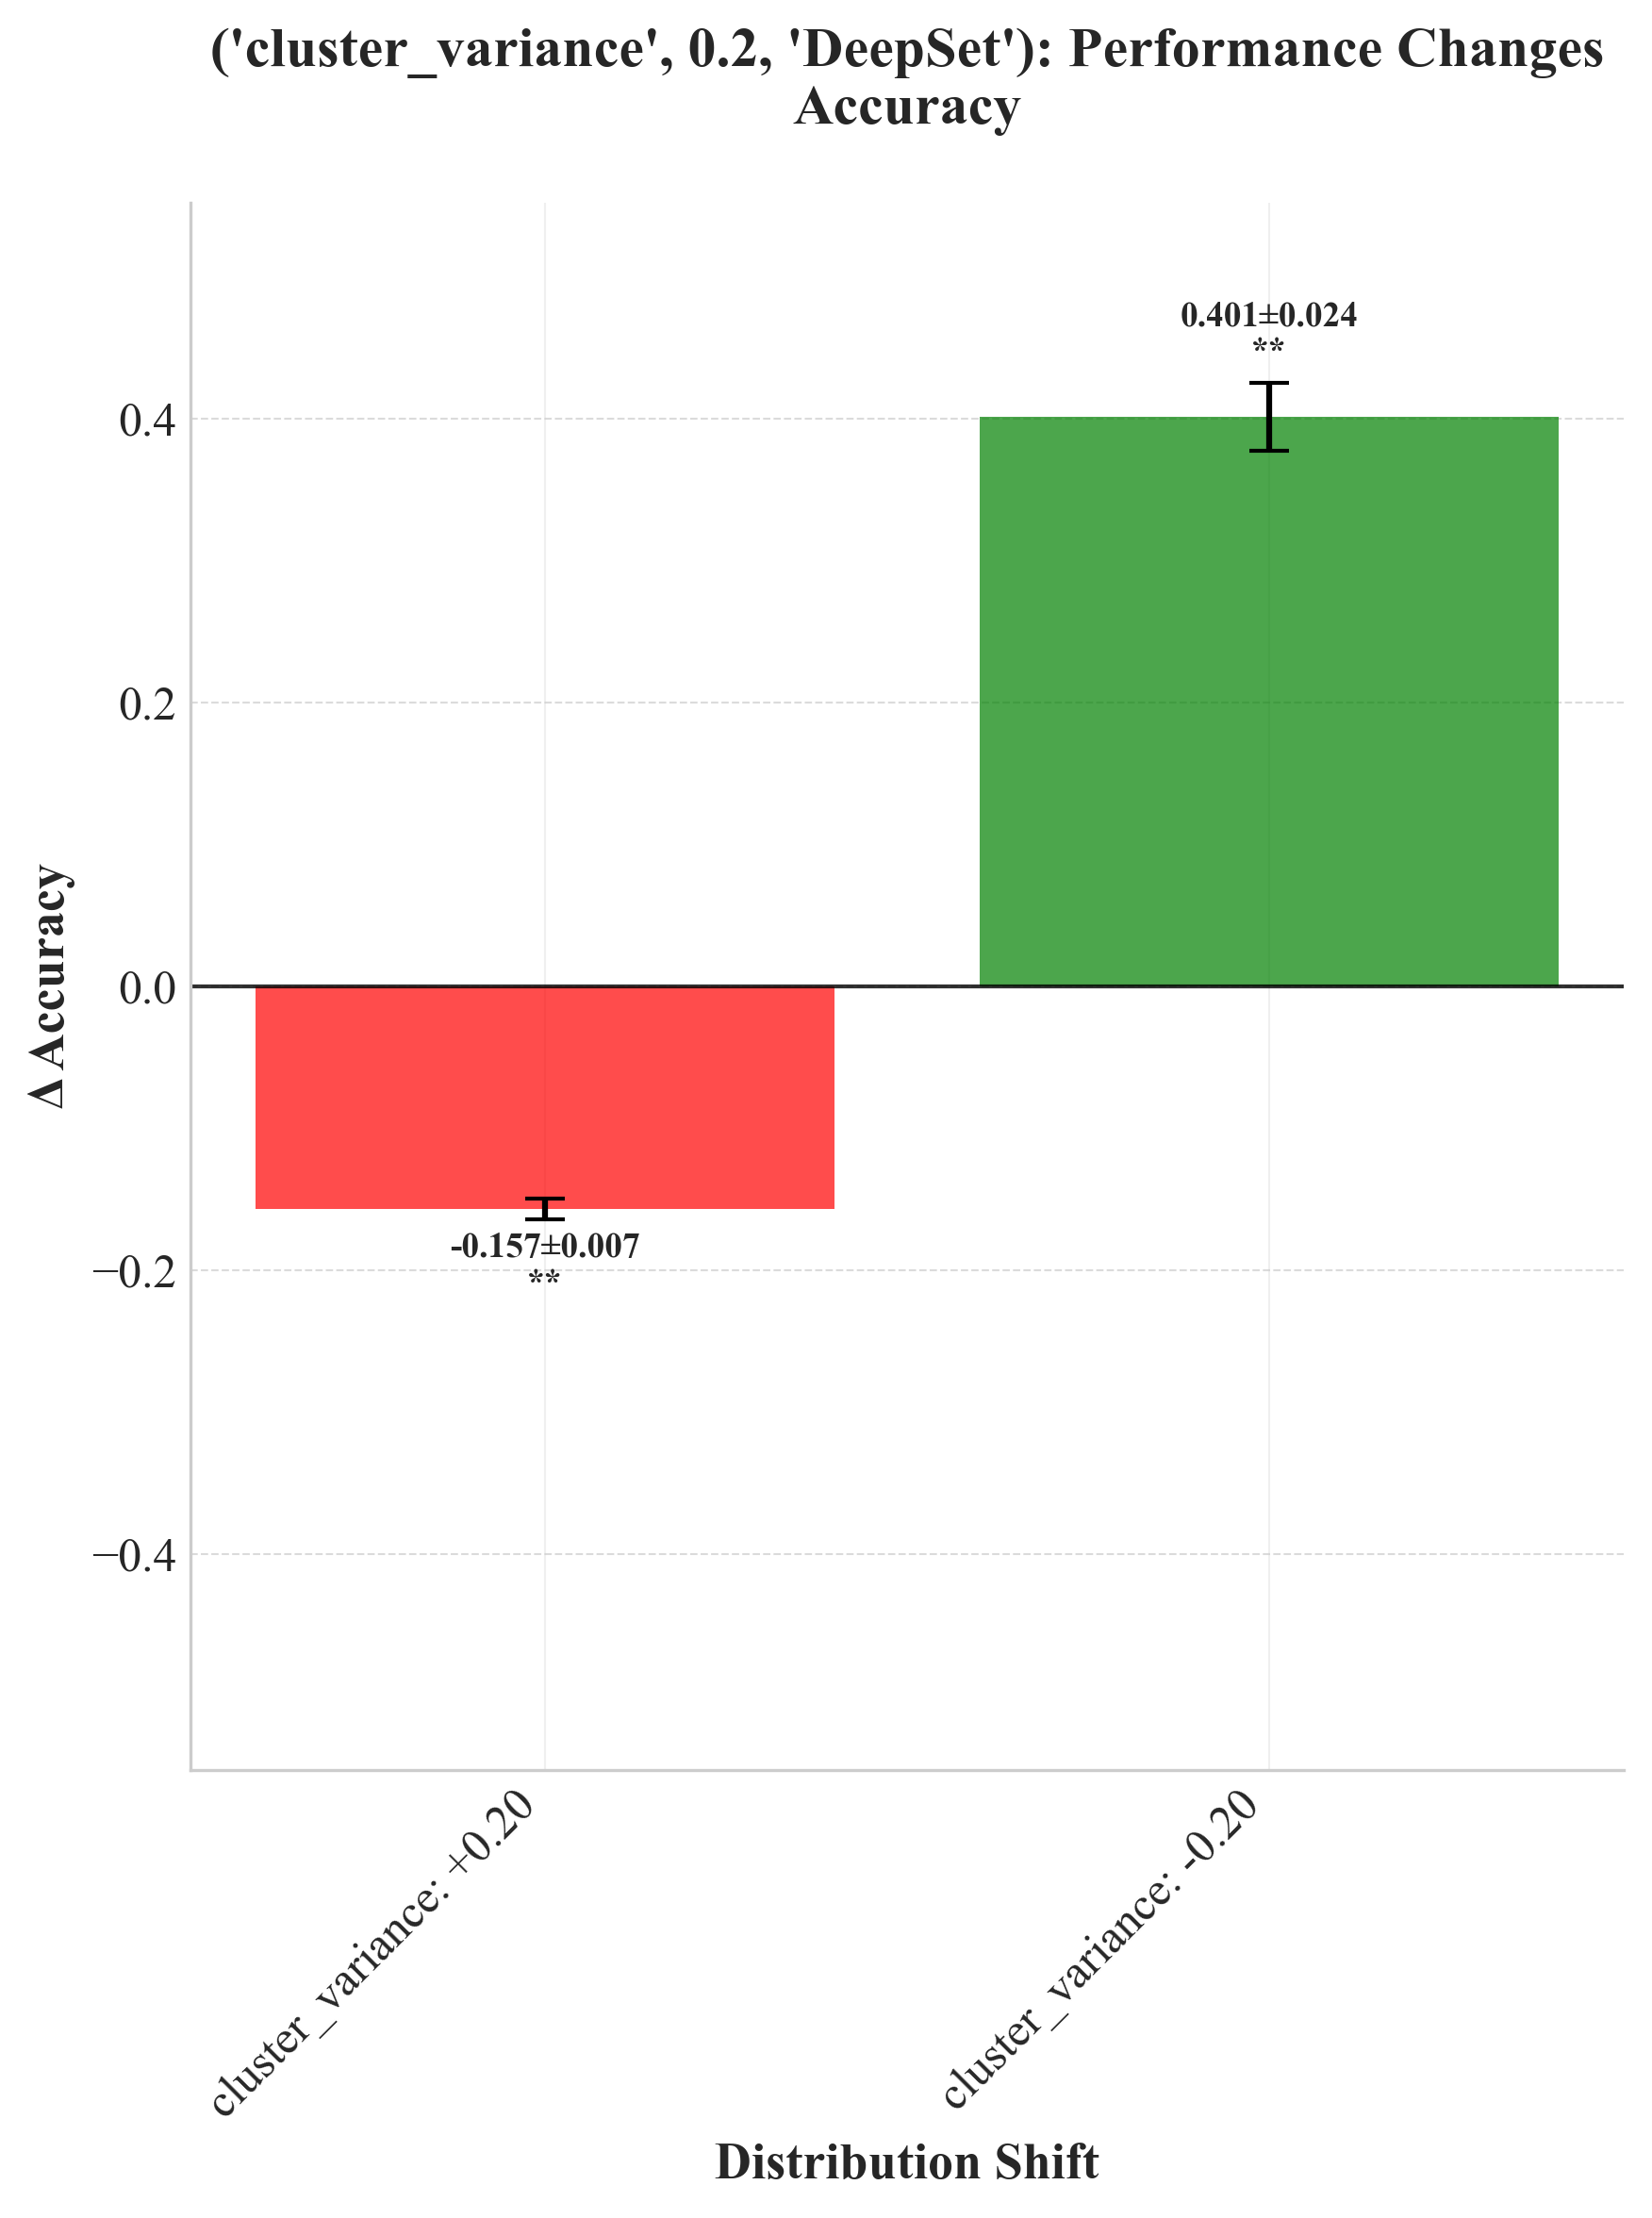

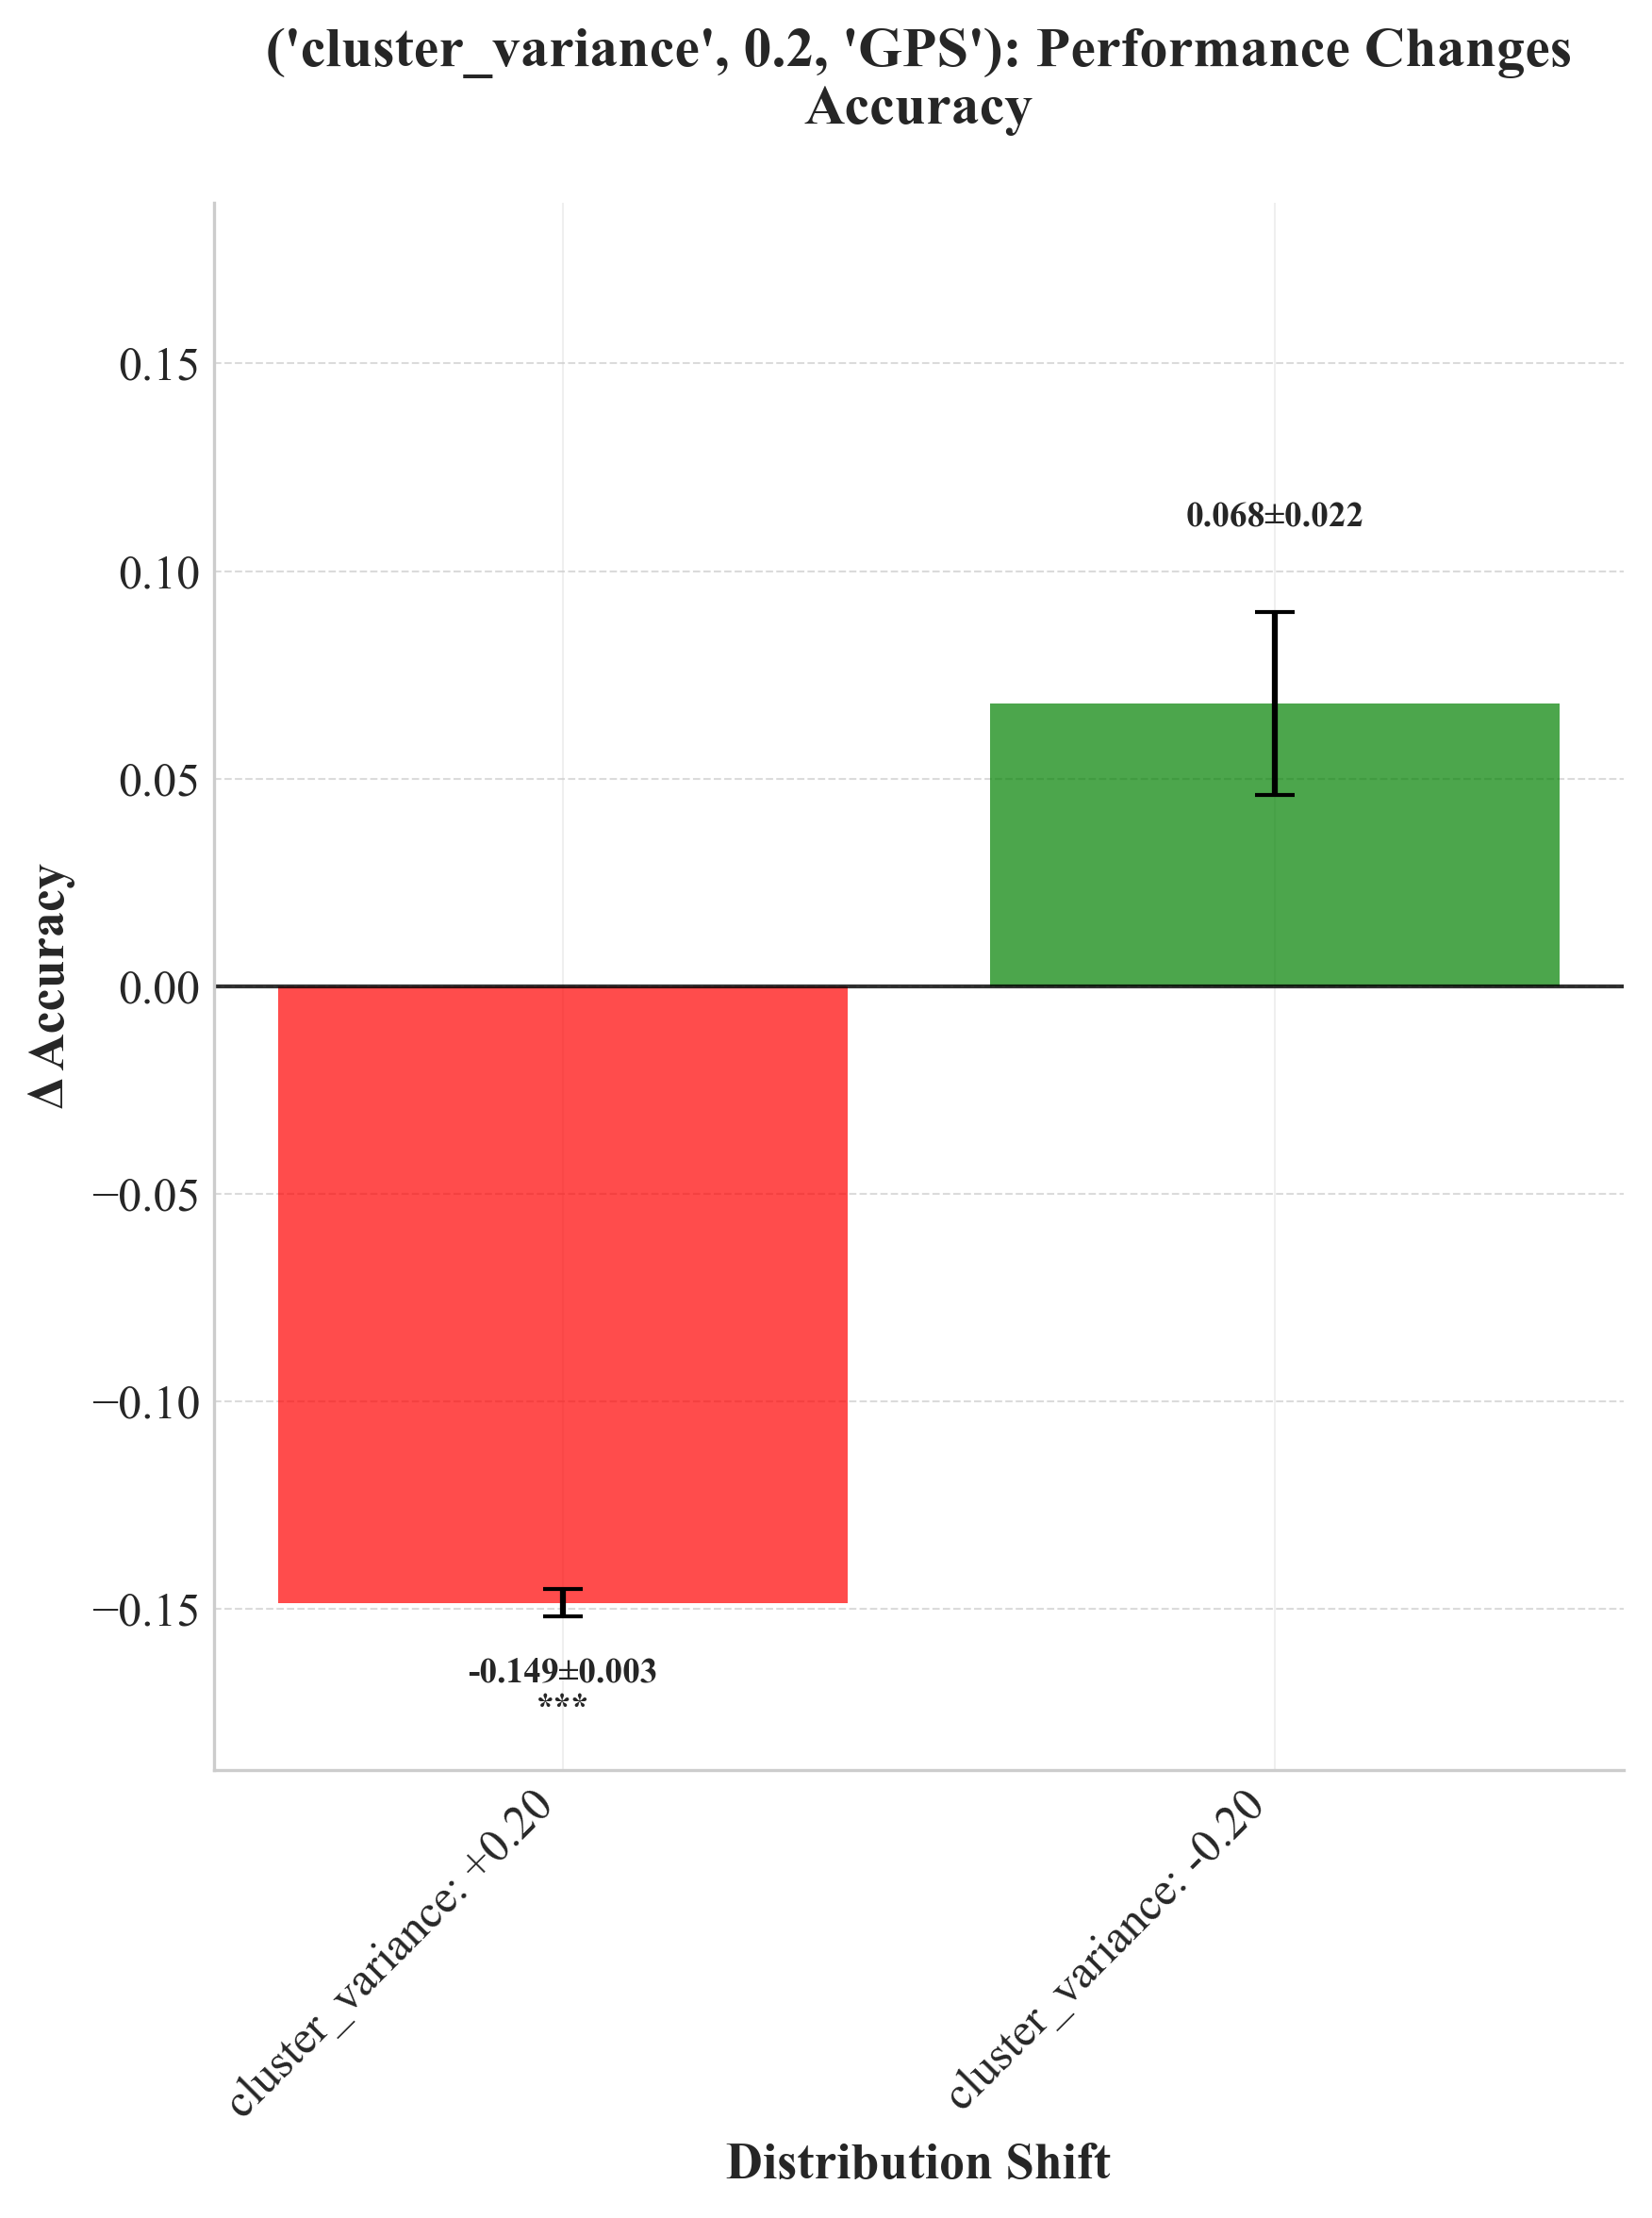

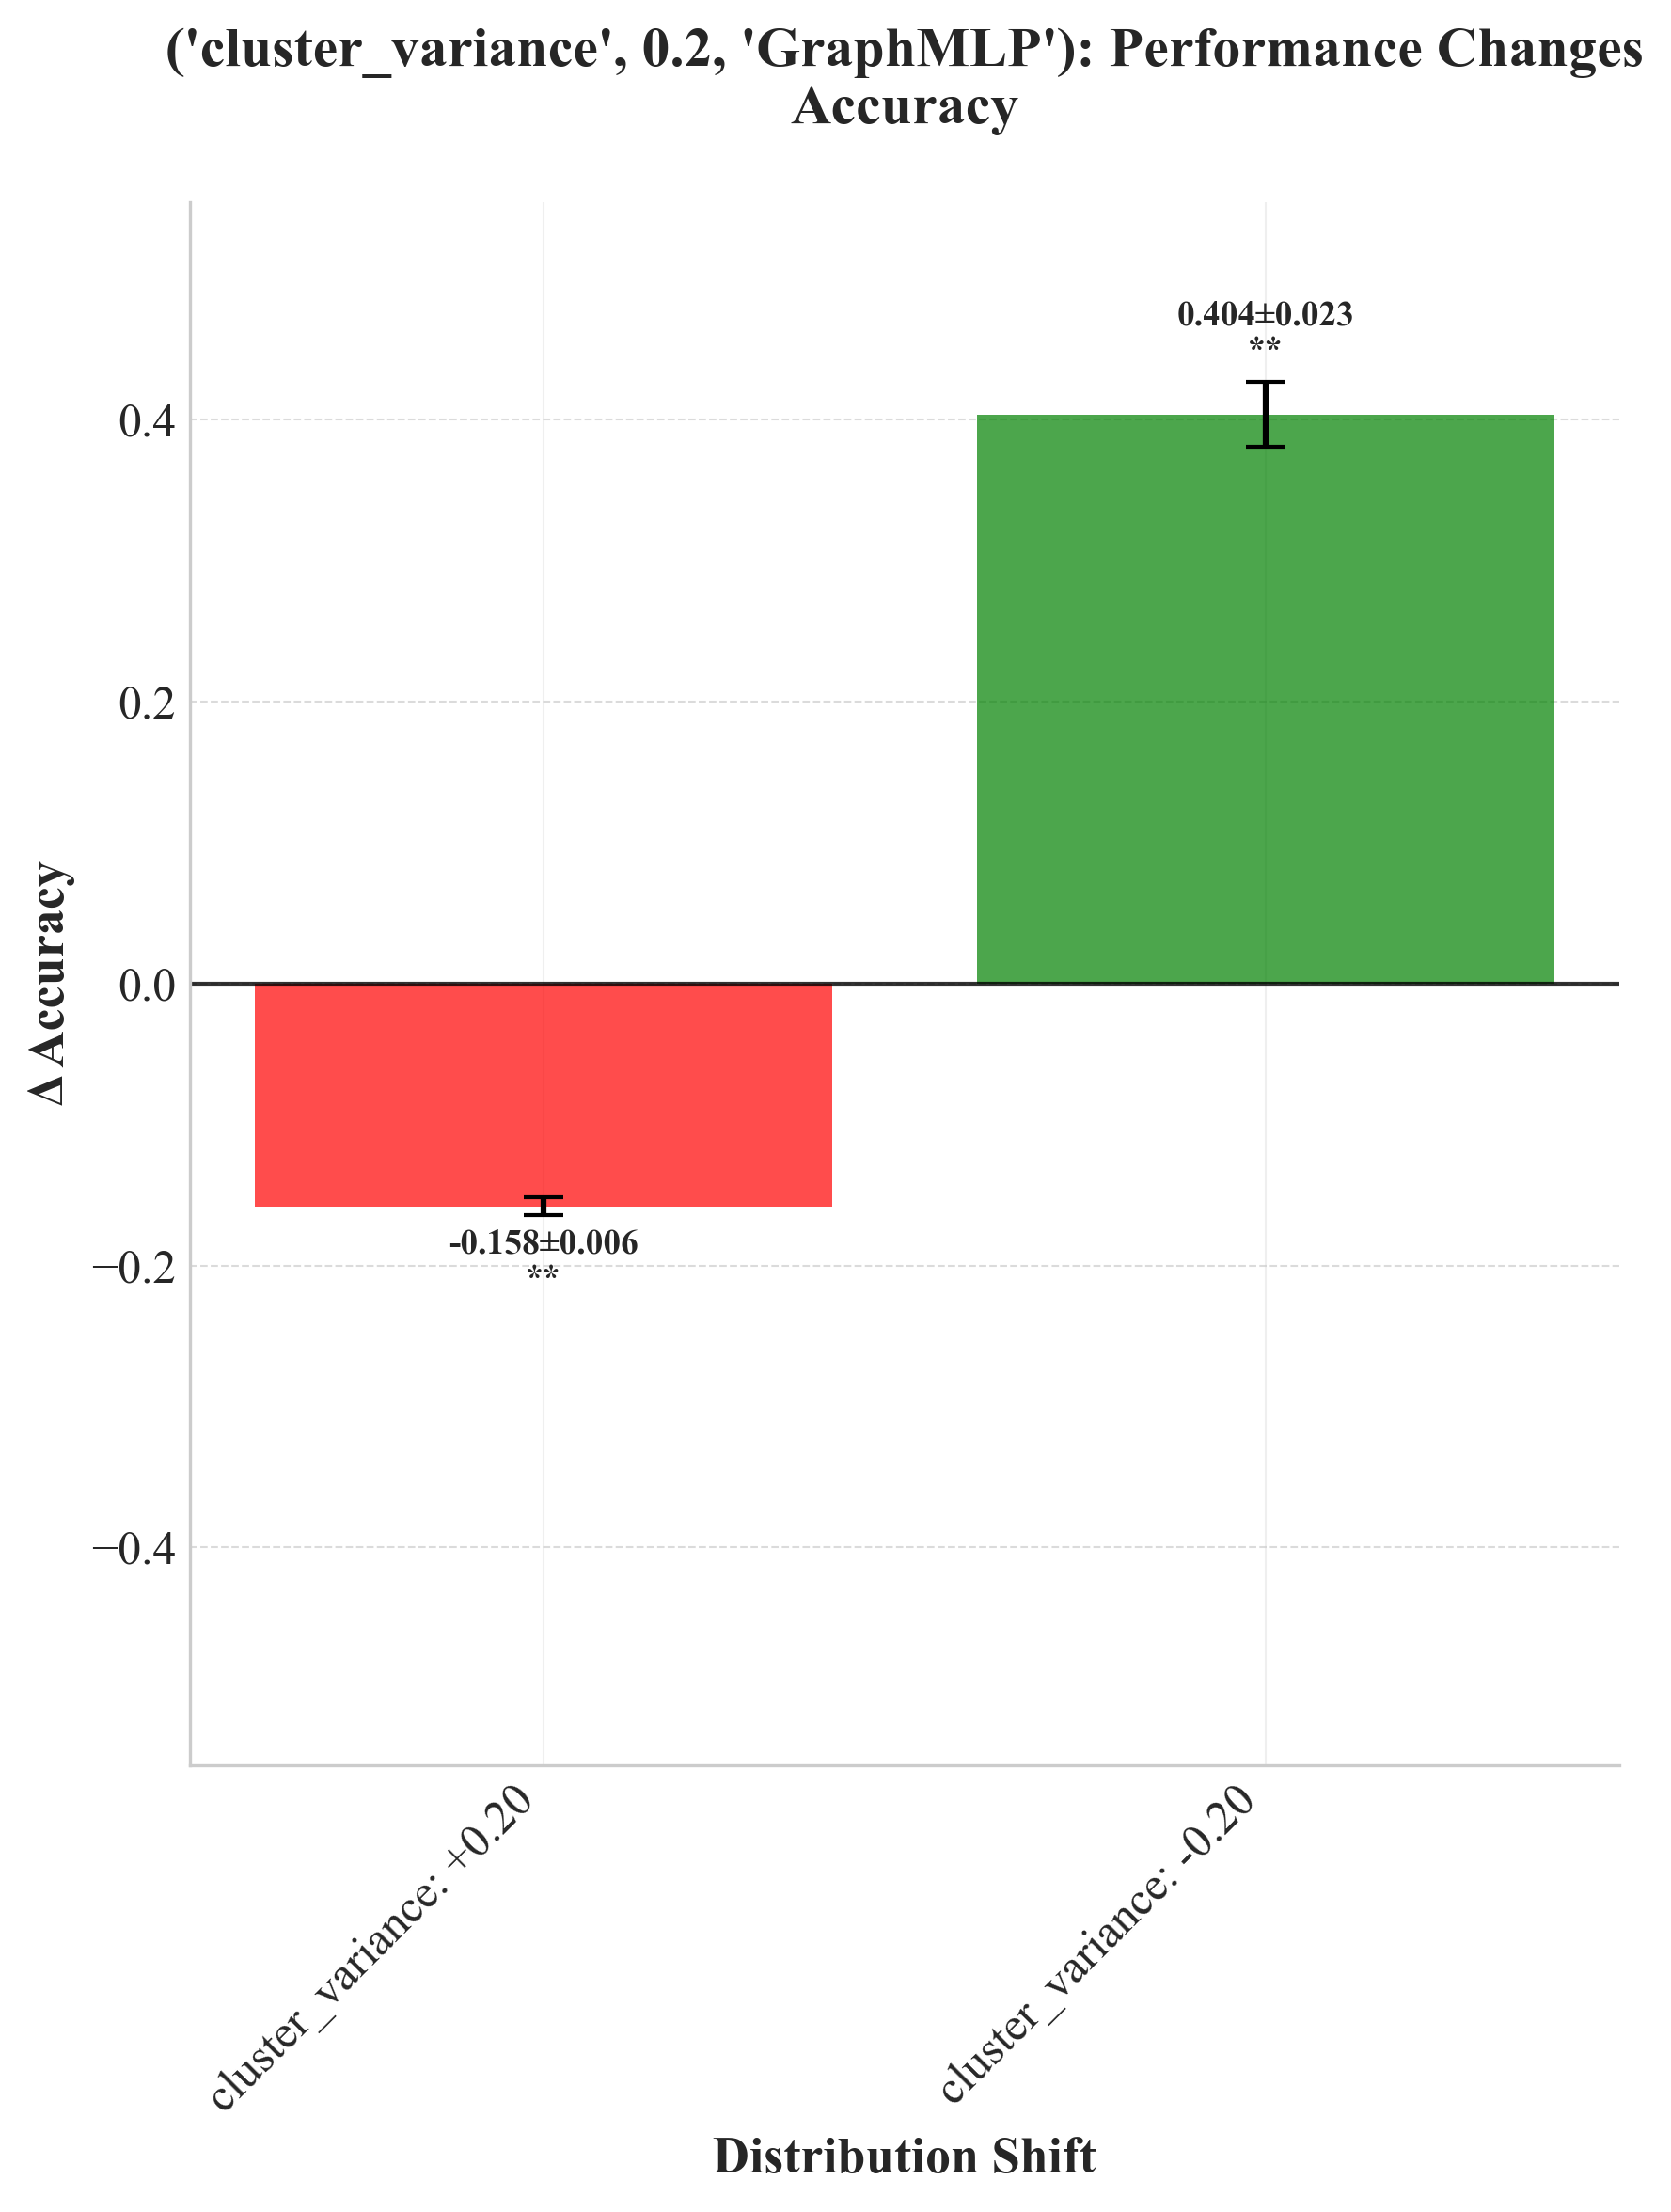

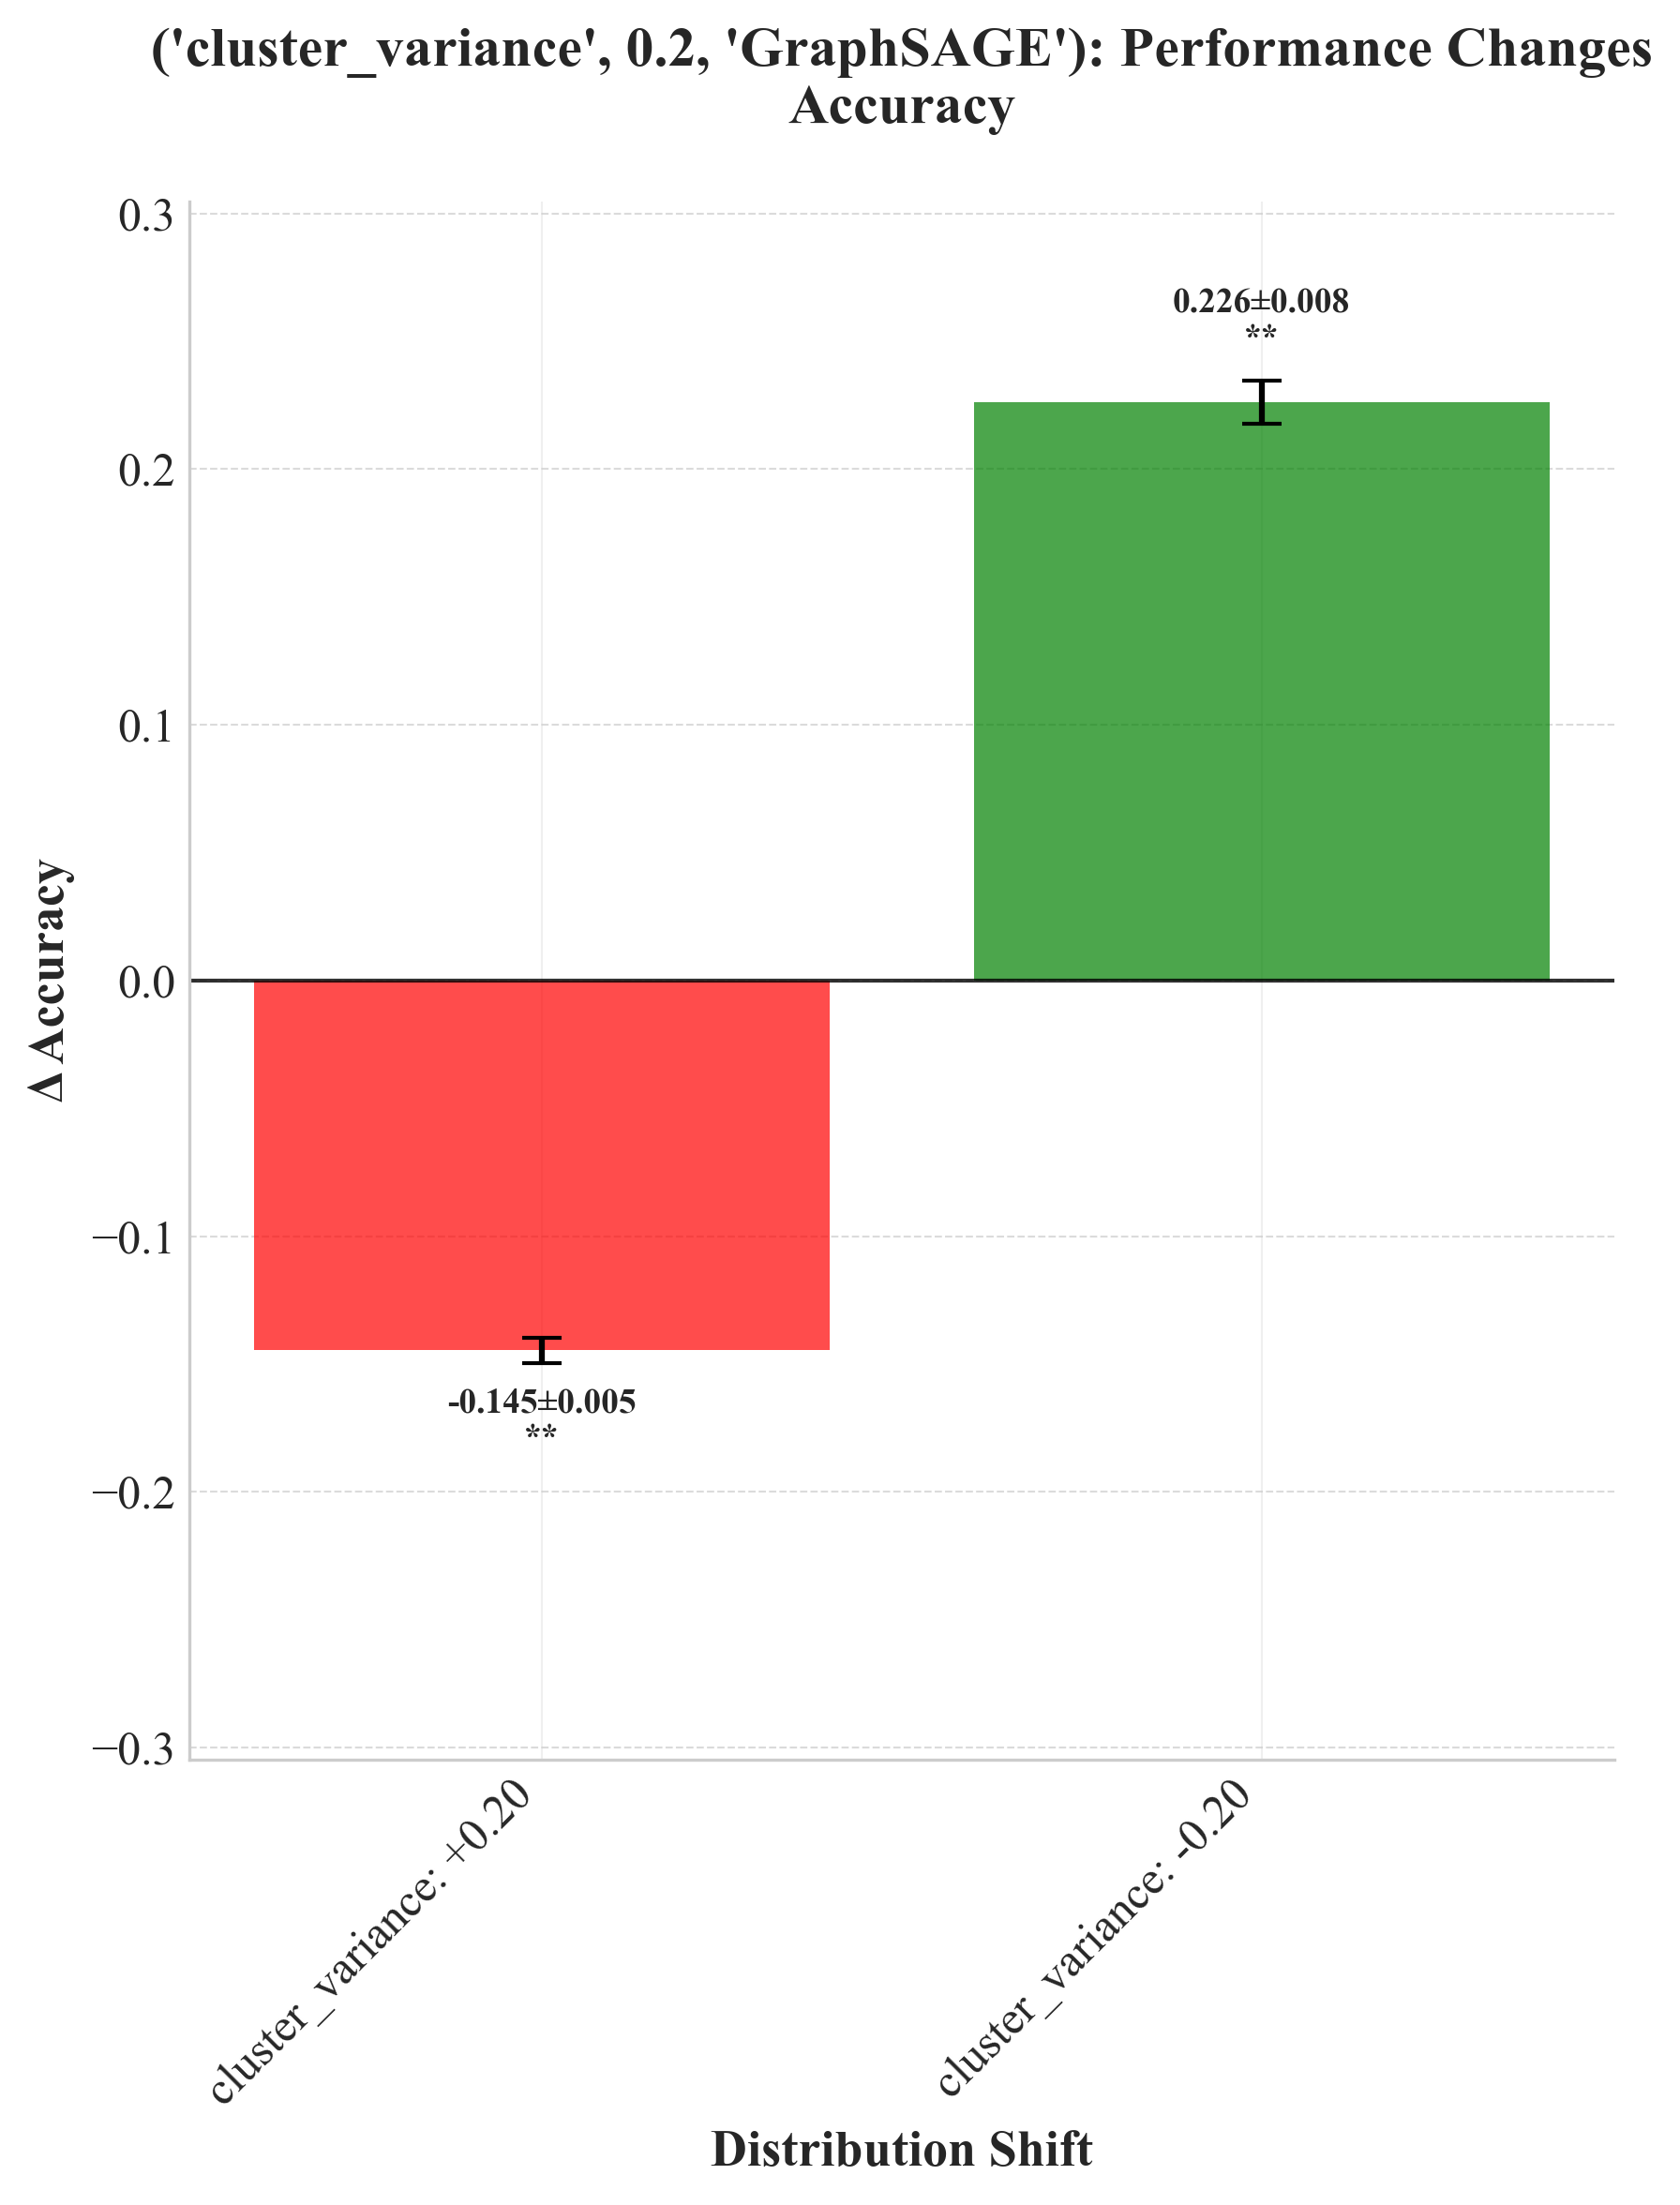

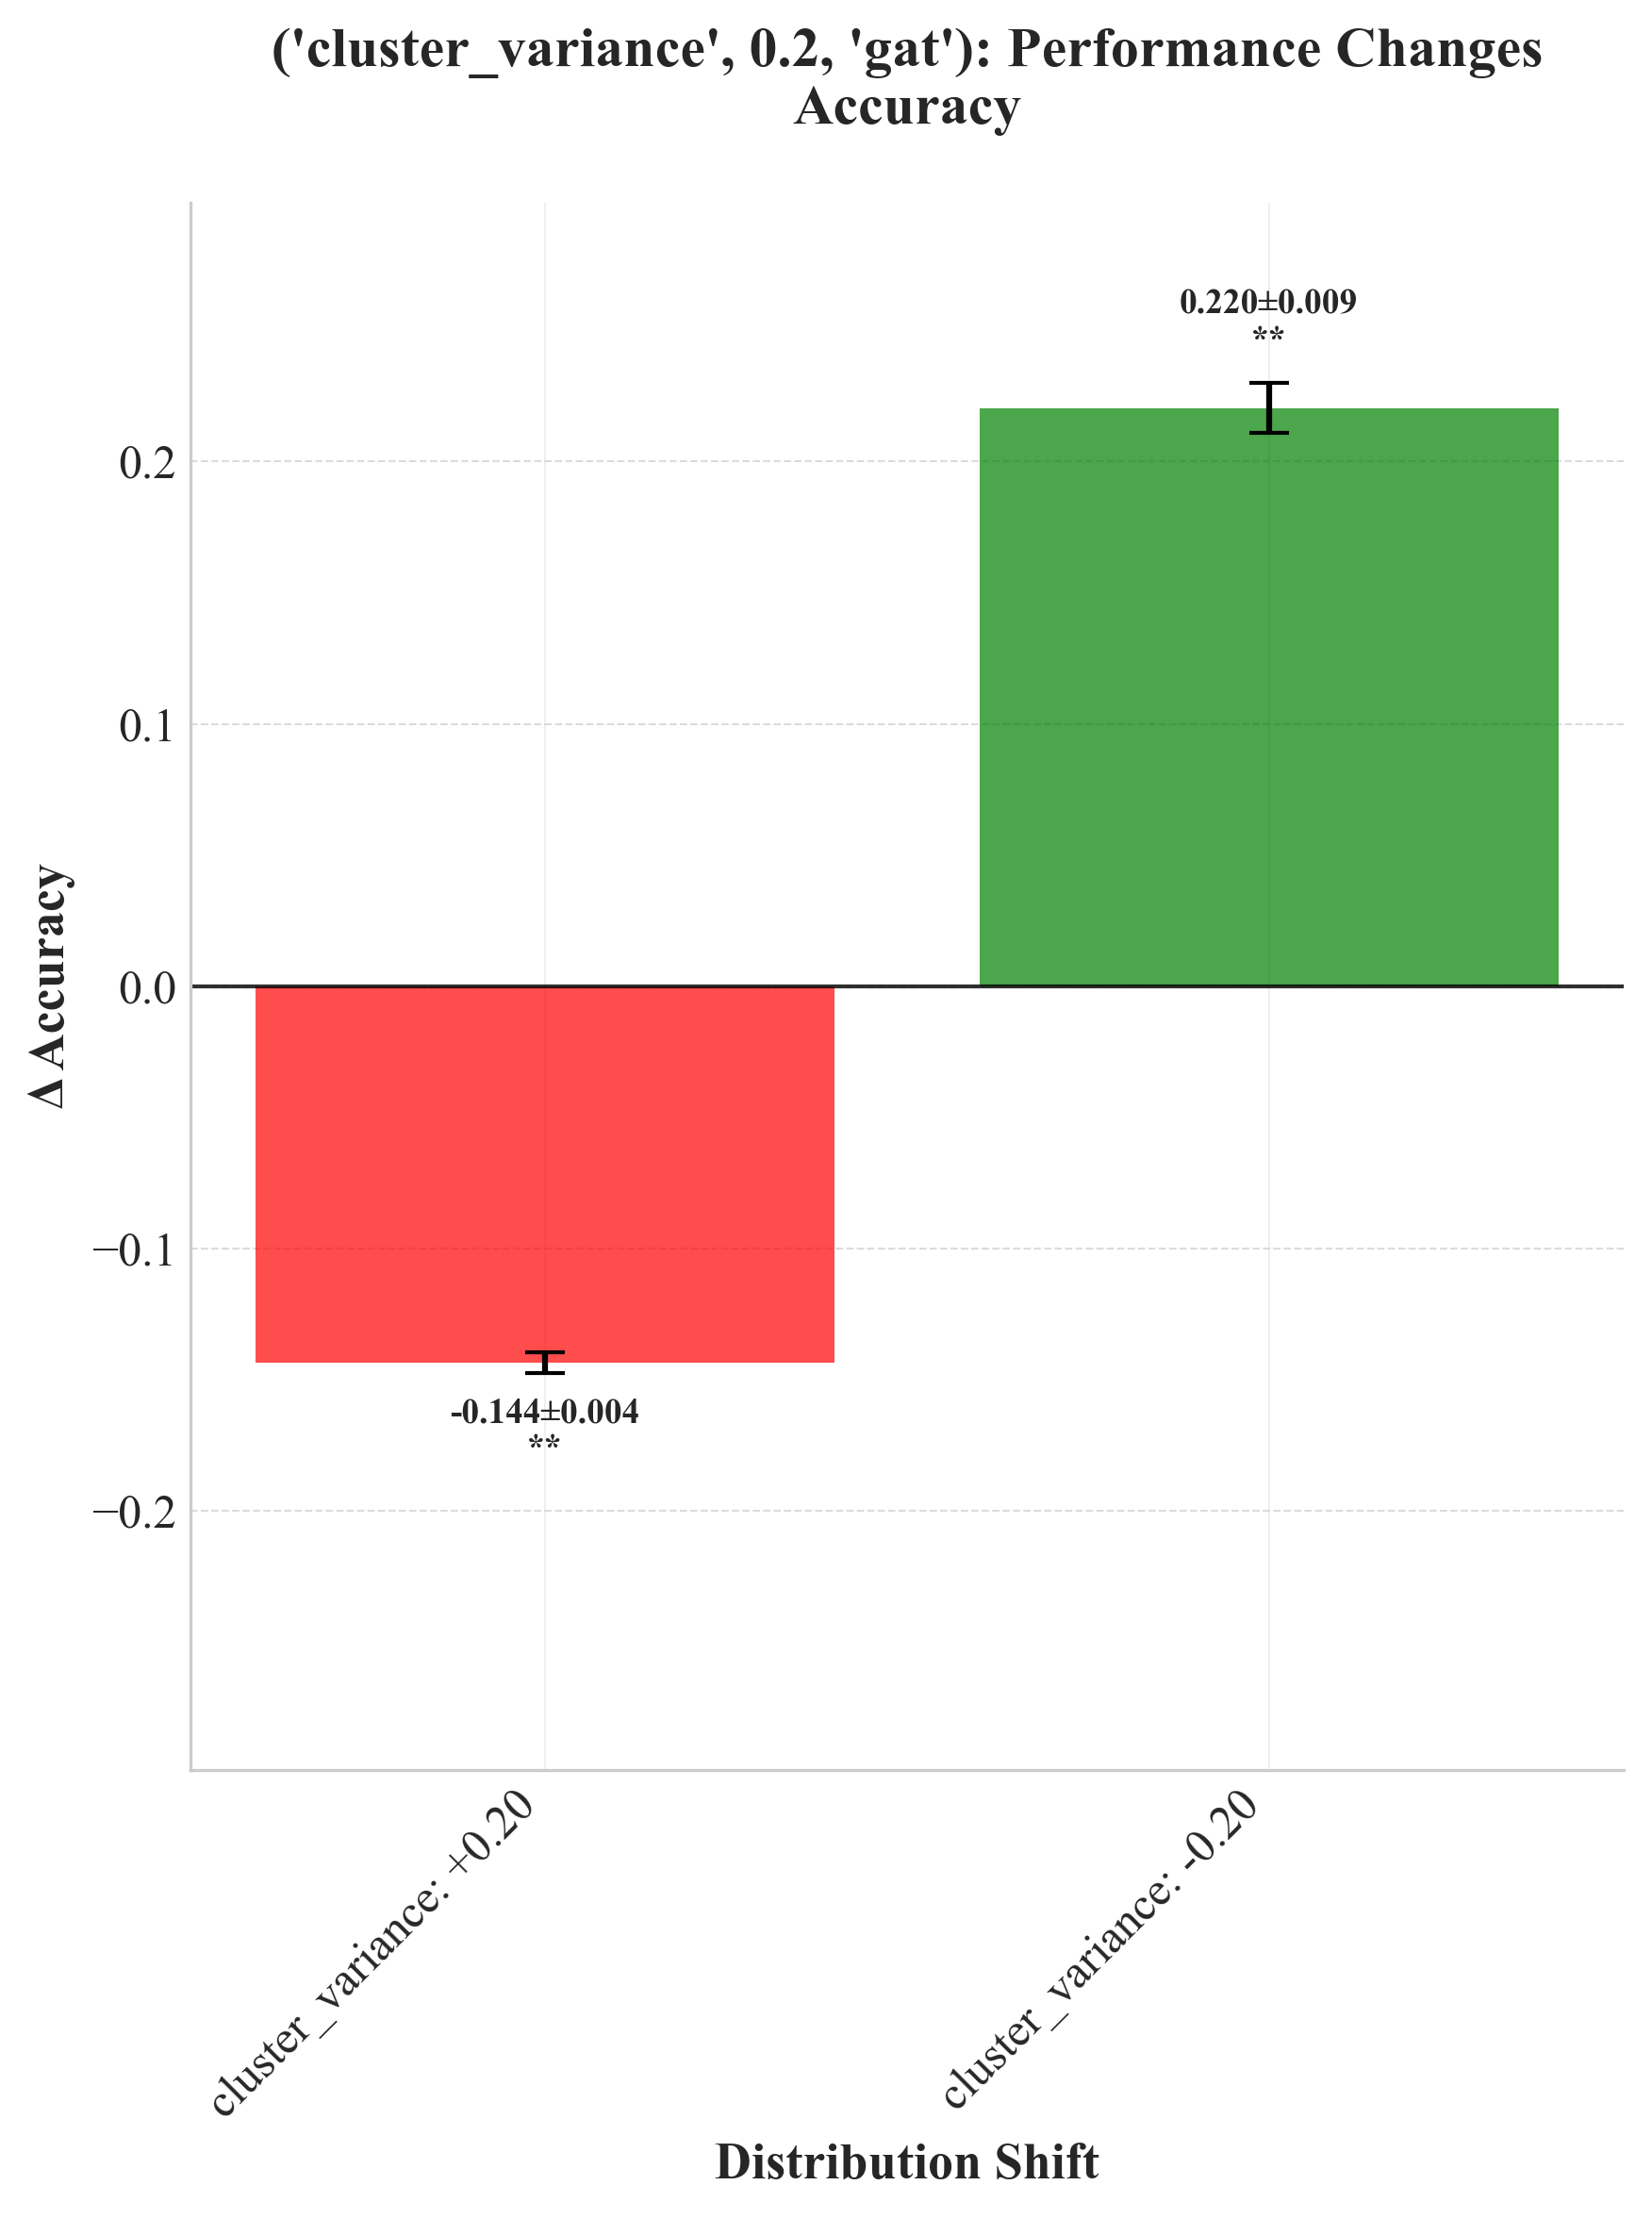

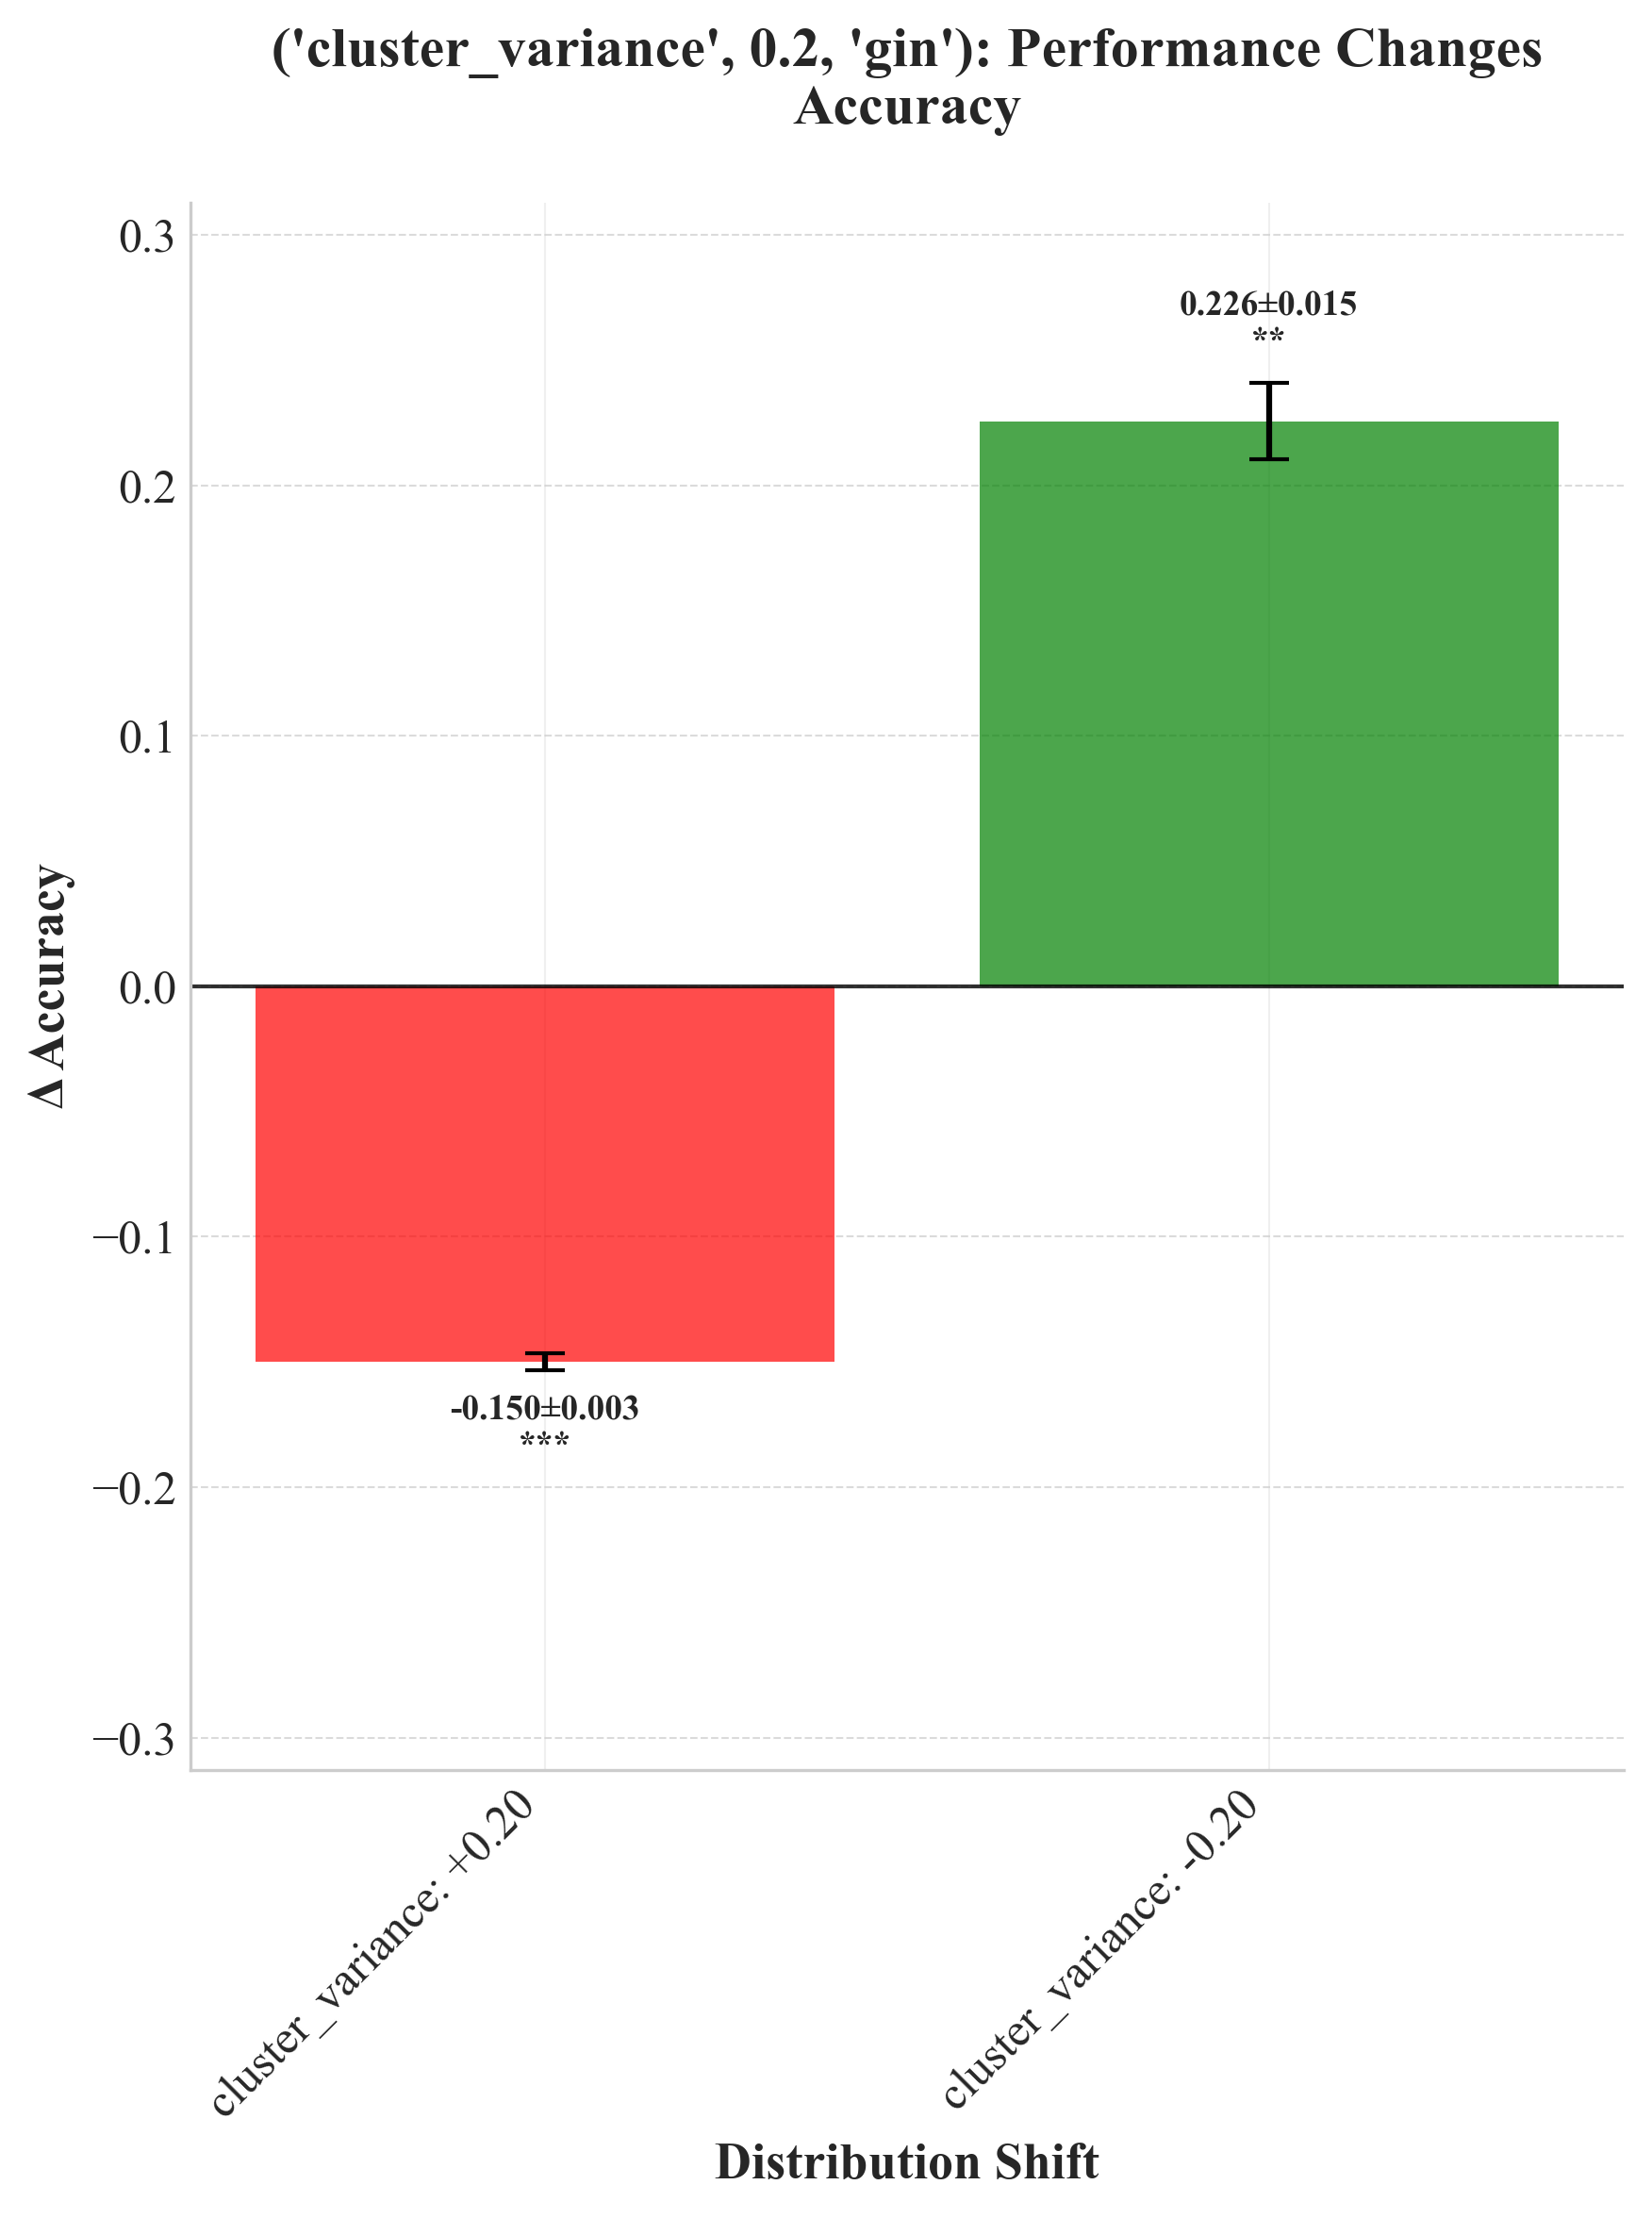

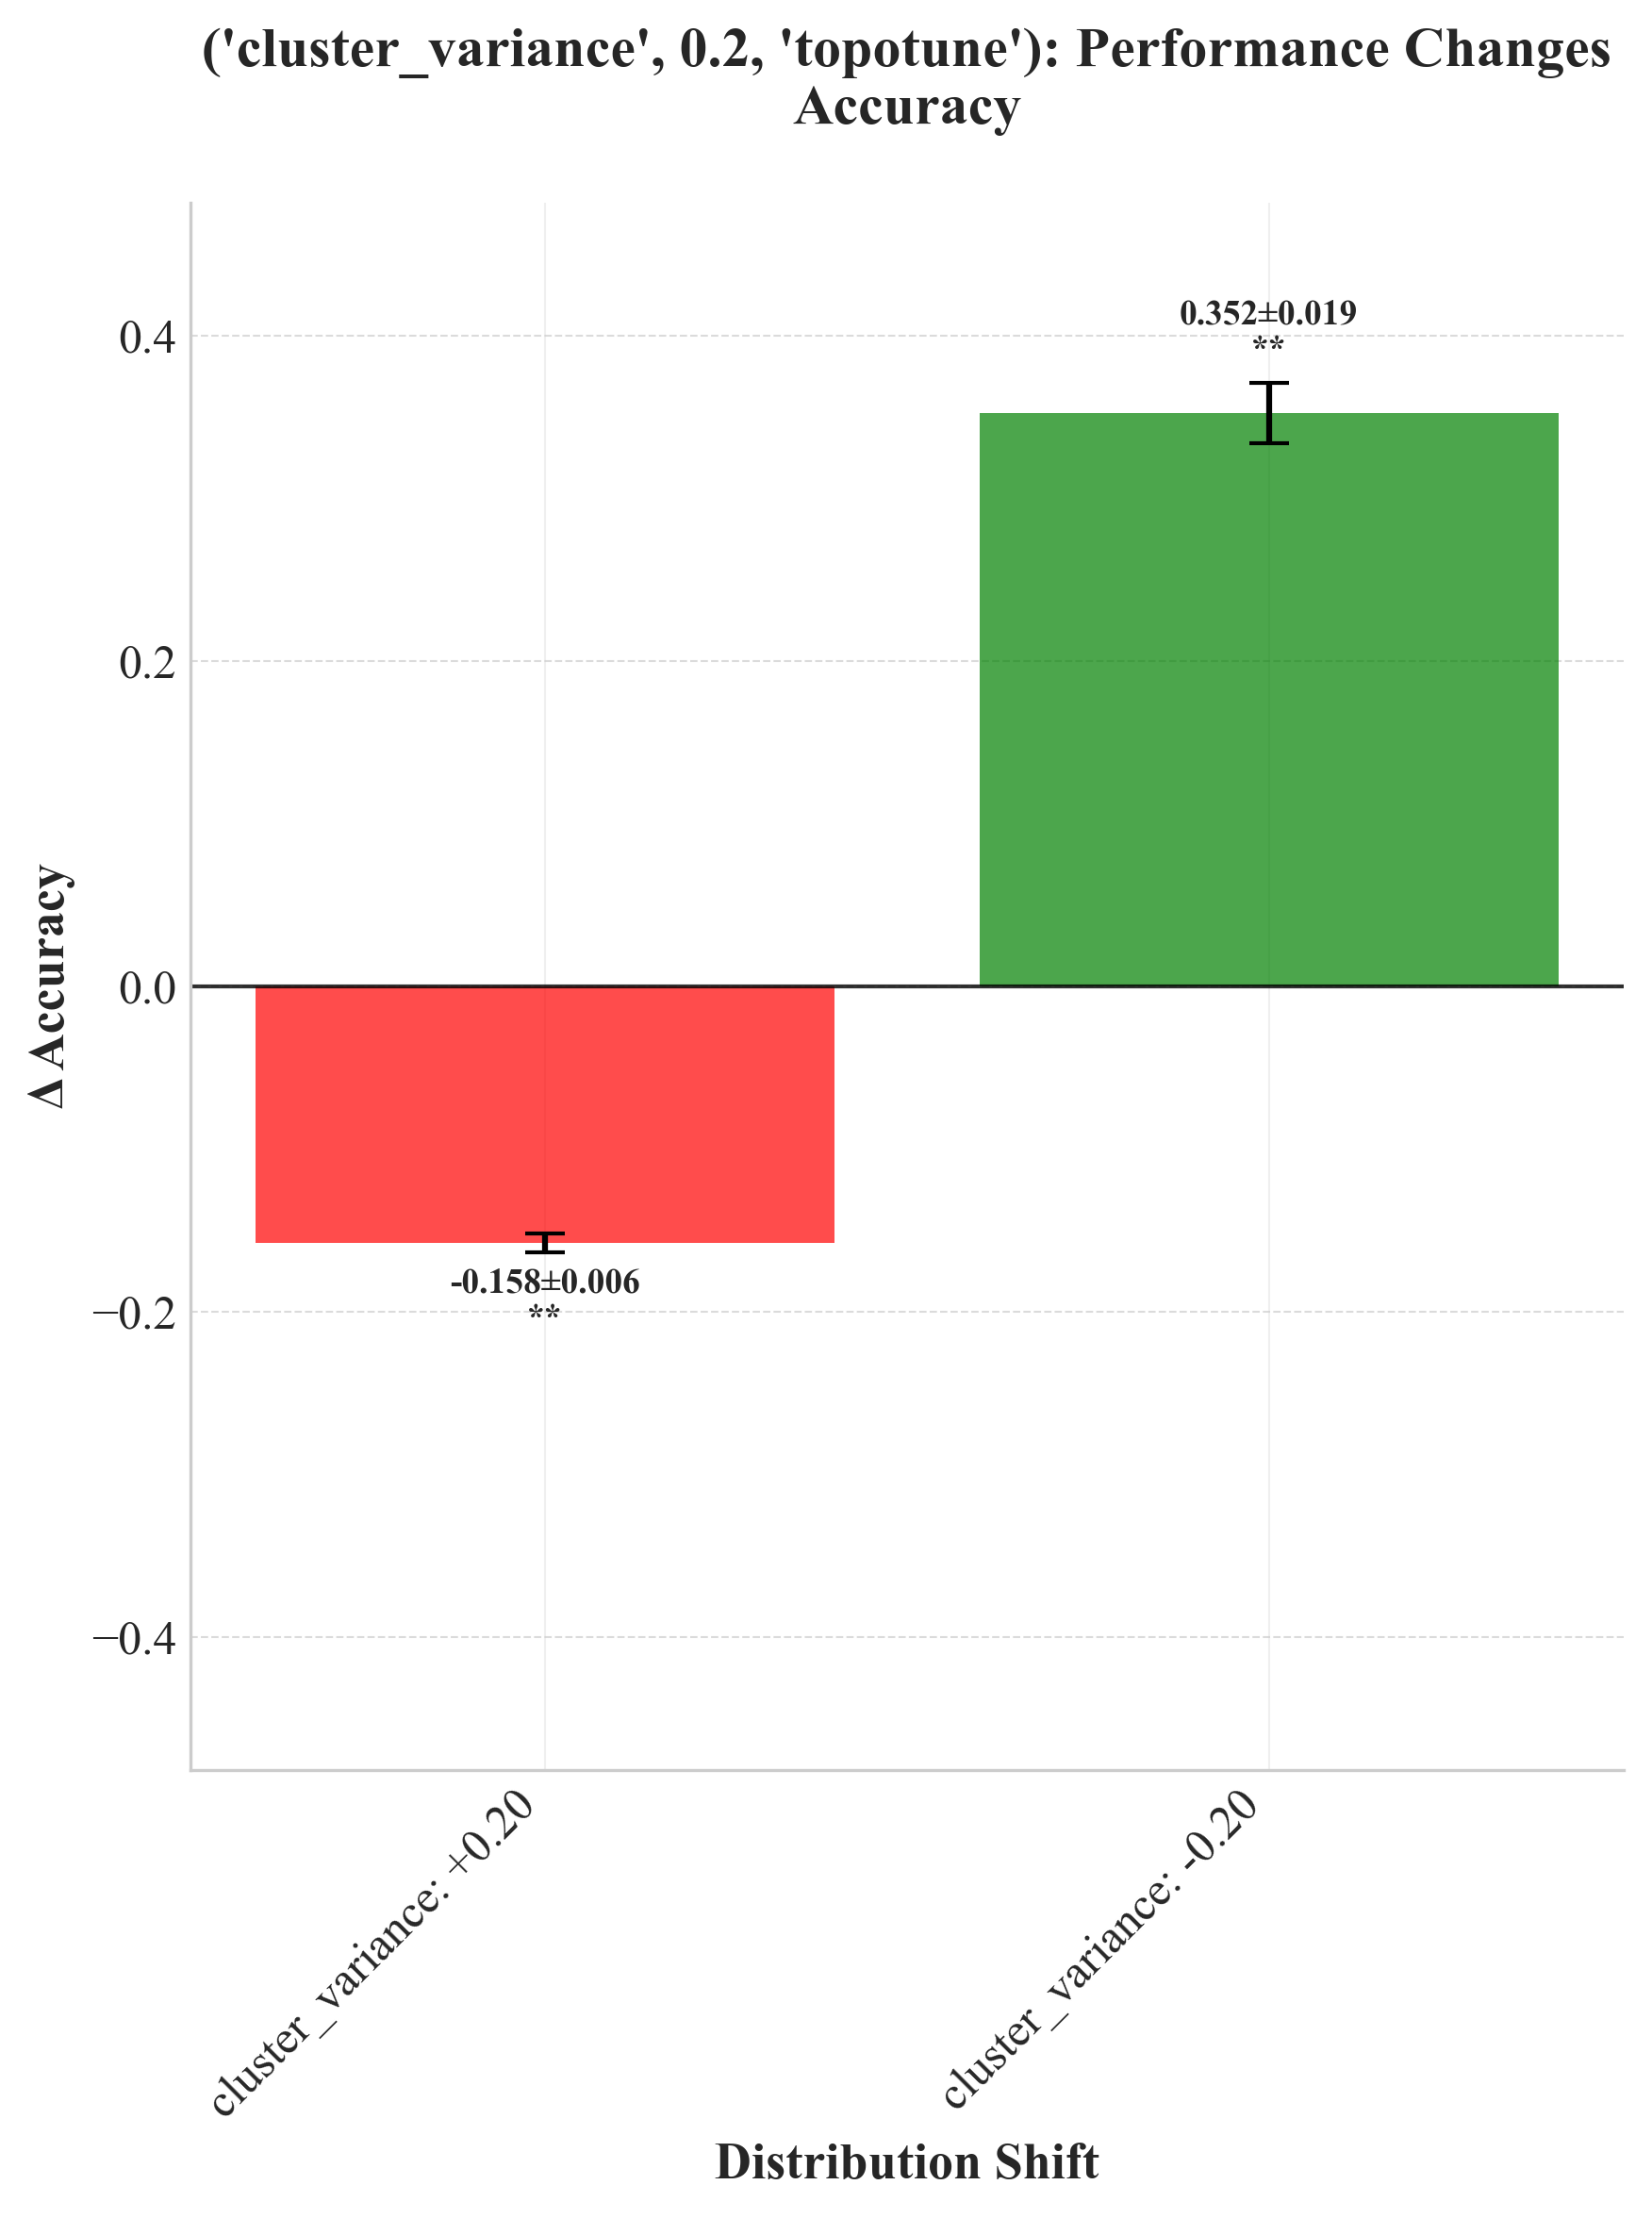

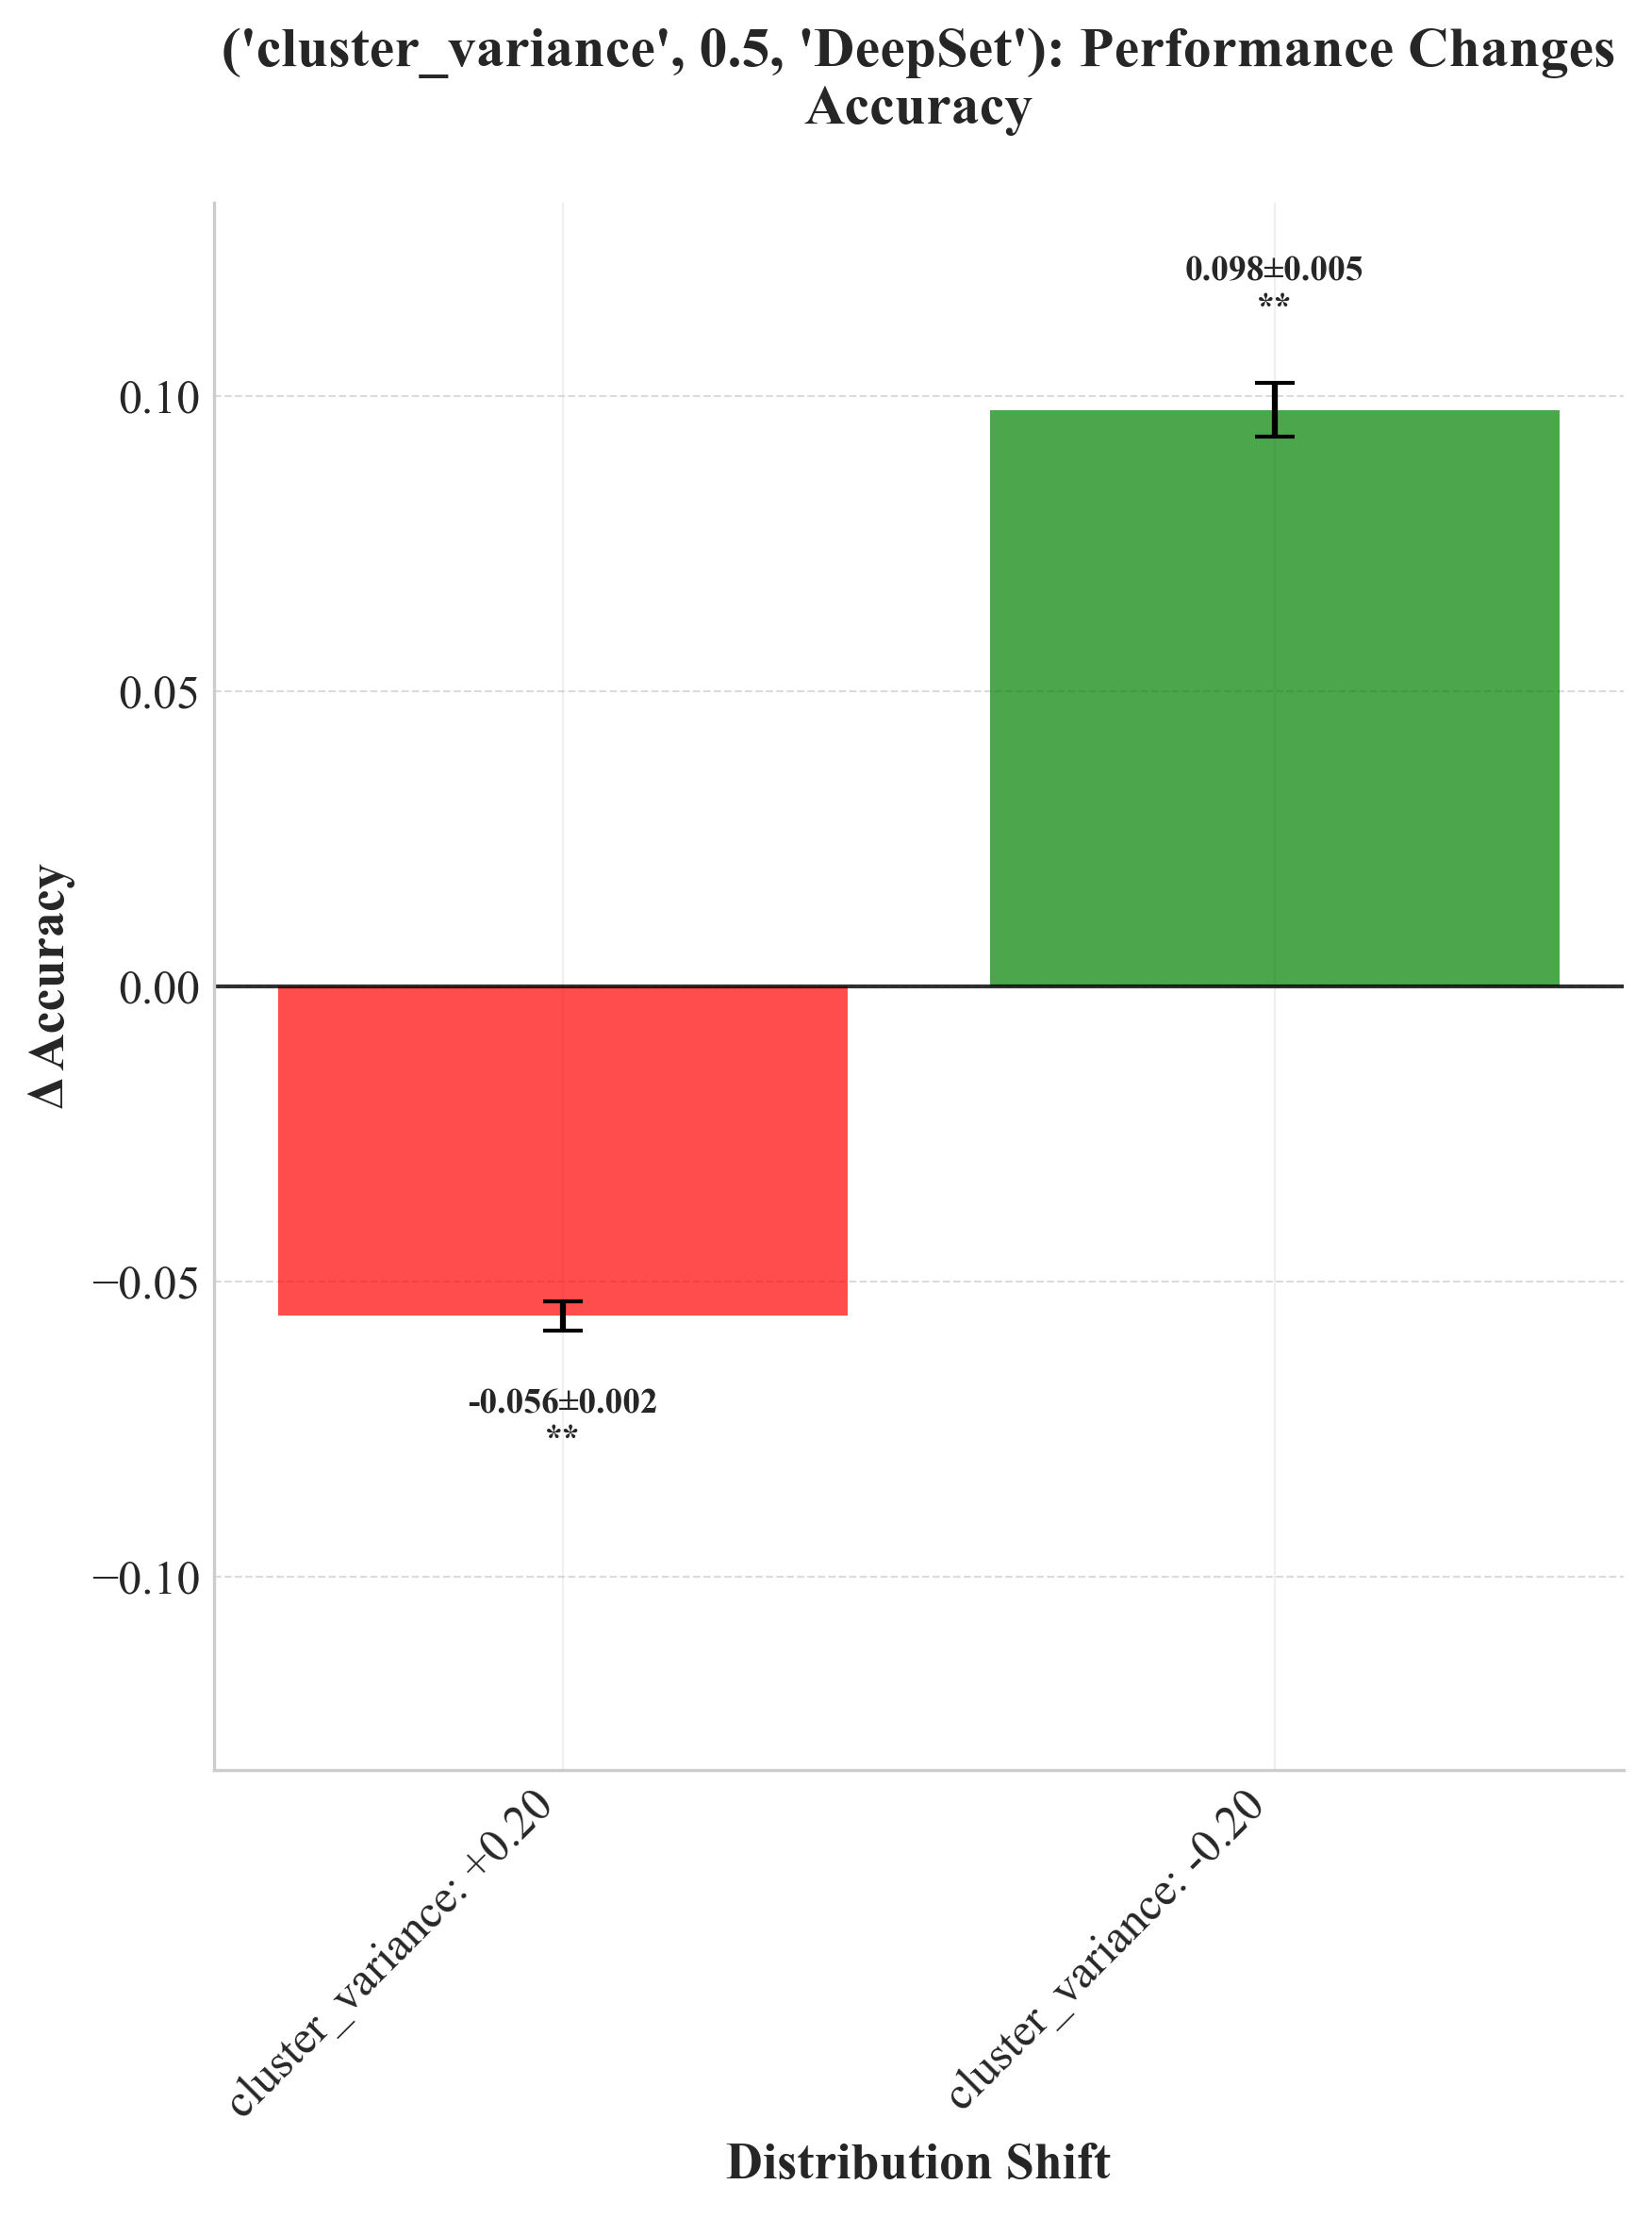

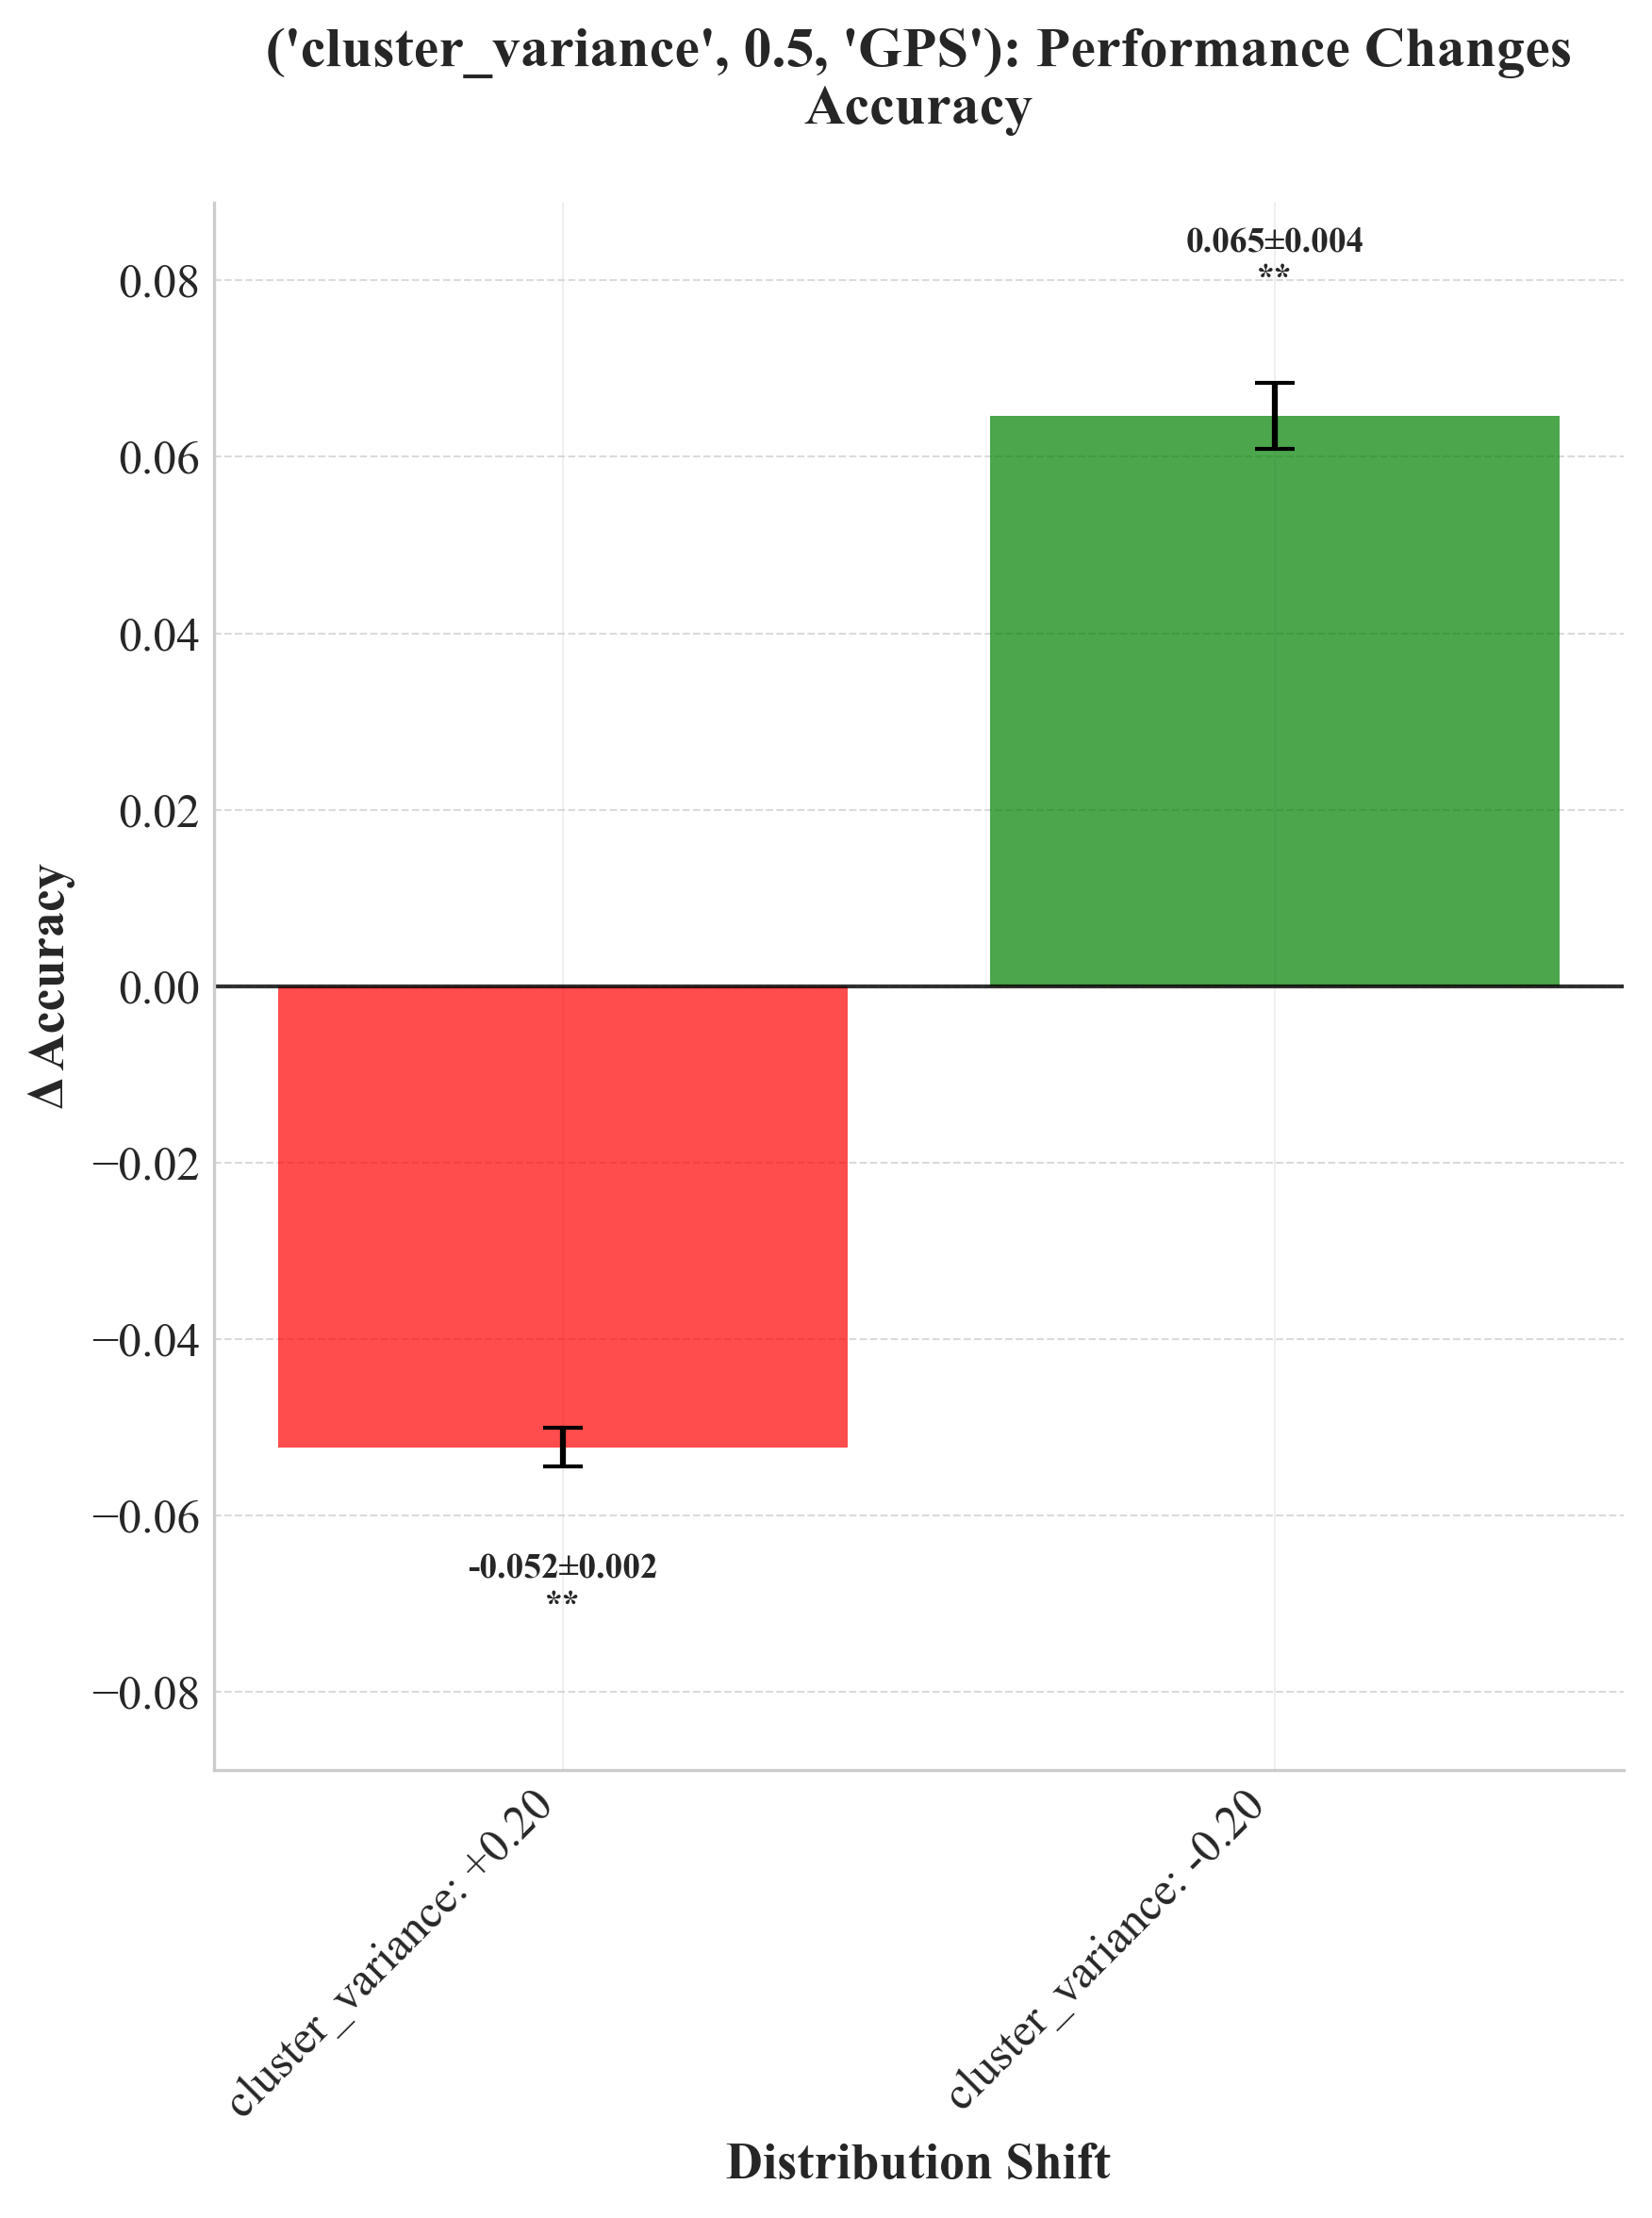

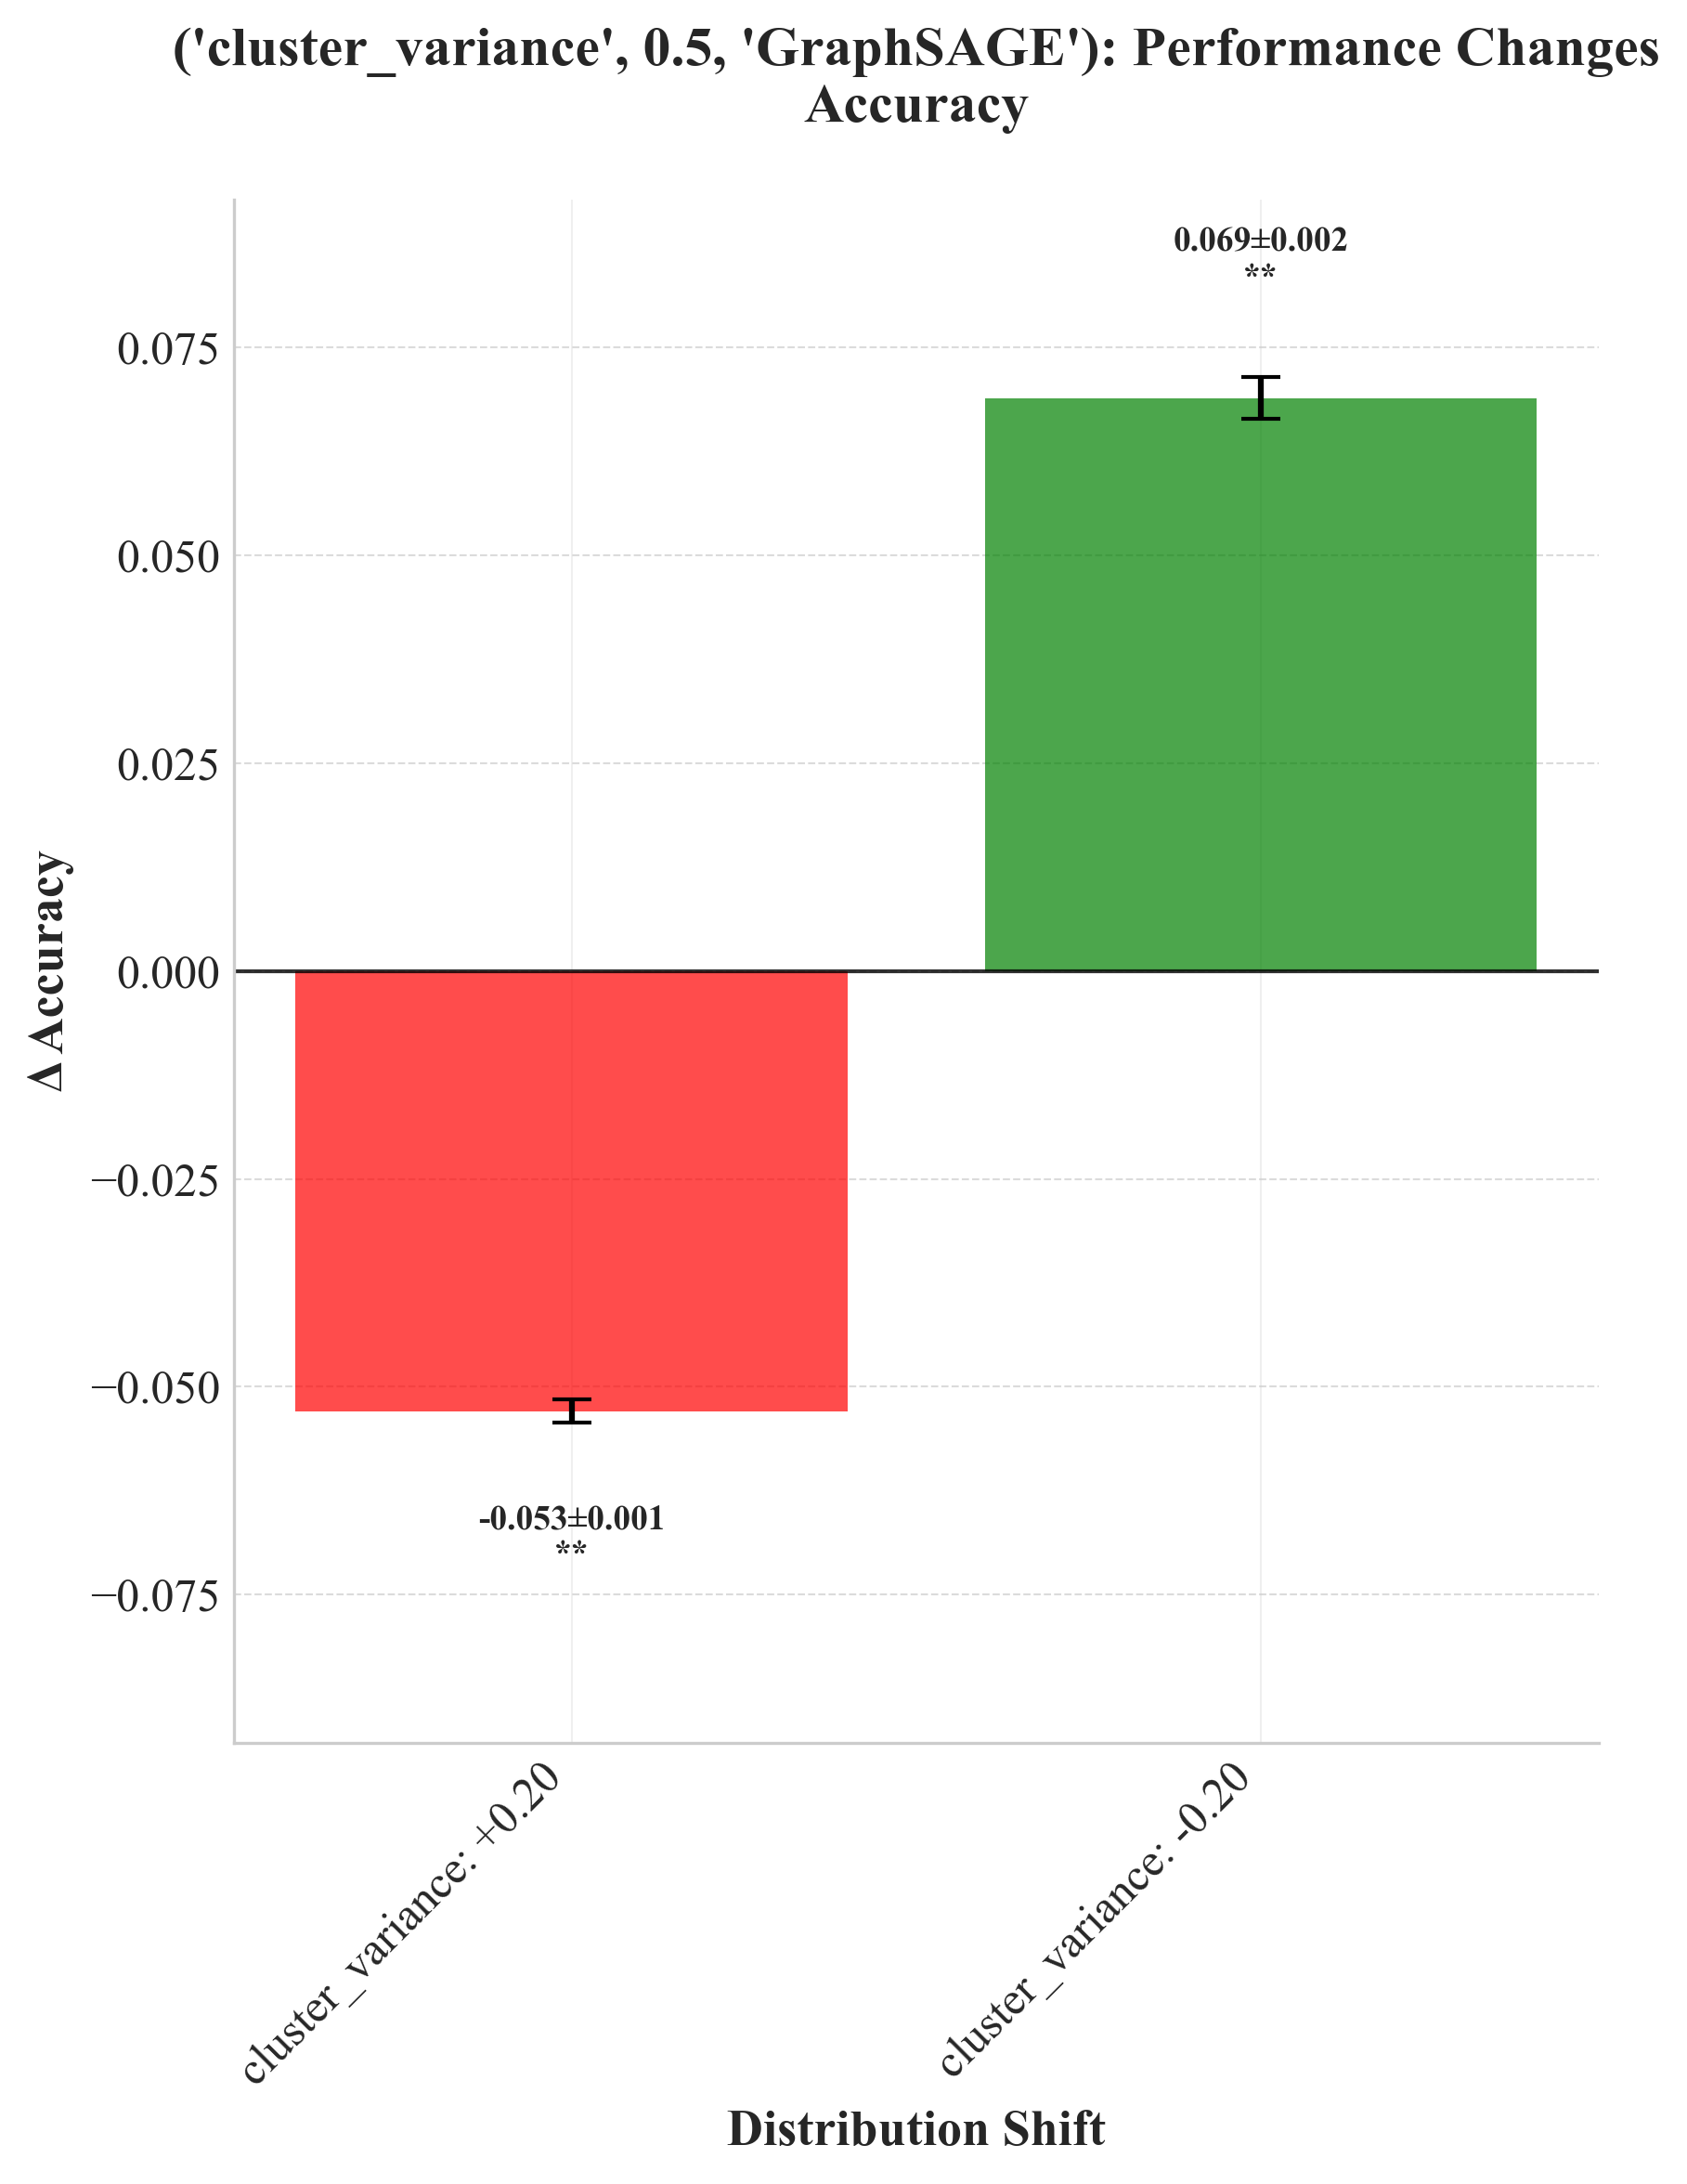

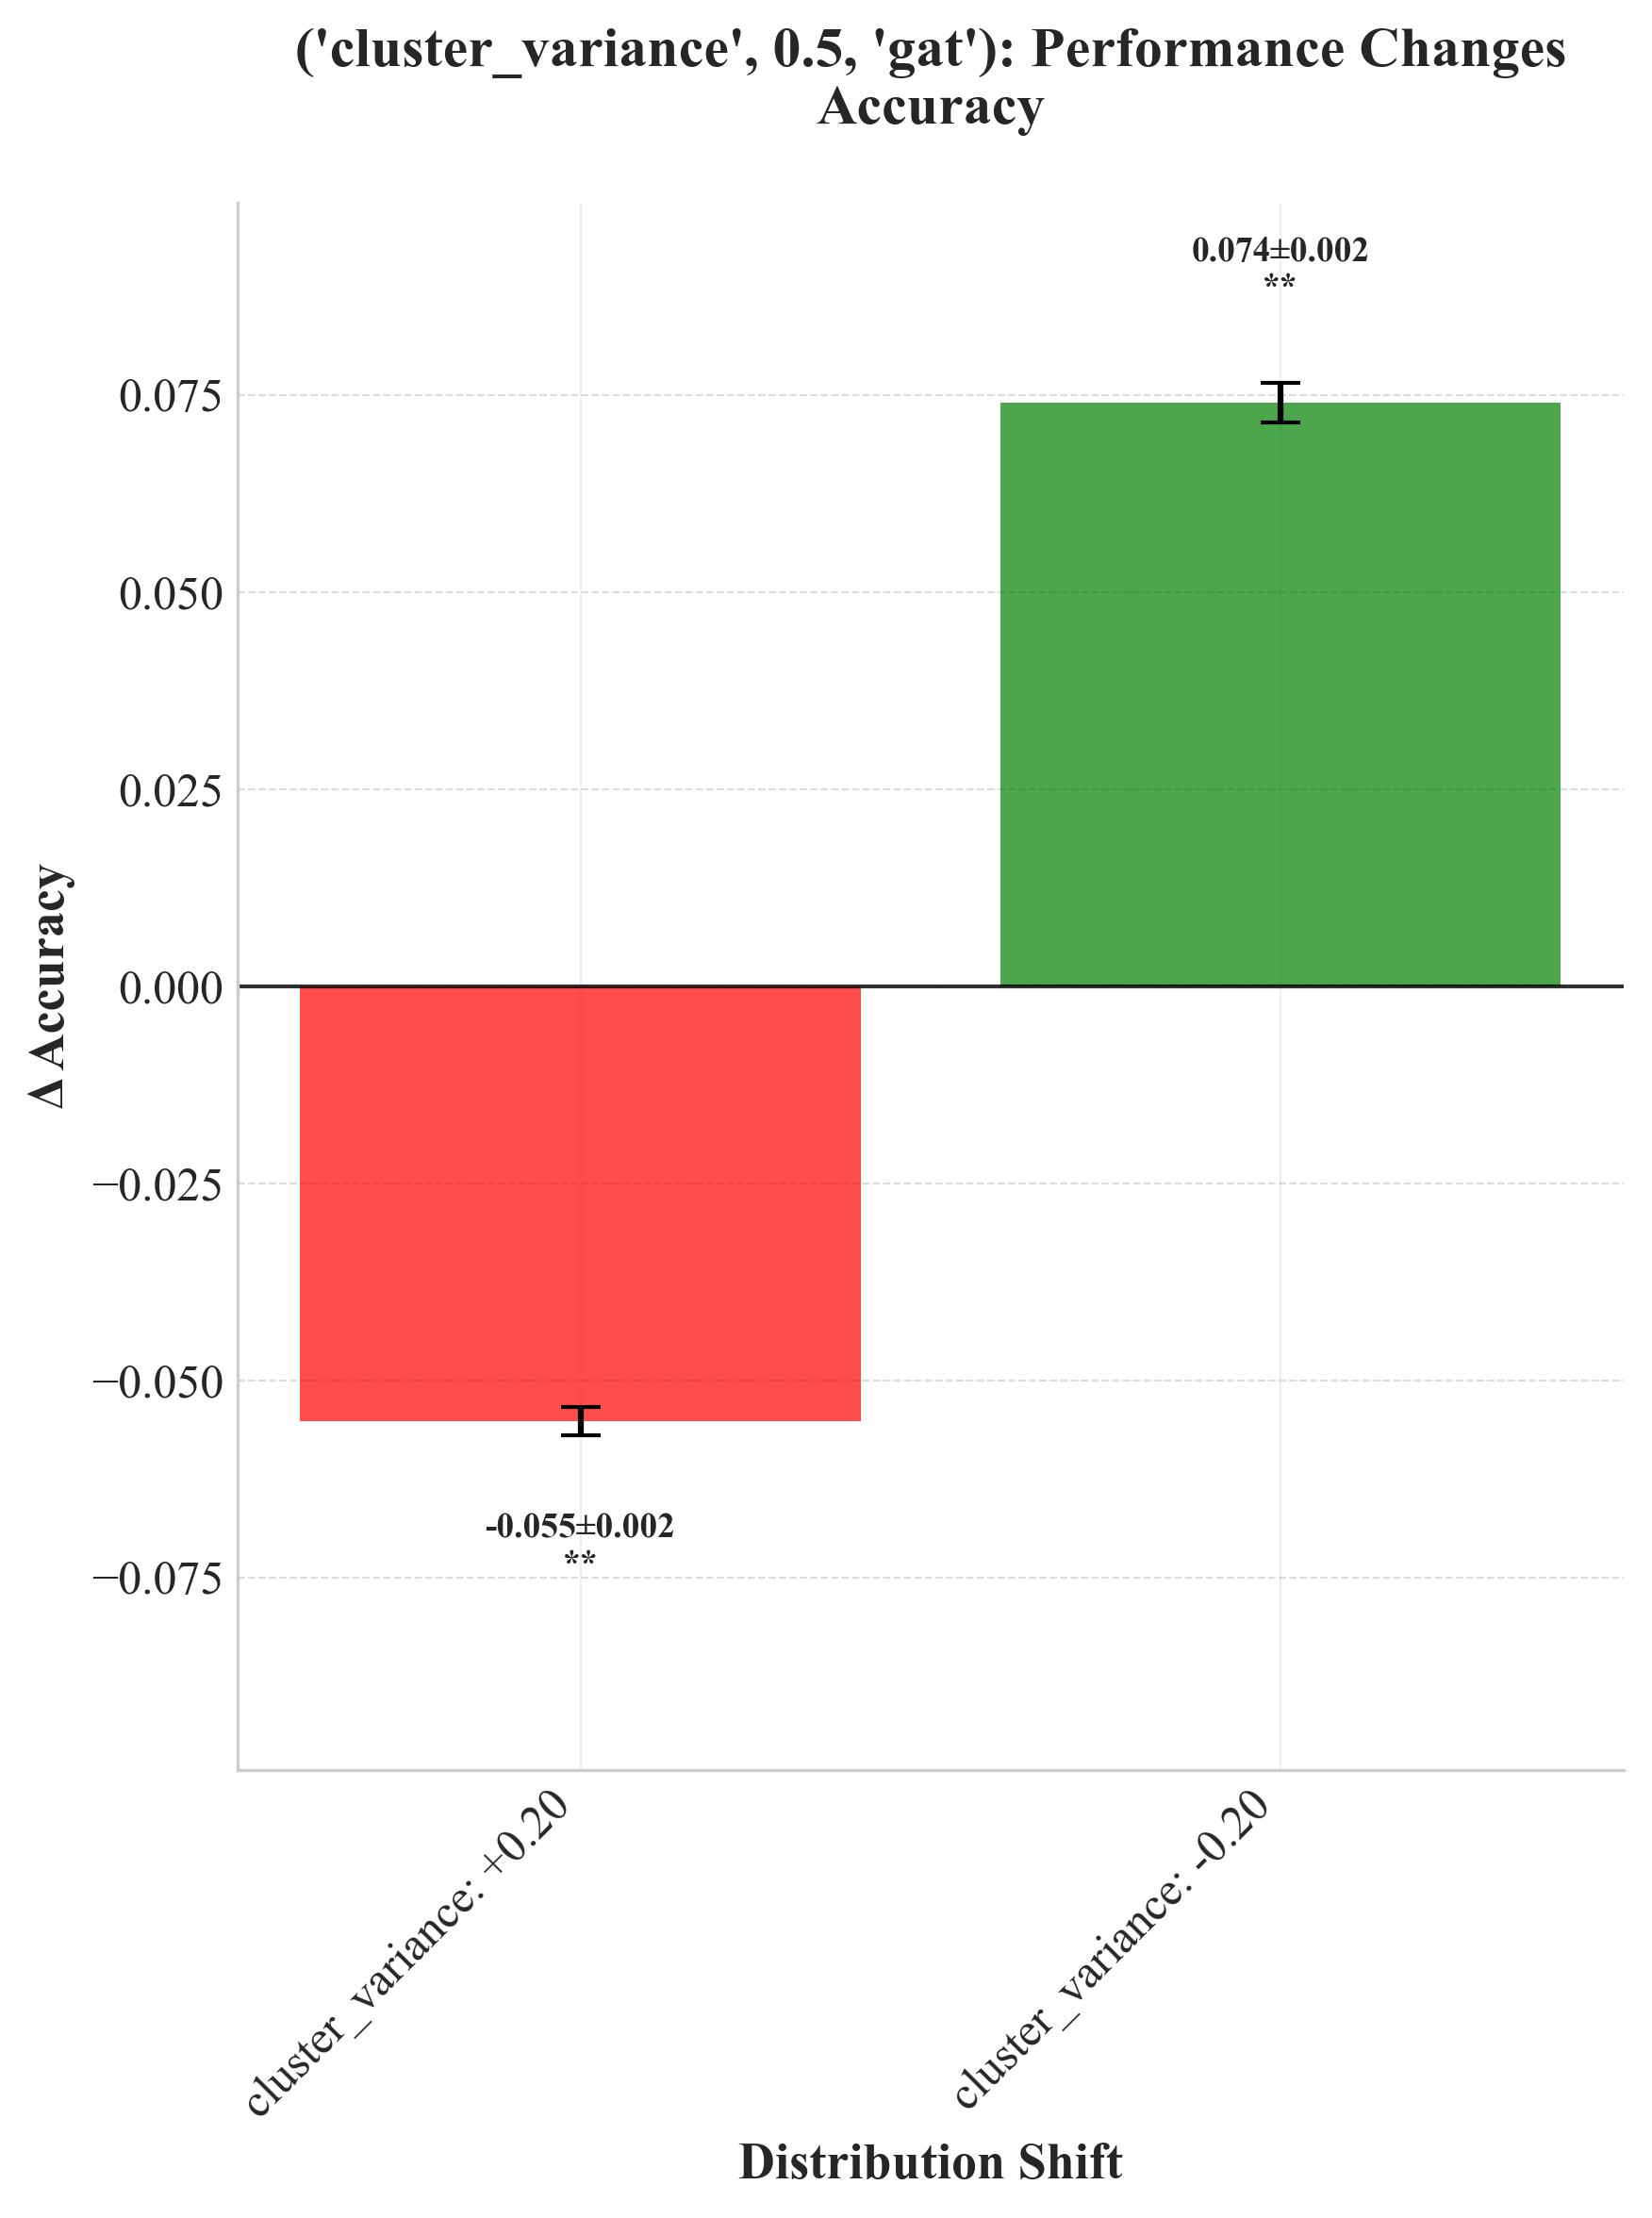

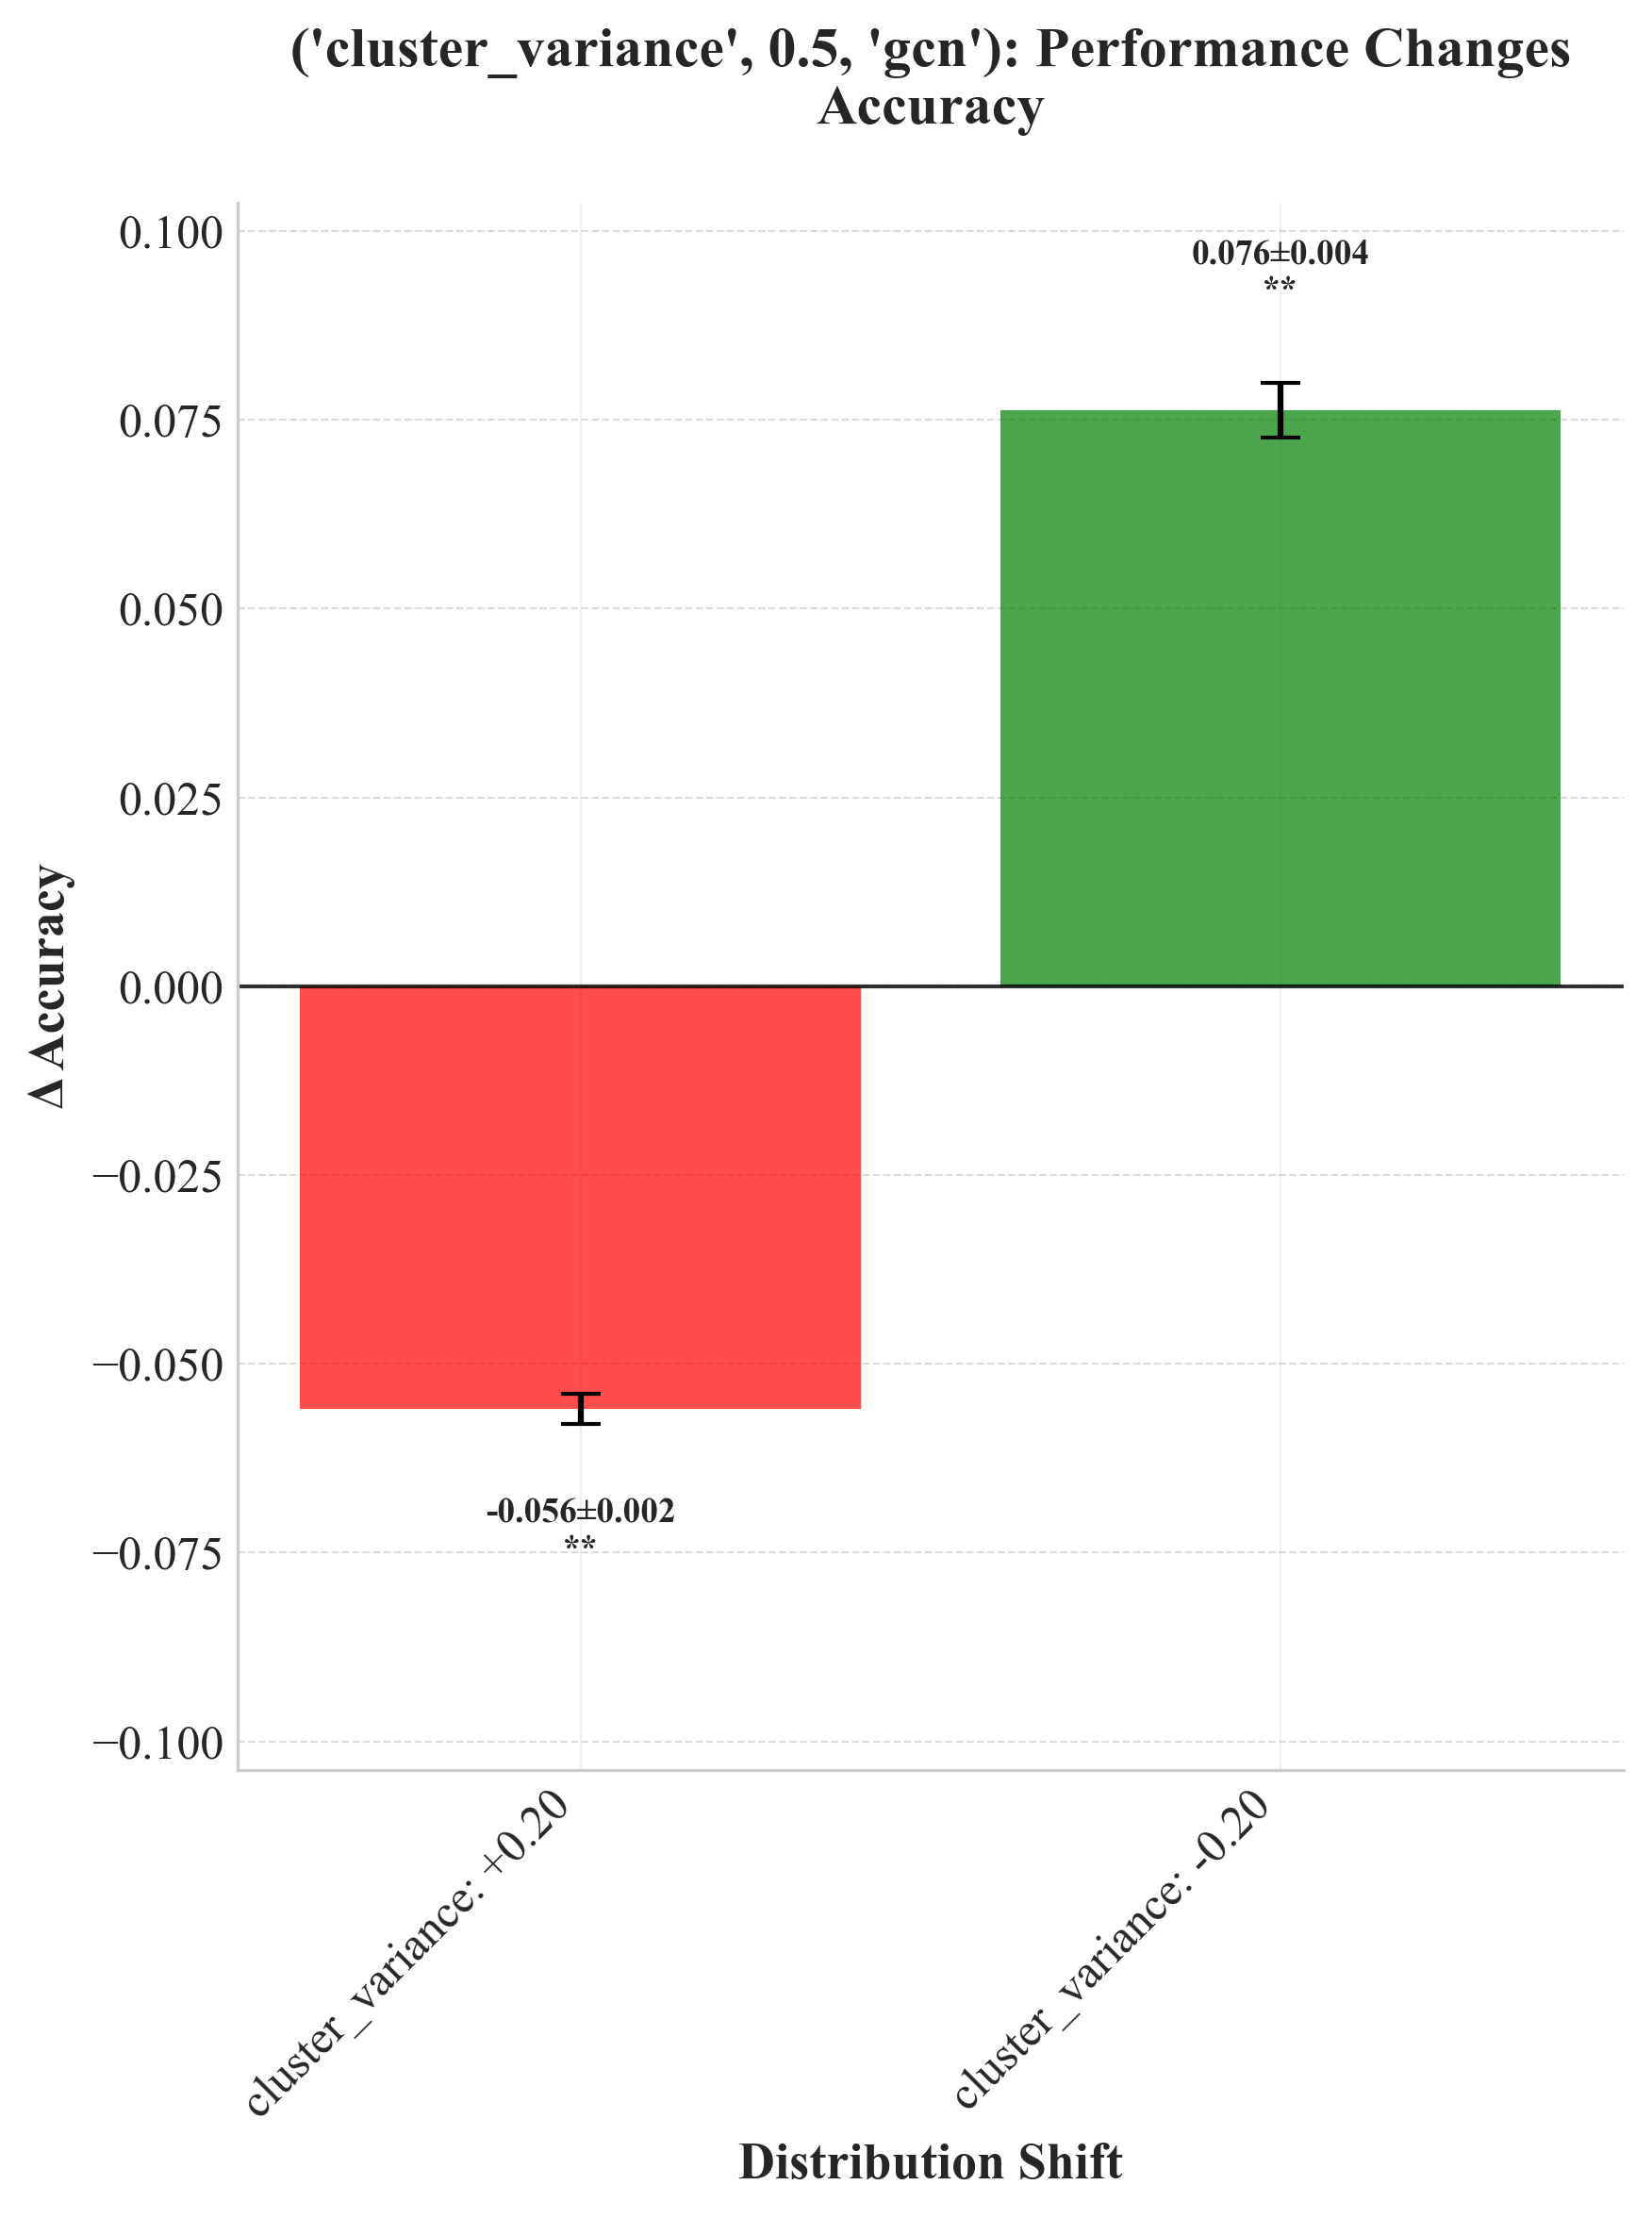

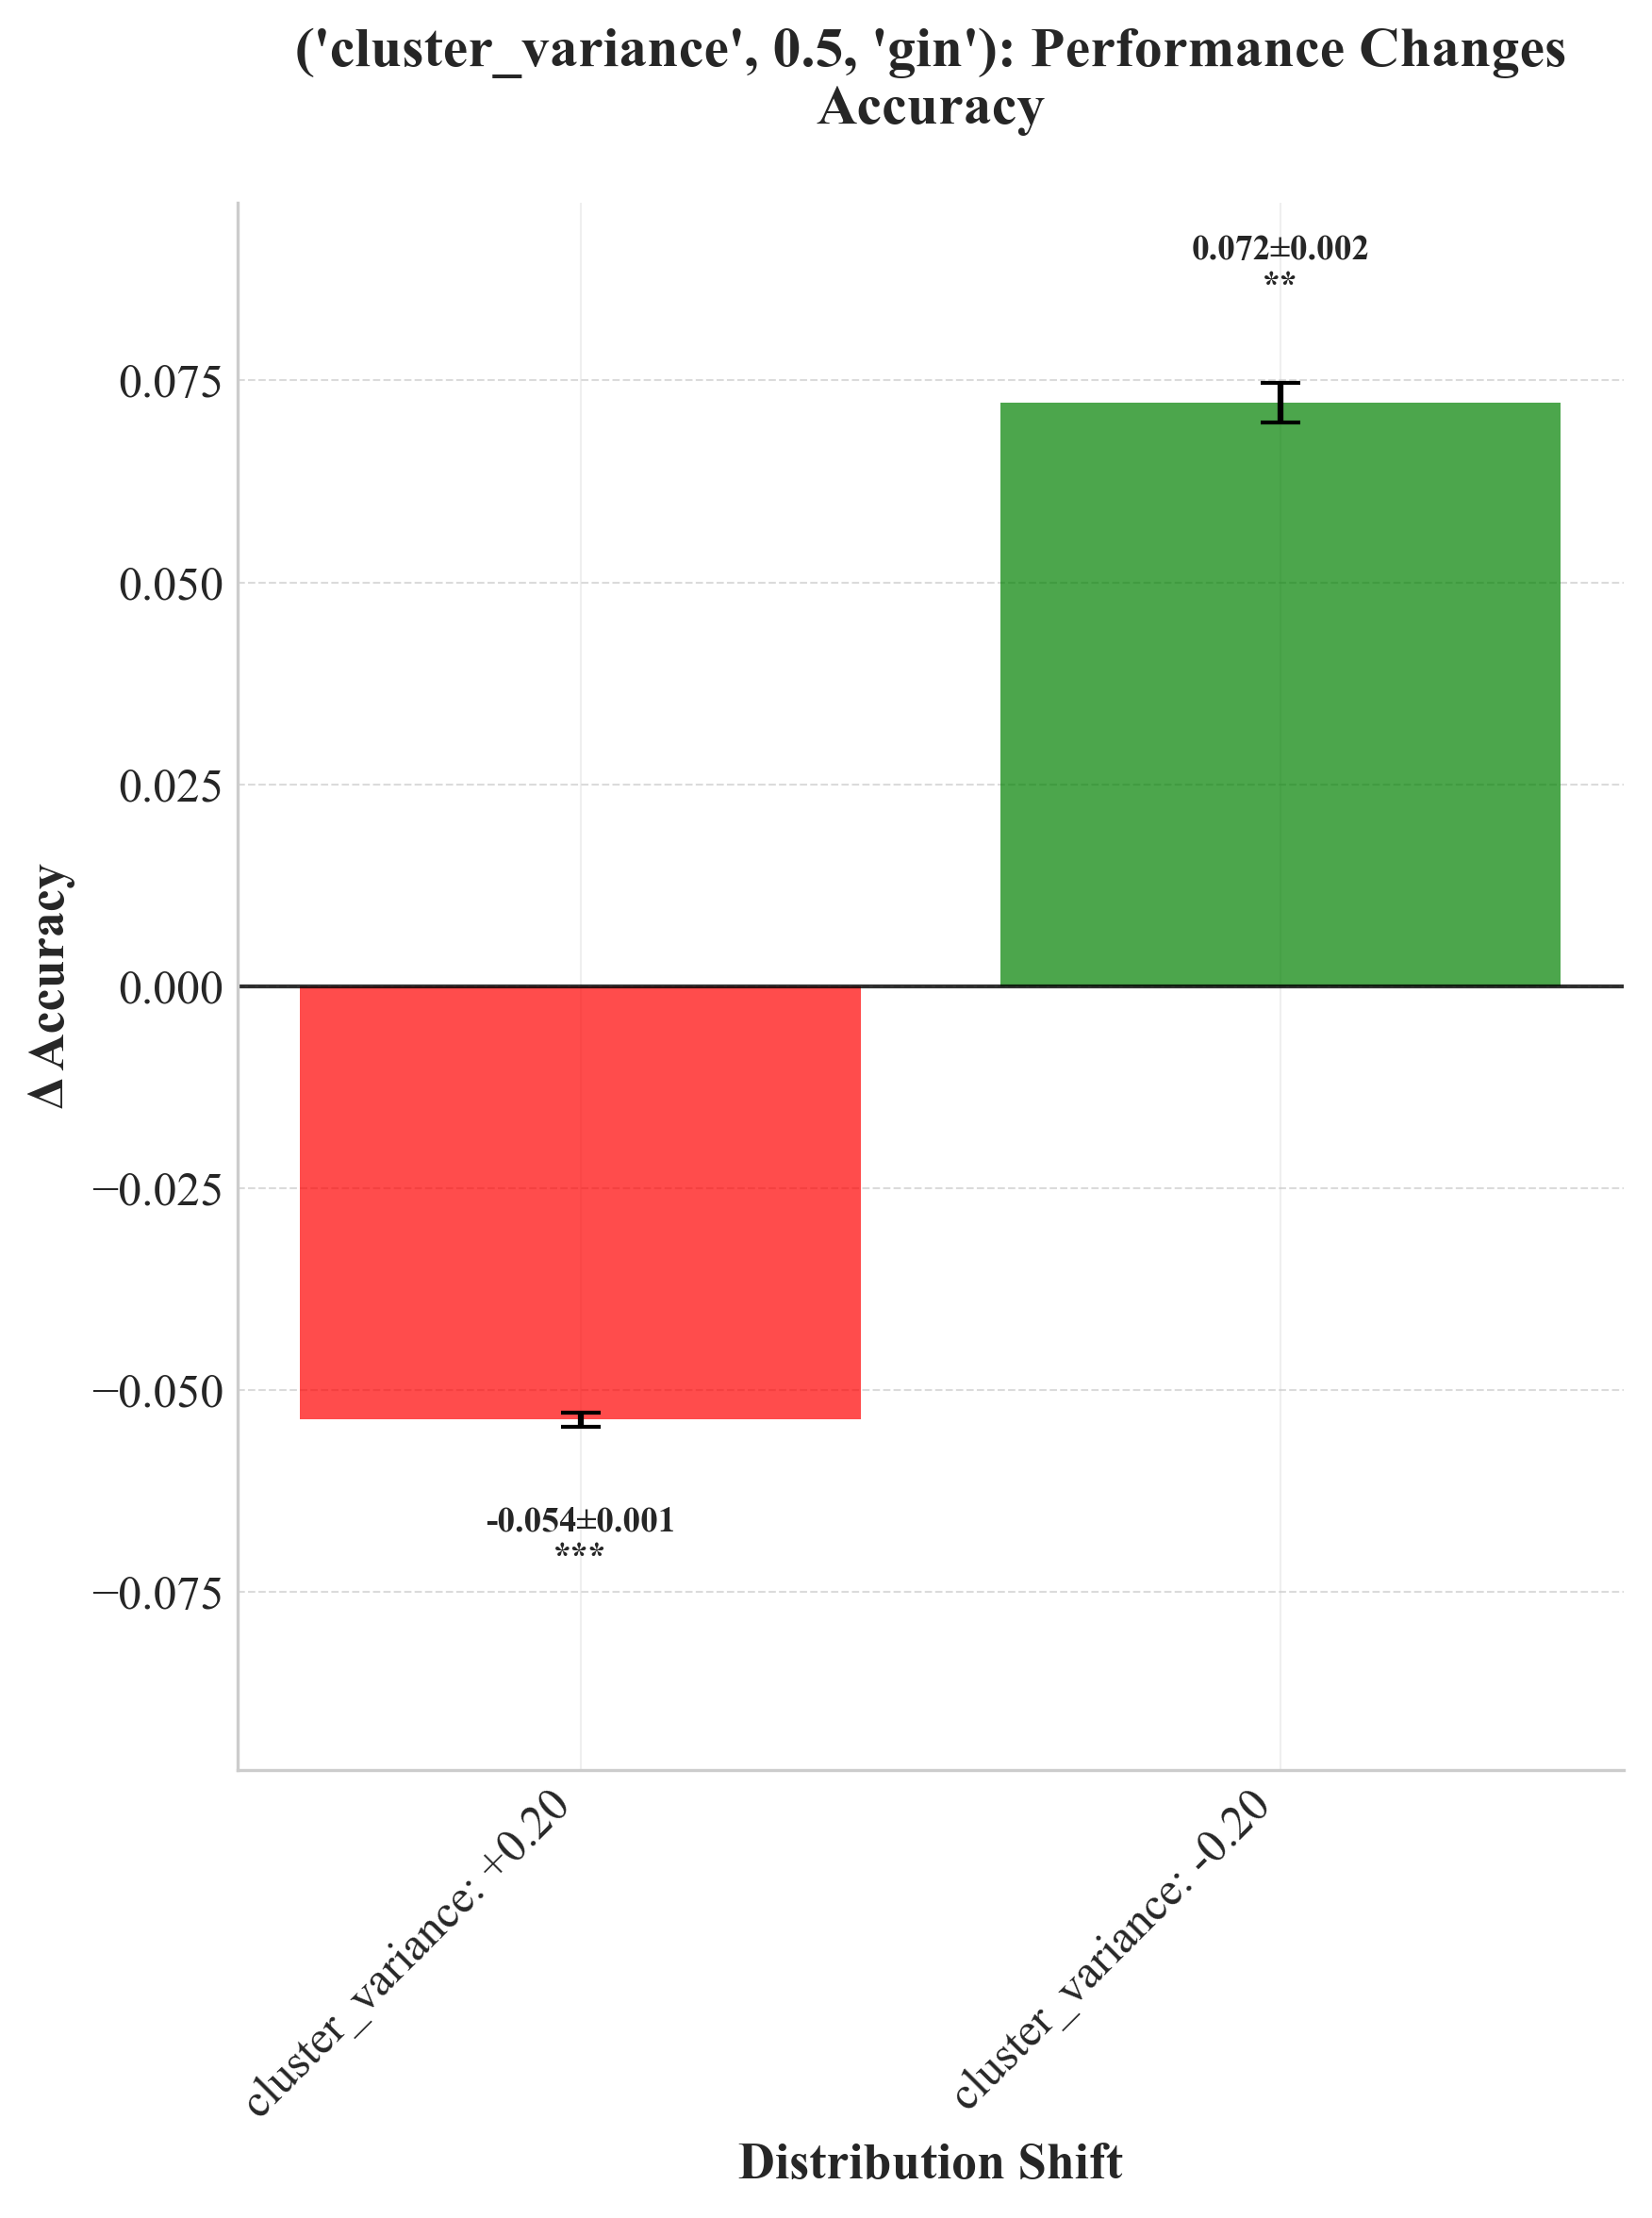

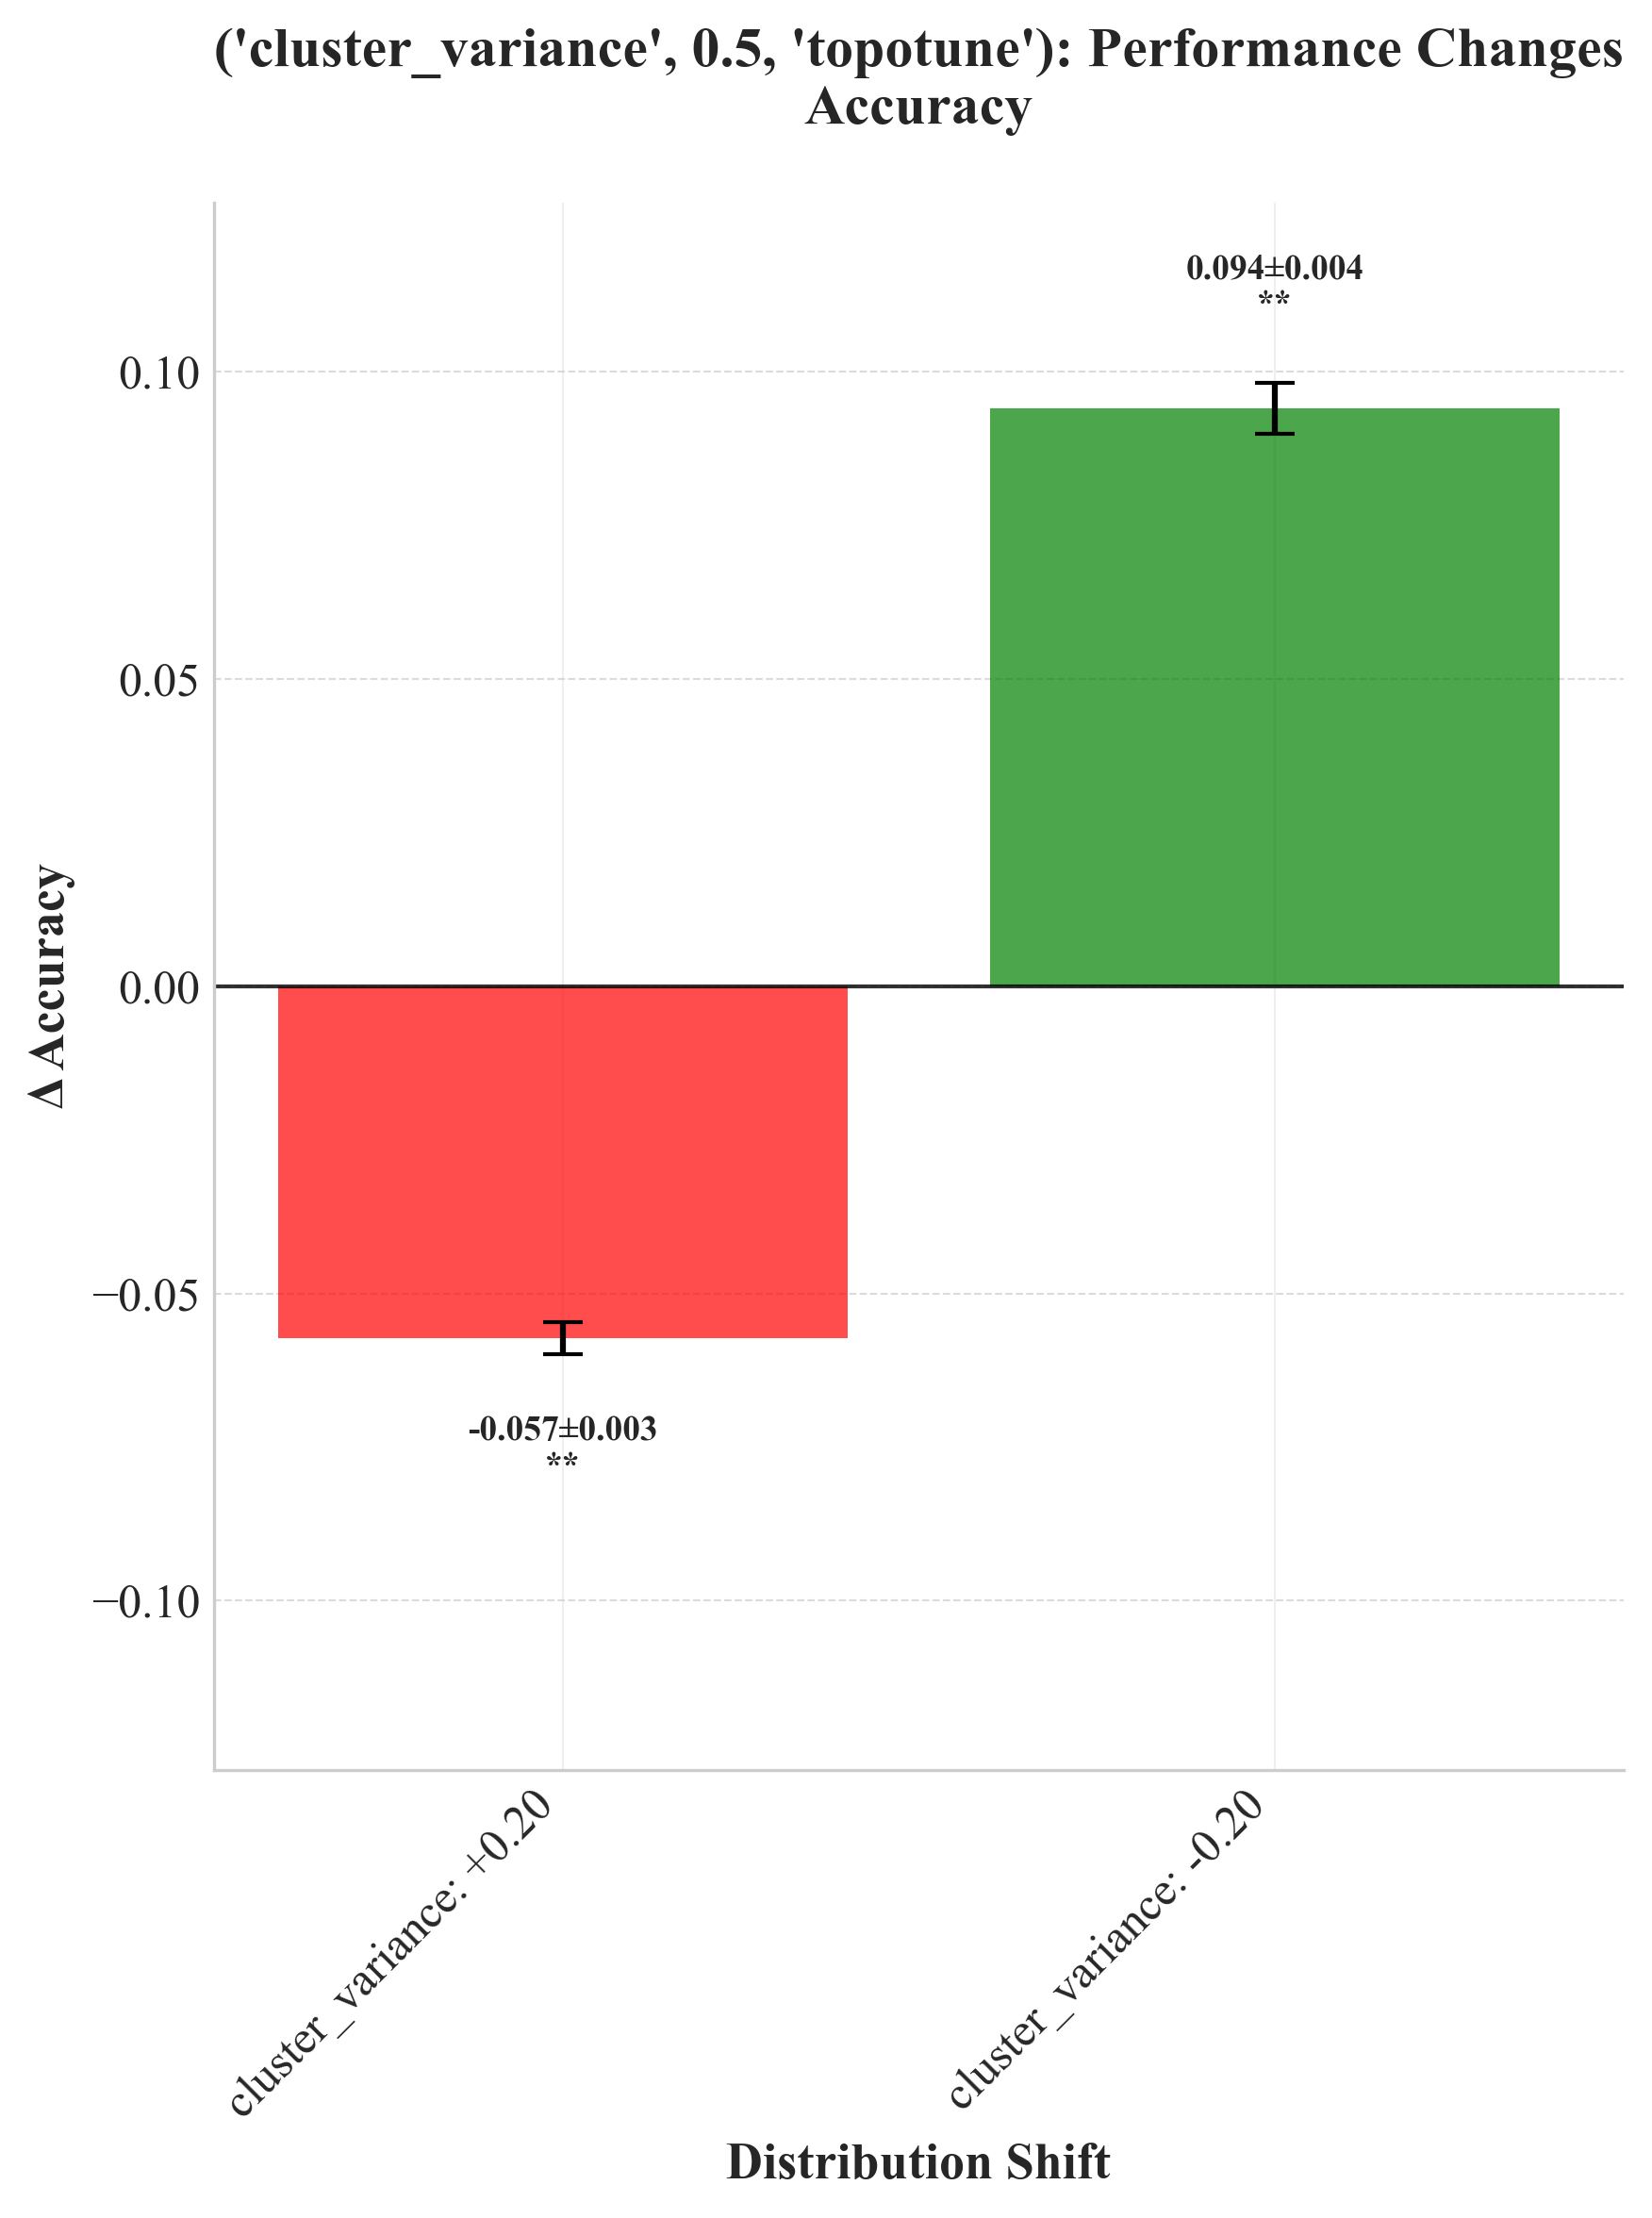

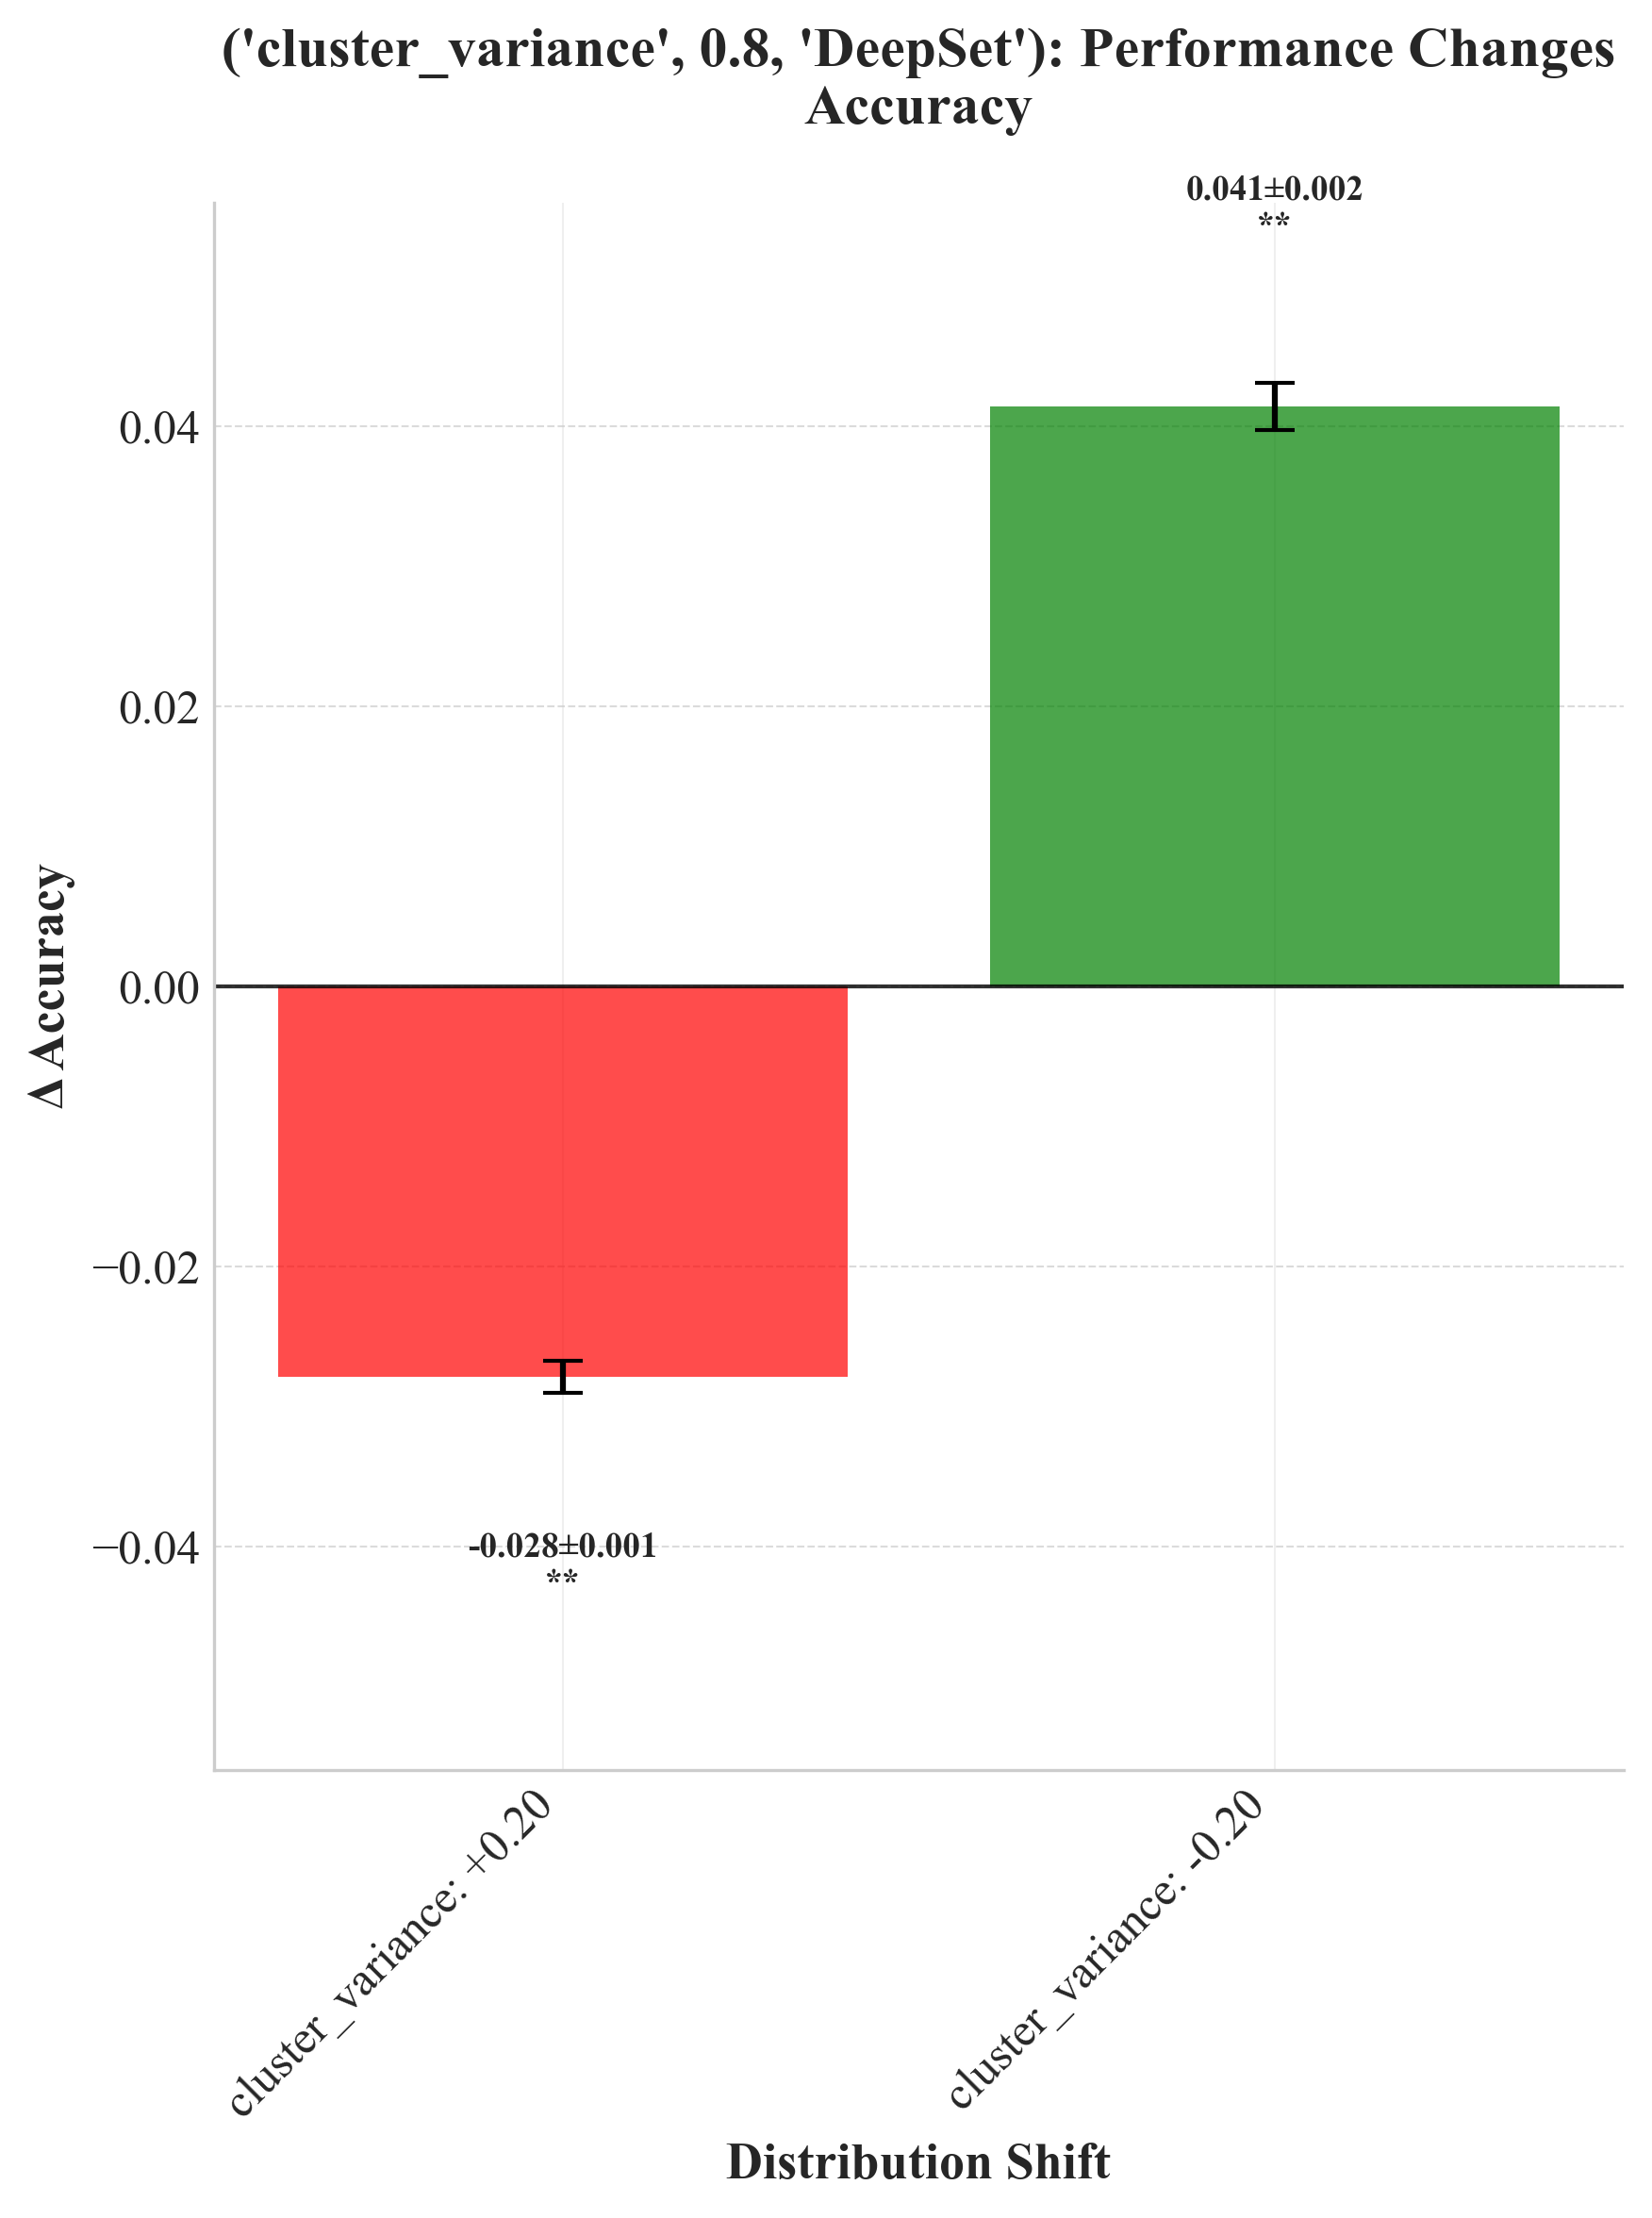

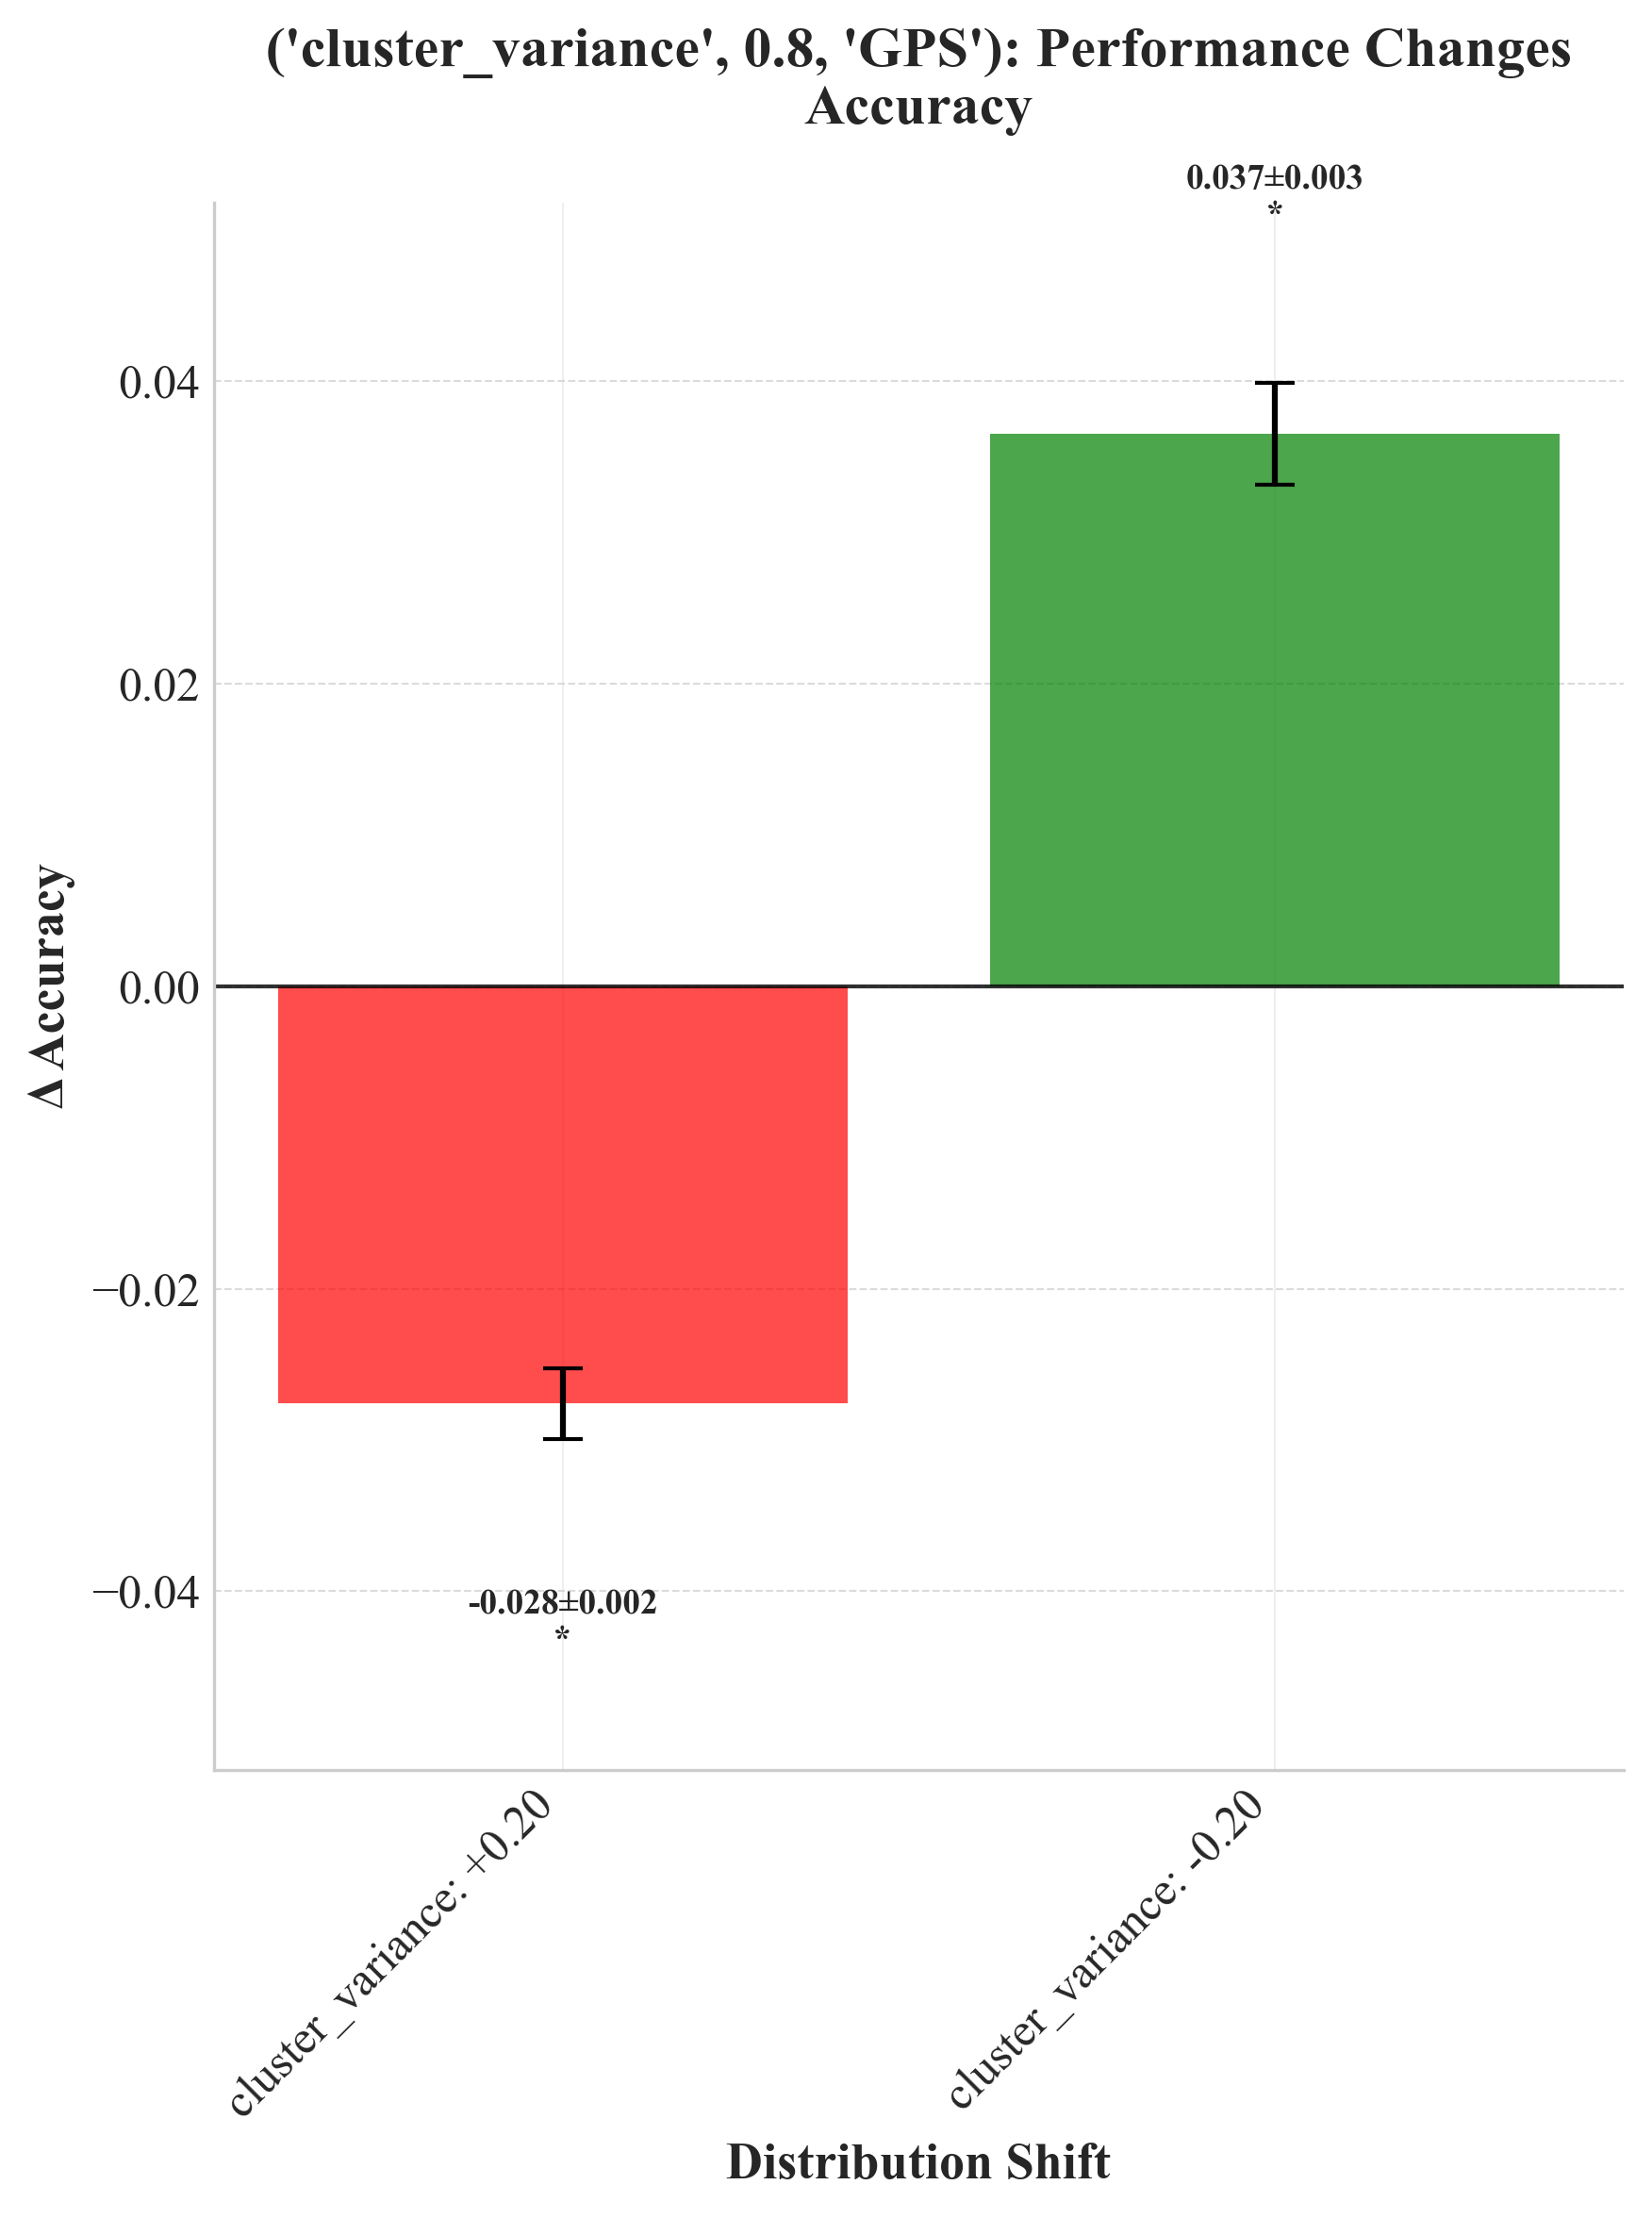

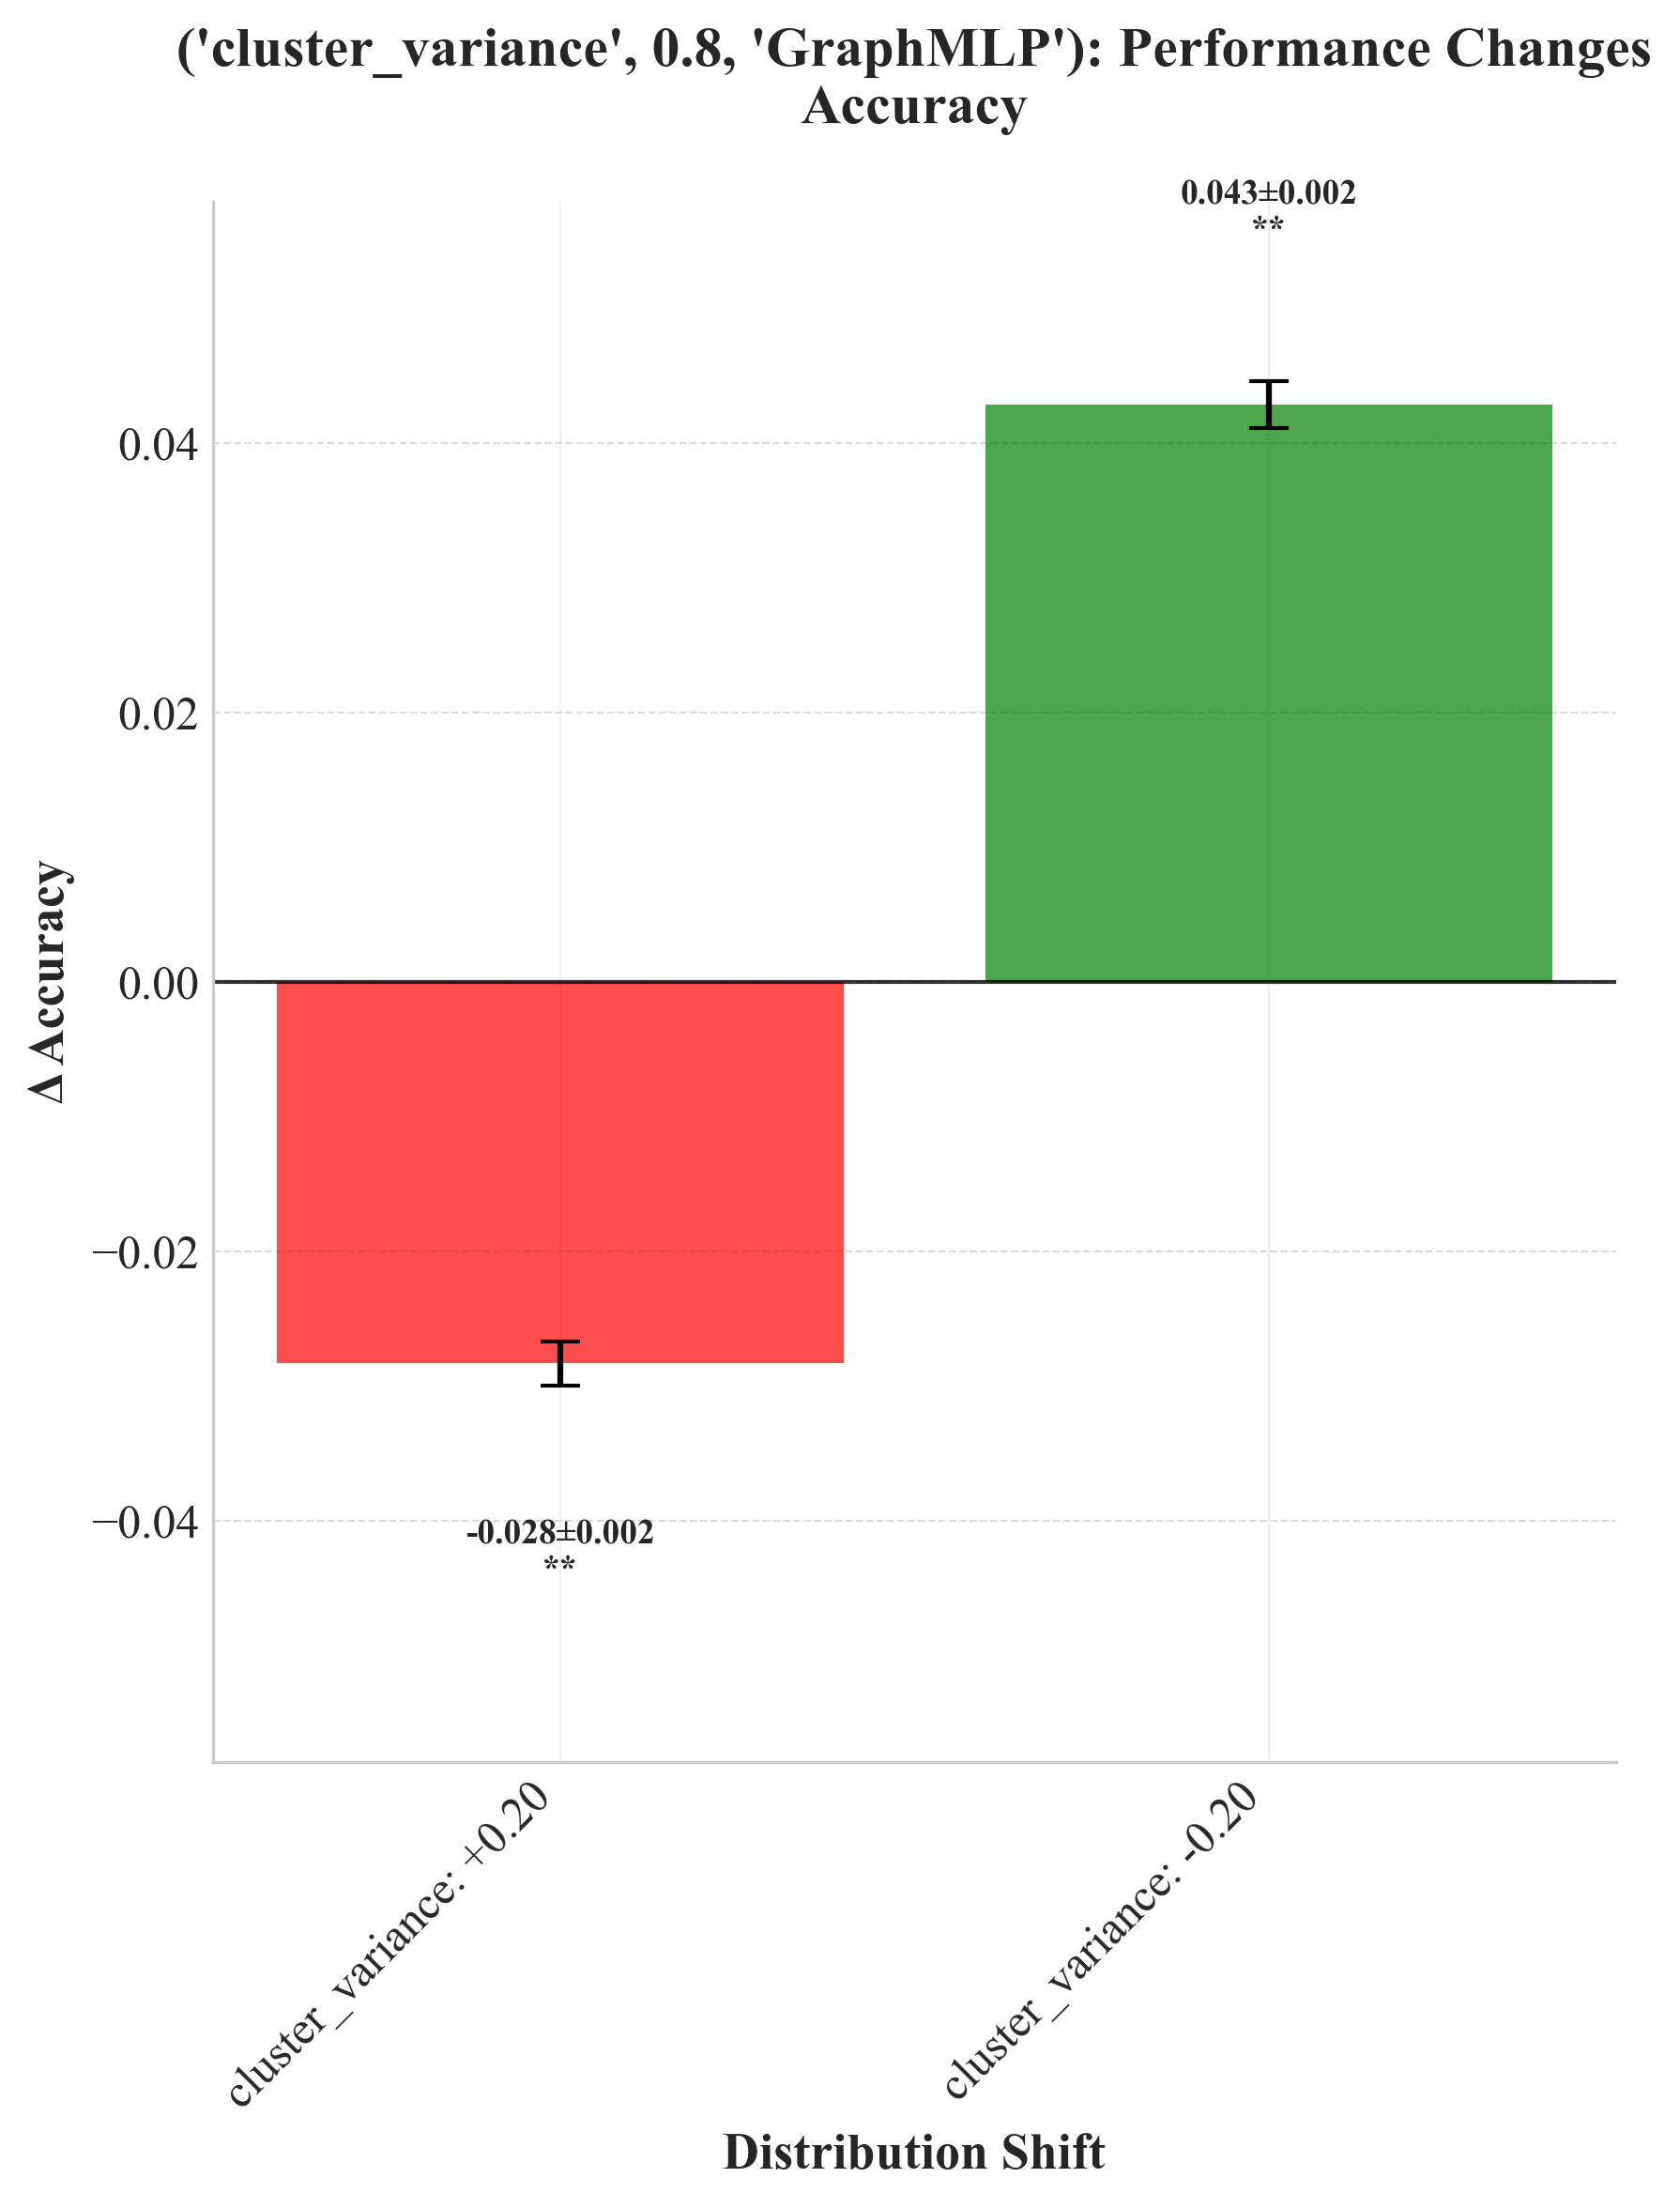

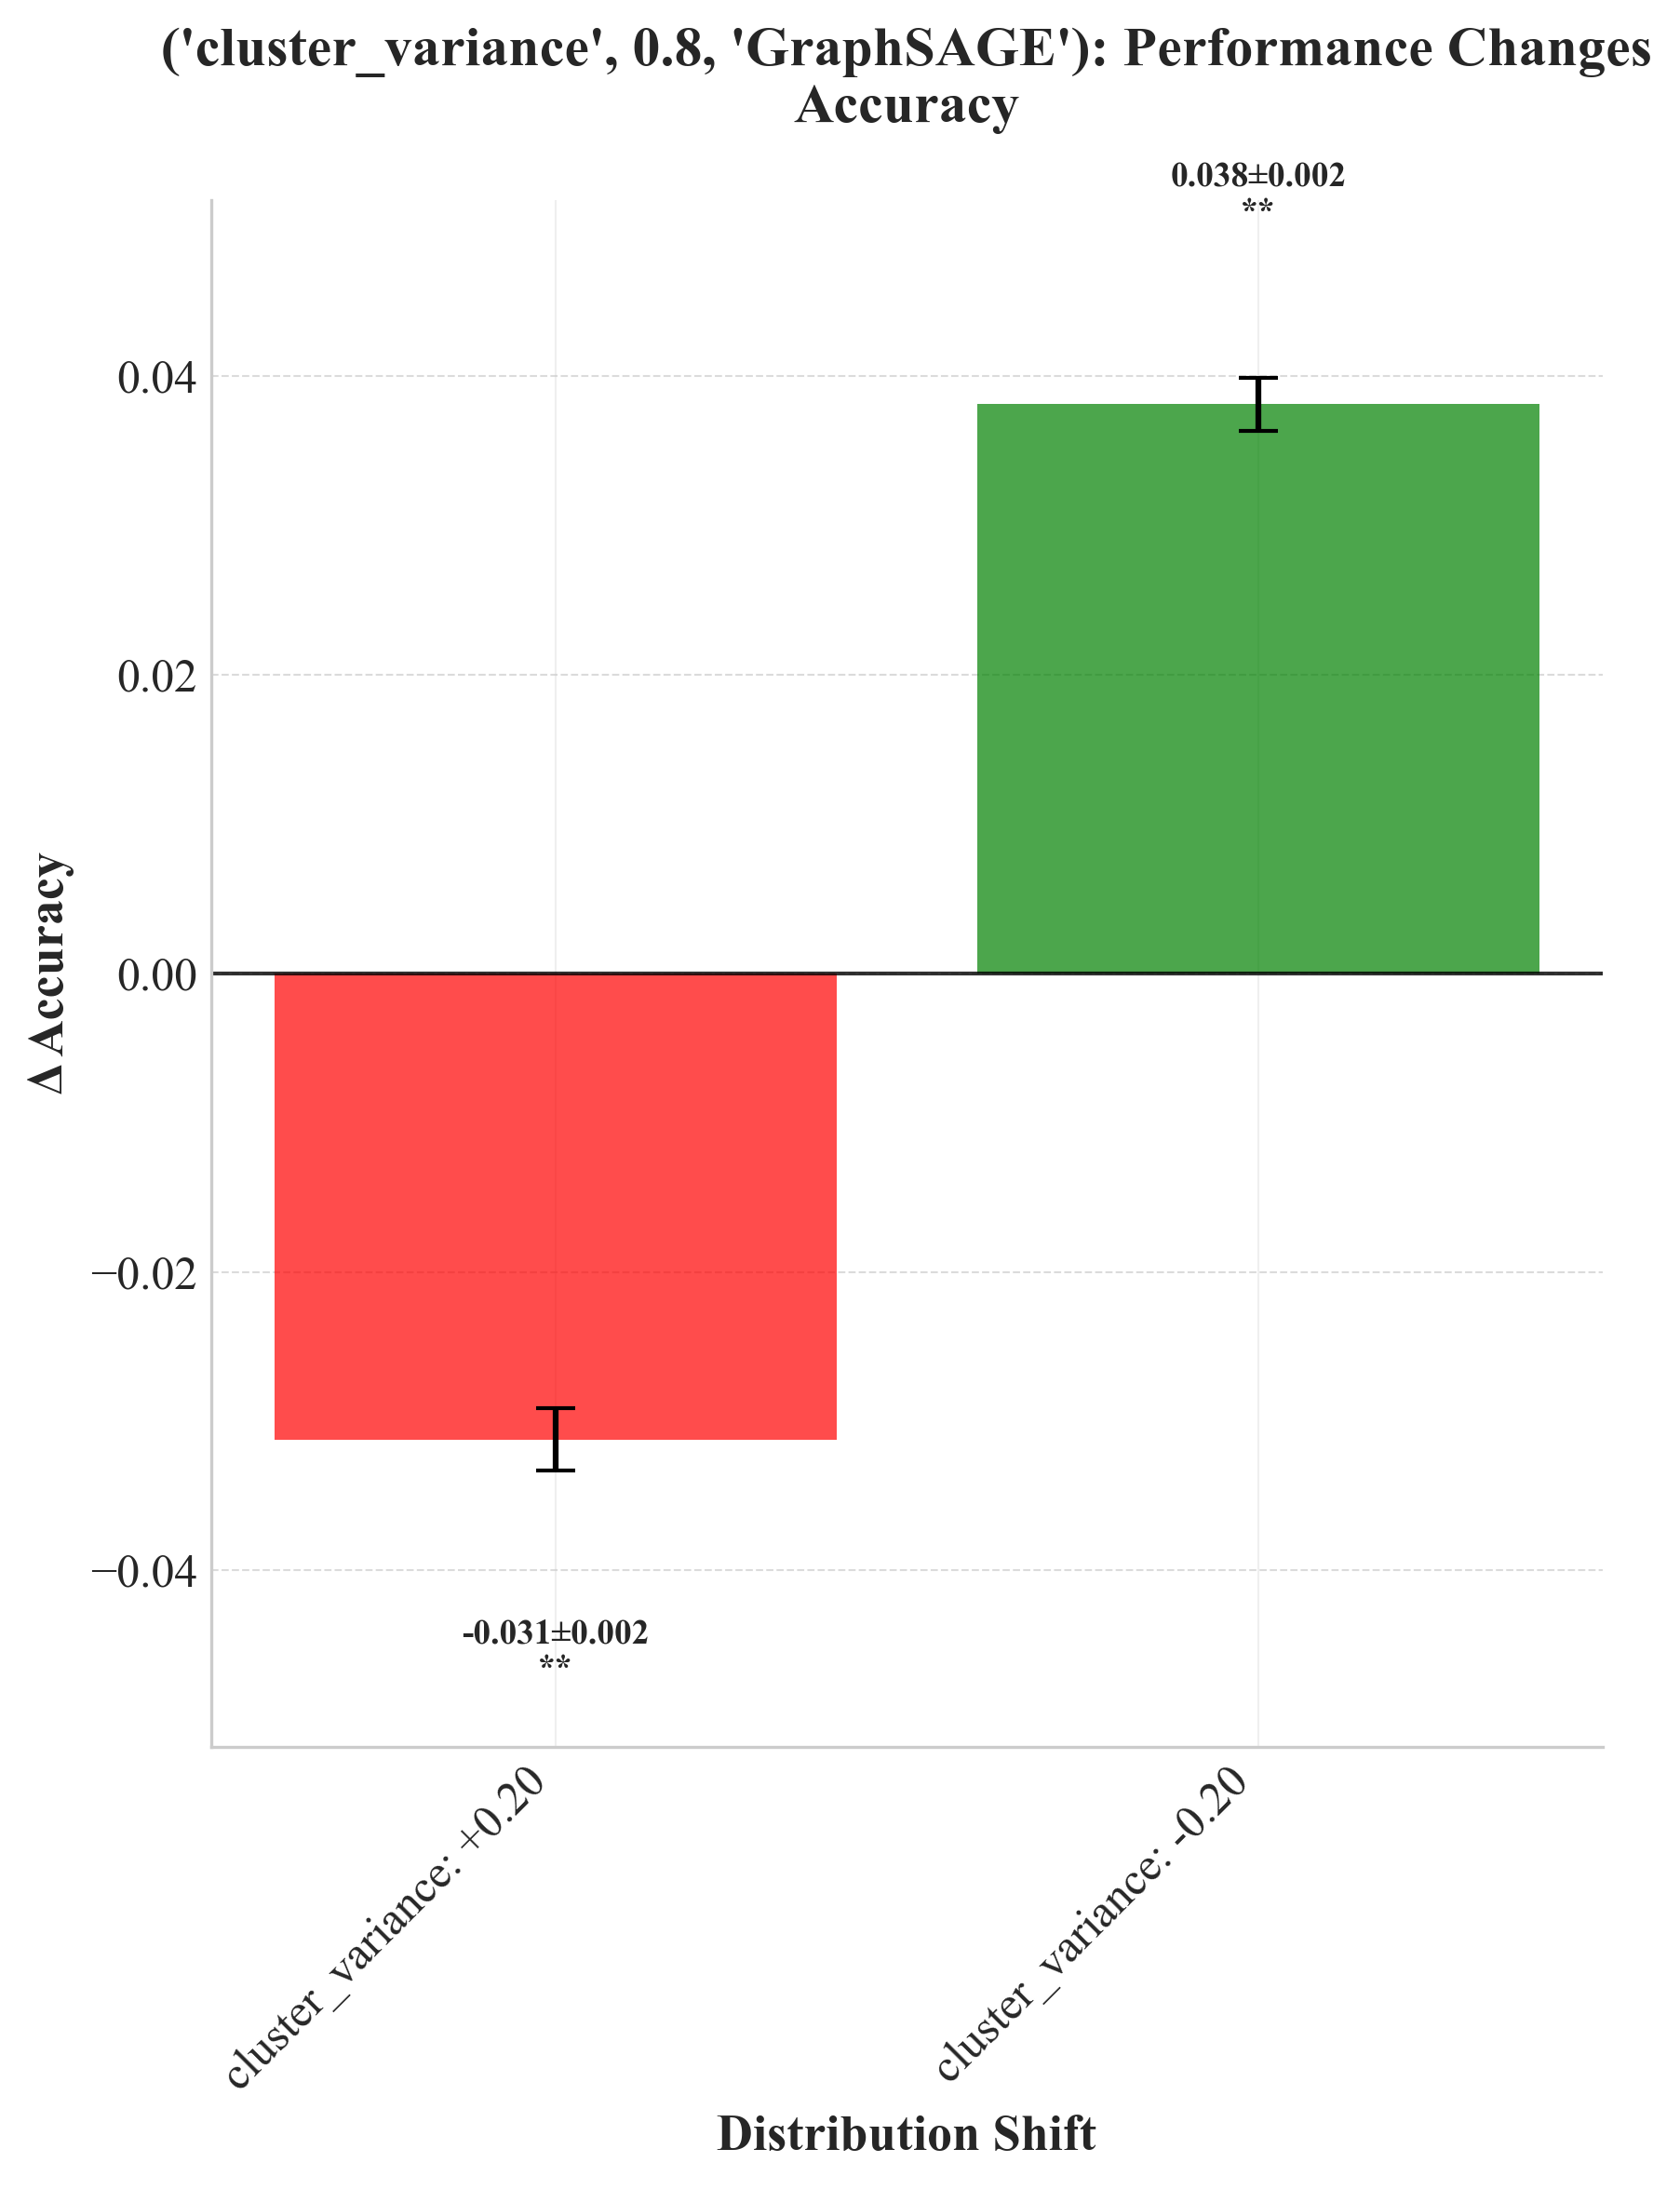

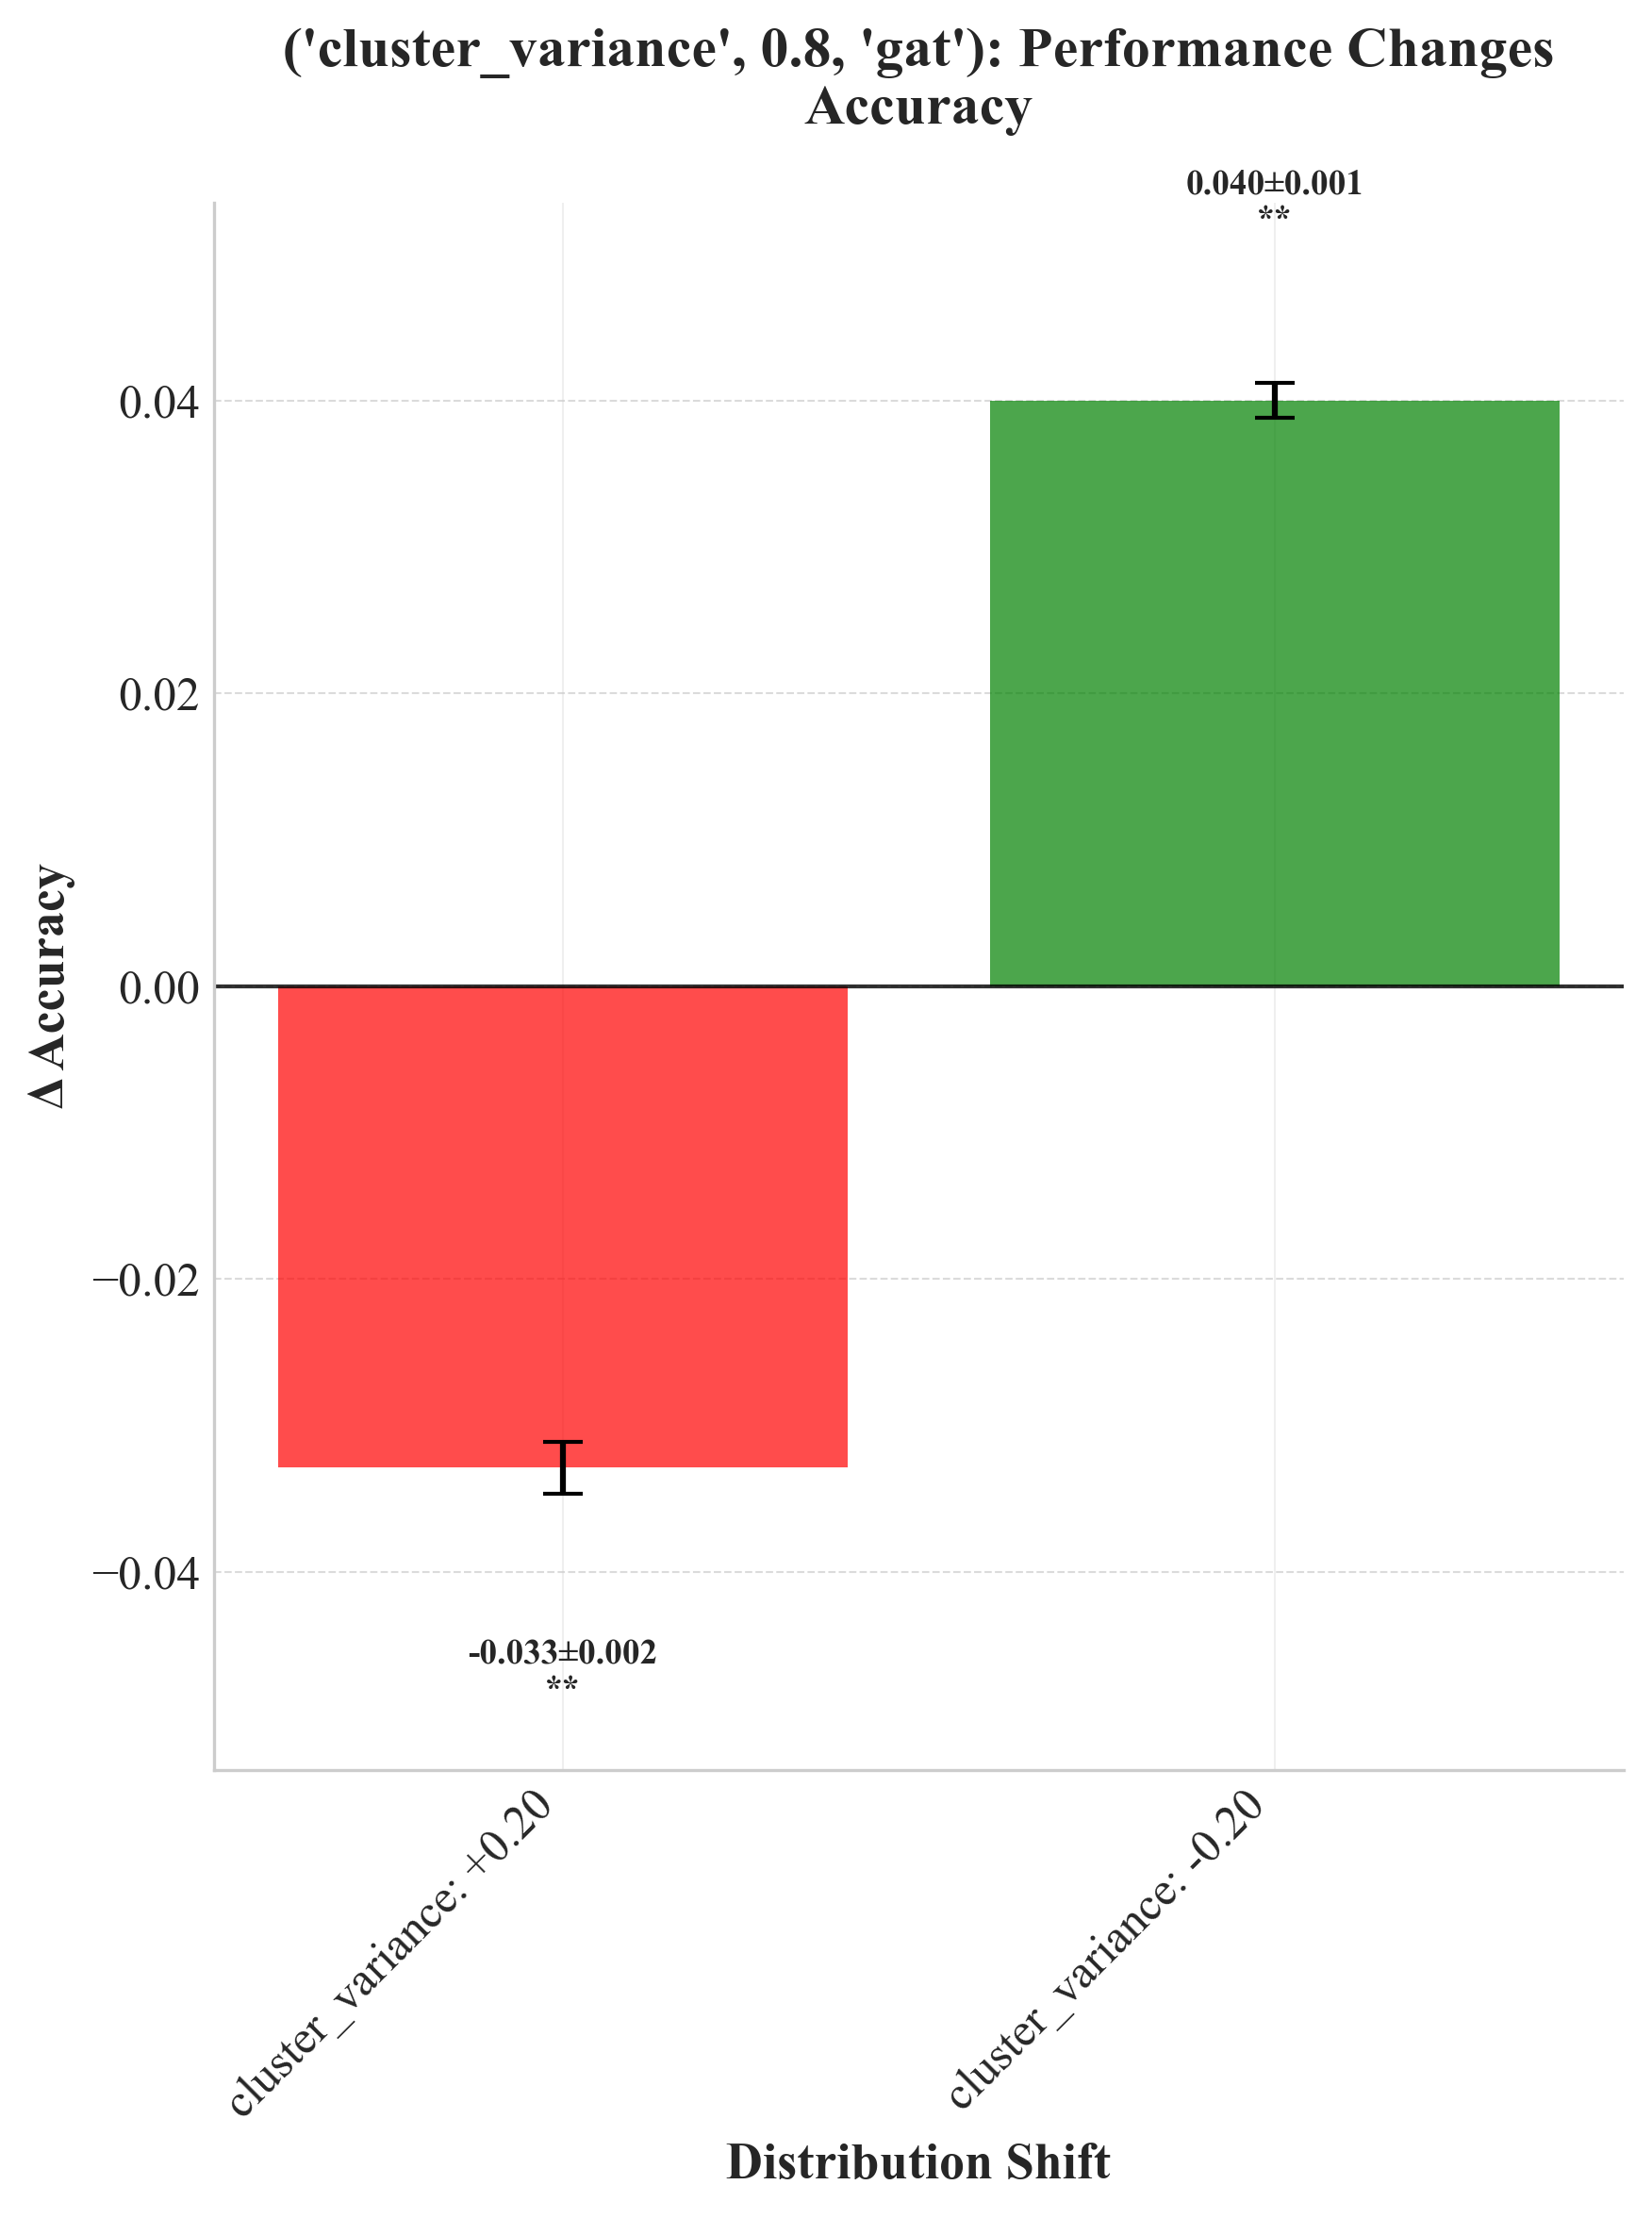

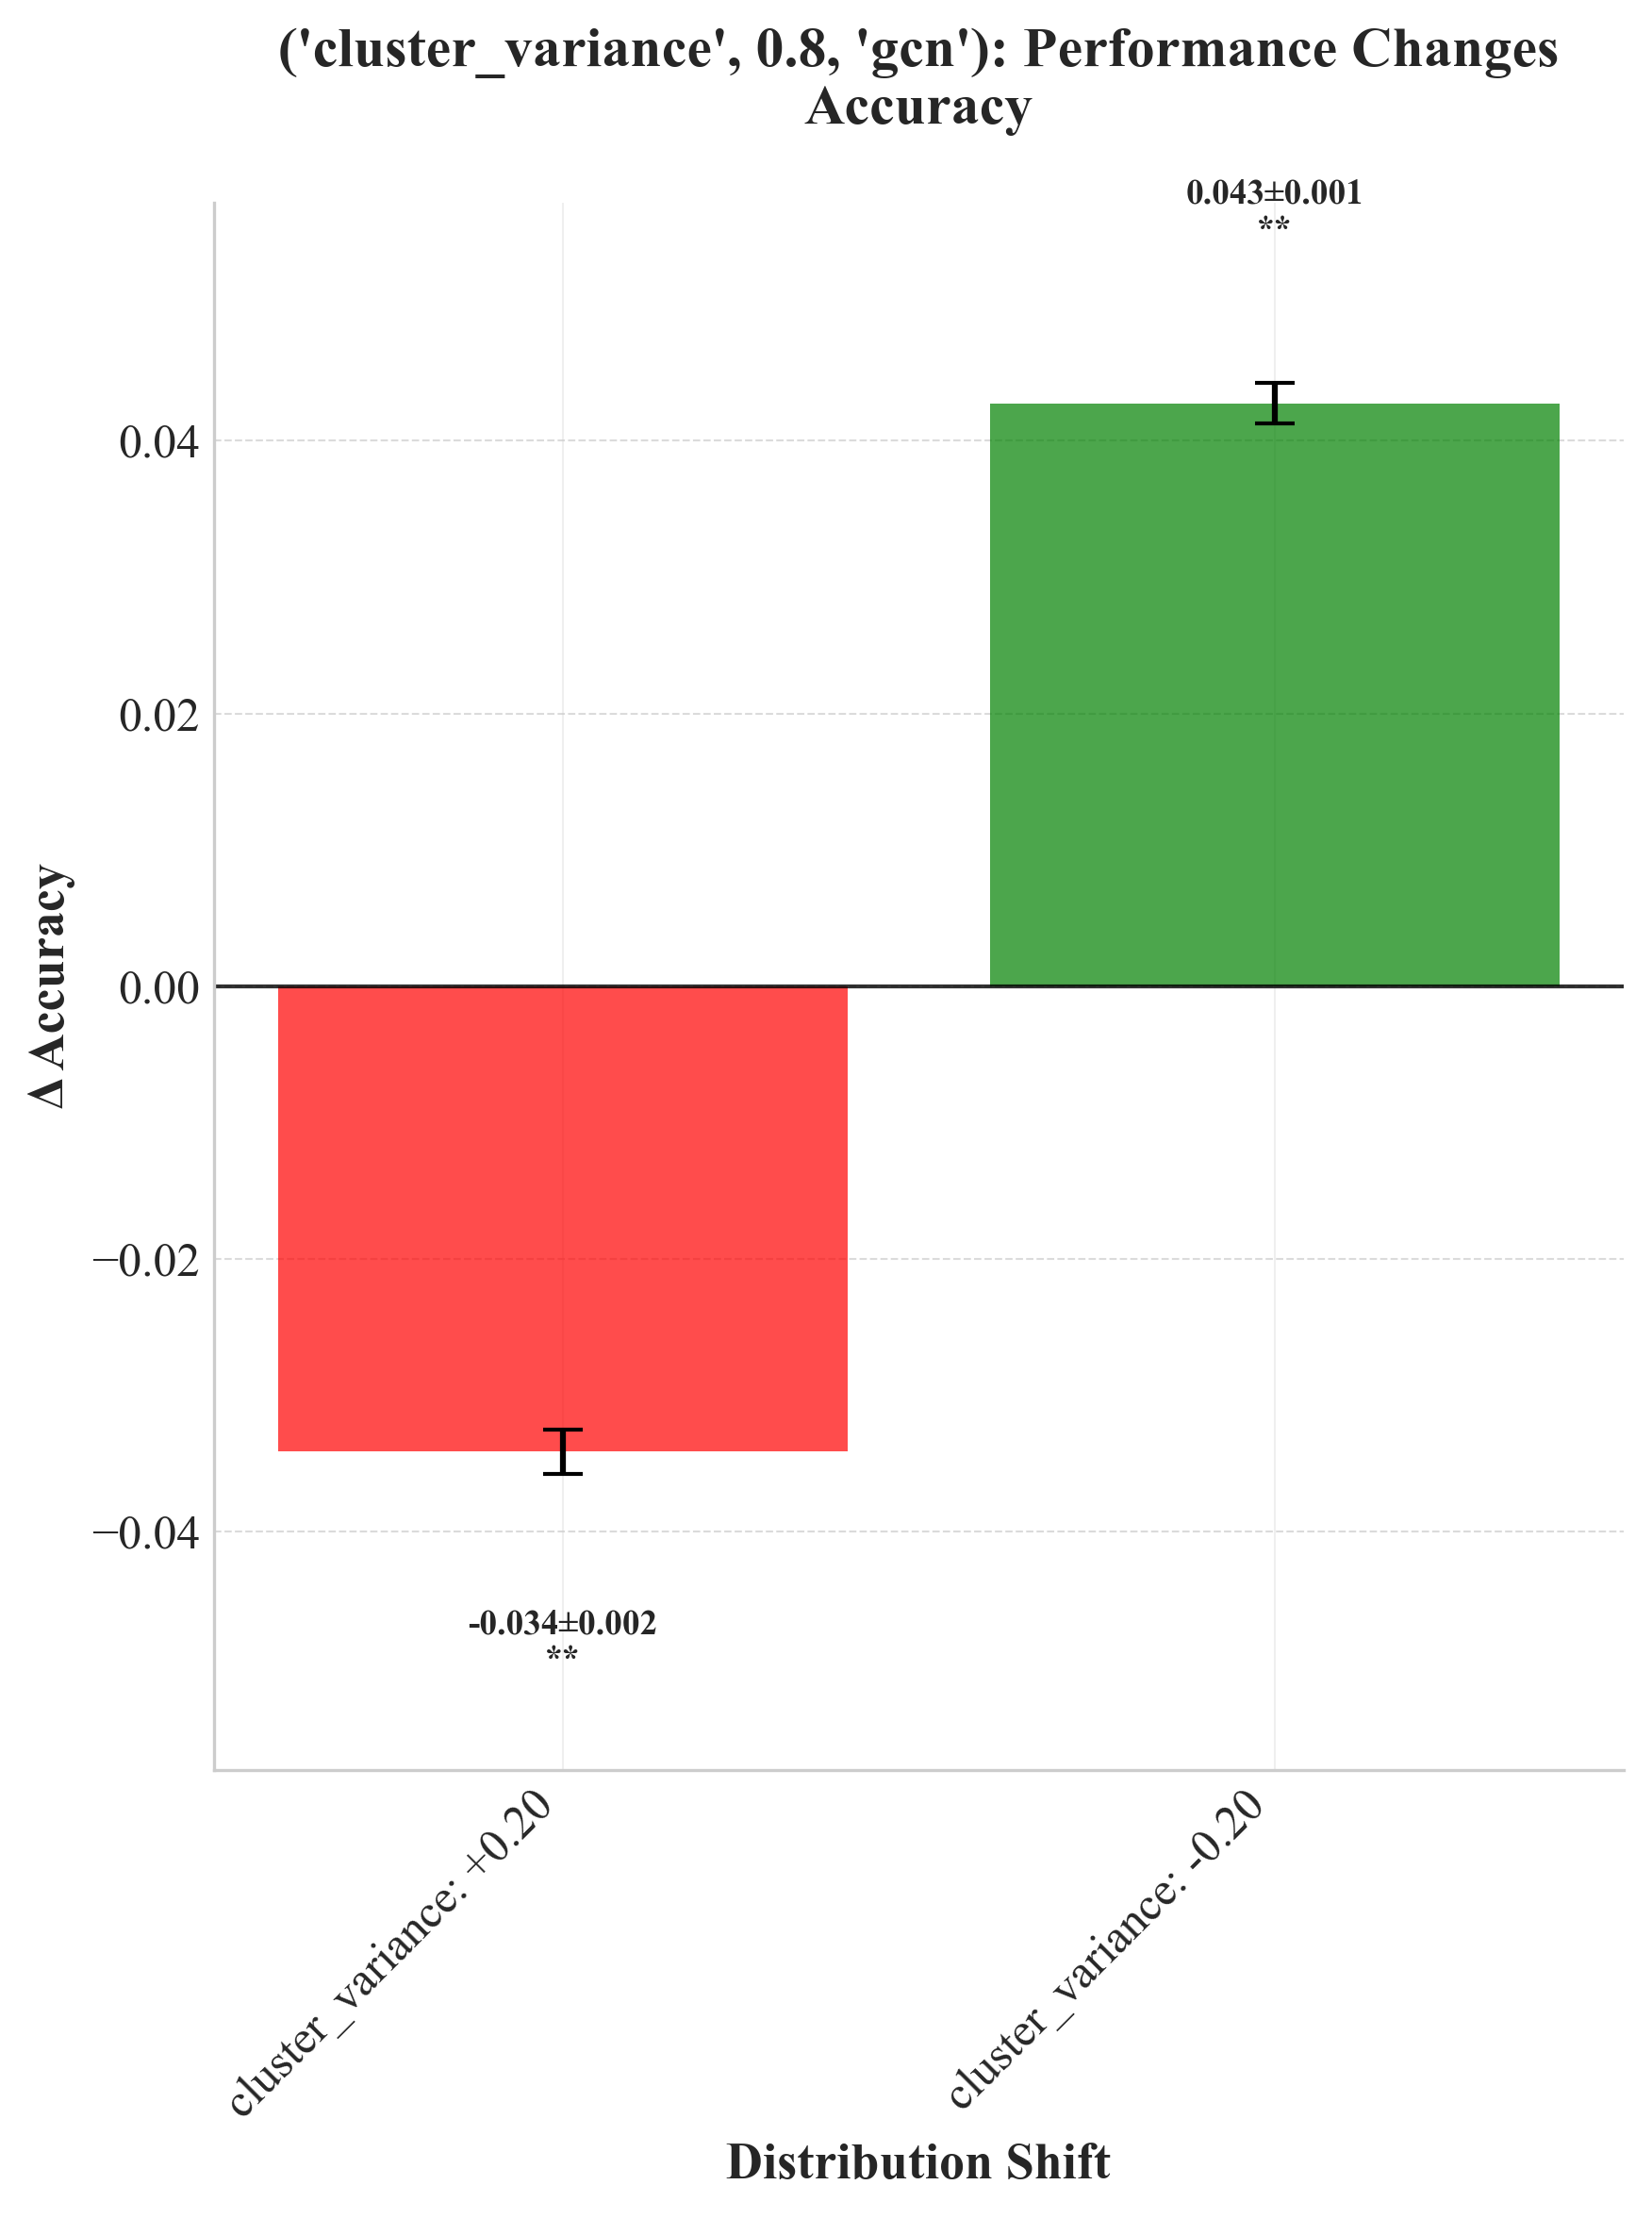

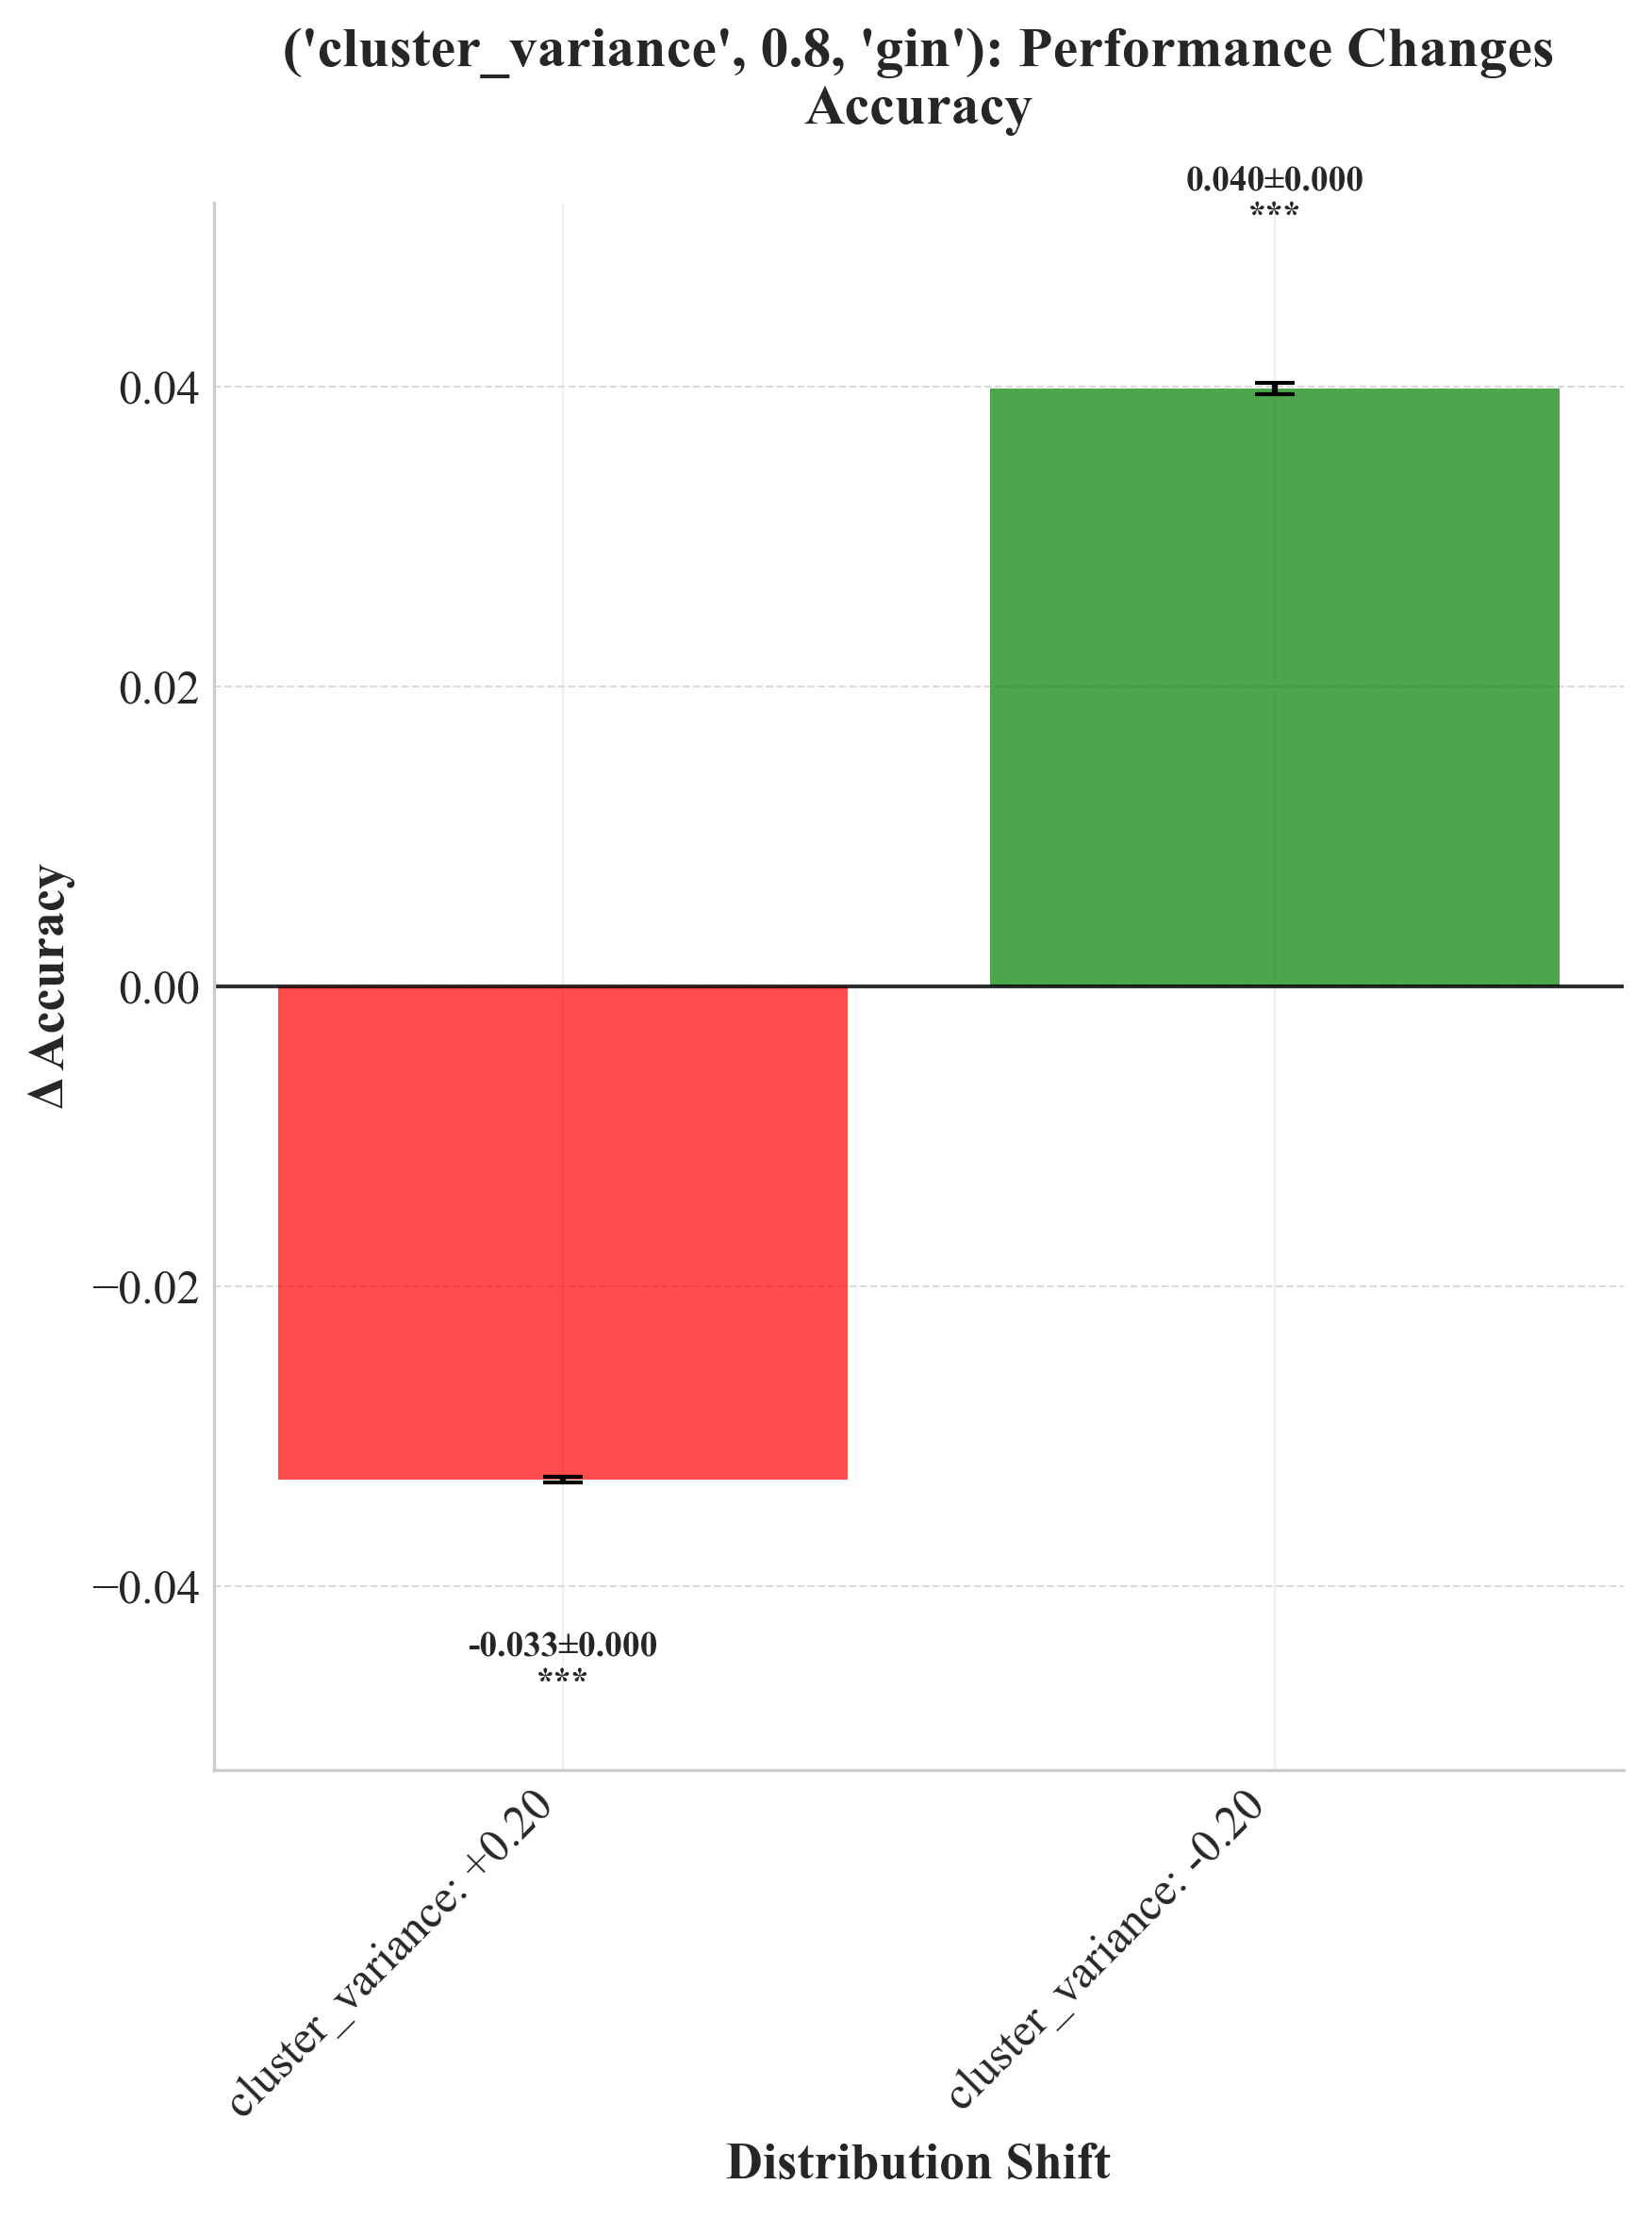

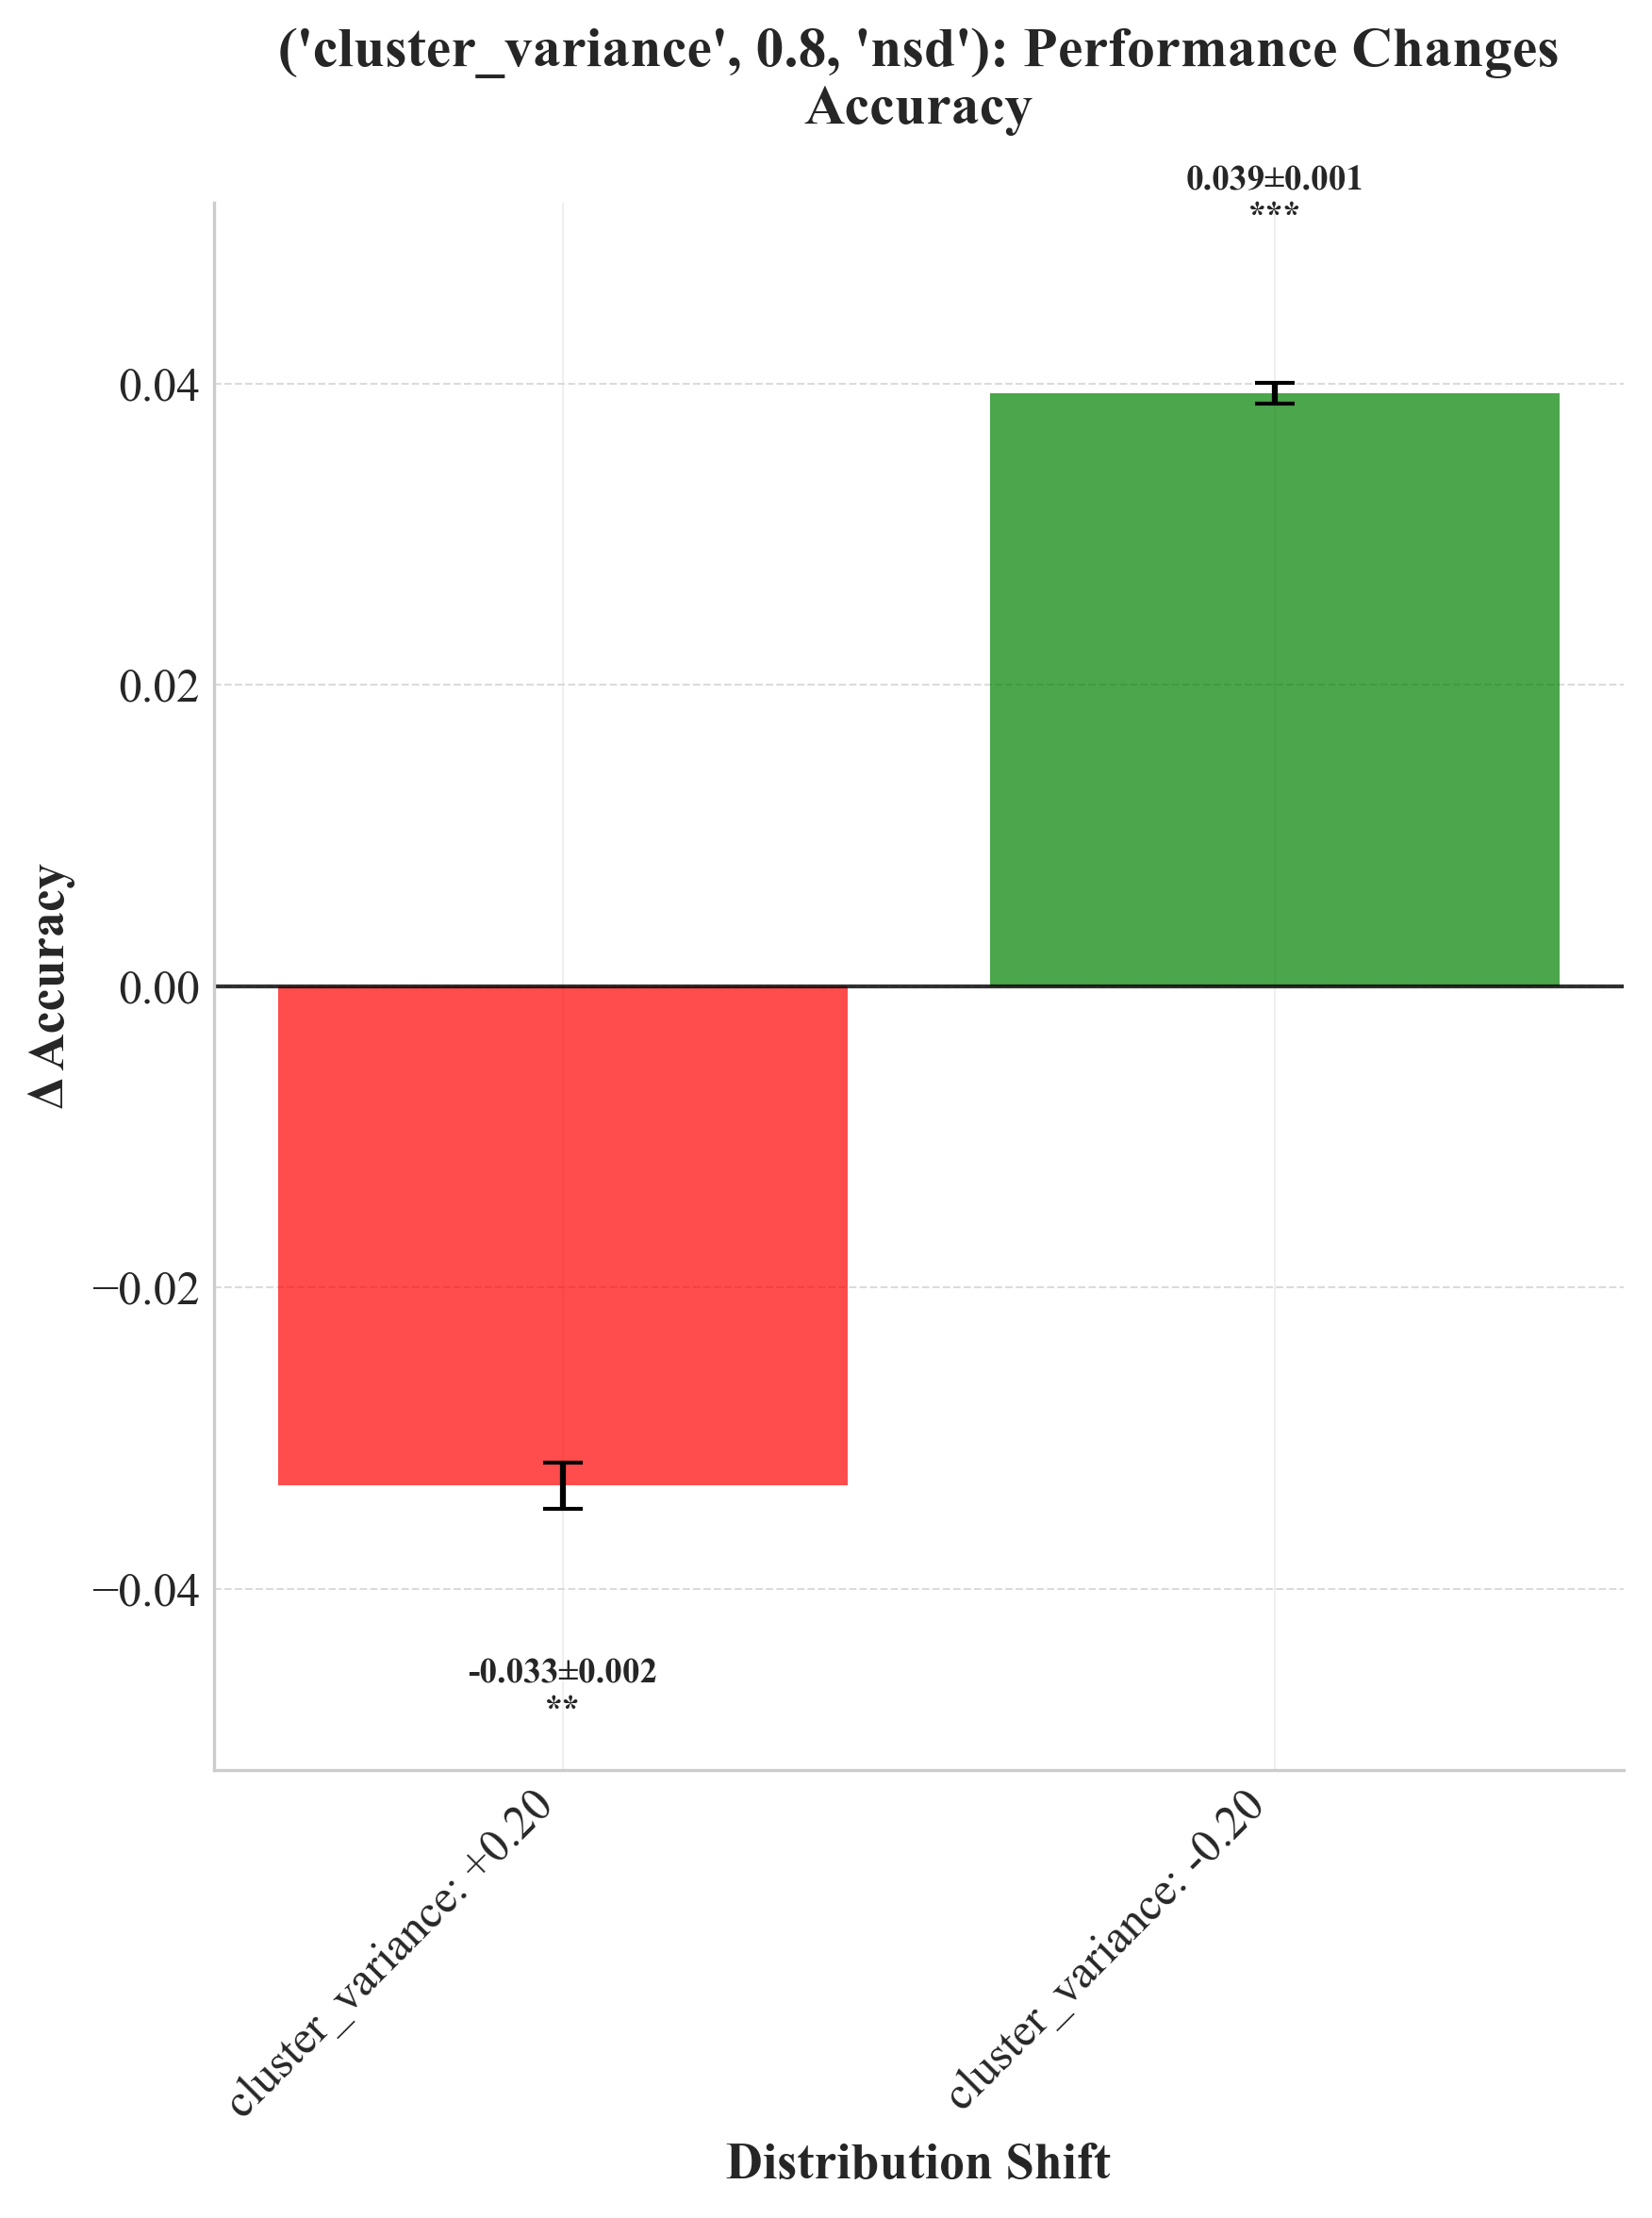

In [2]:
import sys

# Insert the parent folder of this notebook
notebook_path = os.getcwd()
sys.path.append(os.path.dirname(notebook_path))

import os
import copy
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from hydra import compose, initialize
from hydra.utils import instantiate
from hydra.core.global_hydra import GlobalHydra
import lightning as L
from topobench.data.preprocessor import PreProcessor
from topobench.dataloader import TBDataloader

def filter_groups_by_model(df_grouped, include_models=None, exclude_models=None):
    """Filter grouped data to only include groups with desired models."""
    filtered_groups = []
    
    for group, df in df_grouped:
        # Extract model name from group (assuming it's the third element)
        if len(group) >= 3:
            model_name = group[2]
            
            # Apply inclusion filter
            if include_models is not None and model_name not in include_models:
                print(f"Skipping group {group} - model {model_name} not in include list")
                continue
            
            # Apply exclusion filter
            if exclude_models is not None and model_name in exclude_models:
                print(f"Skipping group {group} - model {model_name} in exclude list")
                continue
            
            filtered_groups.append((group, df))
    
    return filtered_groups

class EnhancedModelShiftEvaluator:
    def __init__(self, model_df):
        """Initialize evaluator with model dataframe."""
        self.model_df = model_df
        self._setup_hydra()
        
    def _setup_hydra(self):
        if GlobalHydra().is_initialized():
            GlobalHydra().clear()
        initialize(config_path="../configs", job_name="shift_evaluation")
    
    def shift_dataset_parameters(self, shift_config, number_of_eval_graphs, run_idx, modified_data_config=None):
        """Apply shifts to dataset generation parameters."""
        if modified_data_config is not None:
            # Use the pre-modified config that already has num_nodes_range converted
            dataset_params = modified_data_config['loader']['parameters']['generation_parameters']
        else:
            # Fallback to original method
            dataset_params = self.model_df.loc[run_idx]['config_dataset']['loader']['parameters']['generation_parameters']
        
        params = copy.deepcopy(dataset_params)
        
        # Set the number of graphs to the original number of graphs
        params['family_parameters']['n_graphs'] = number_of_eval_graphs

        # Universe parameters
        for param in ['center_variance', 'cluster_variance', 'edge_propensity_variance']:
            if f'{param}_shift' in shift_config['universe_parameters']:
                params['universe_parameters'][param] += shift_config['universe_parameters'][f'{param}_shift']
                params['universe_parameters'][param] = np.clip(params['universe_parameters'][param], 0, 1)
        
        # Family parameters - integers (including the converted min_n_nodes, max_n_nodes)
        for param in ['min_n_nodes', 'max_n_nodes', 'min_communities', 'max_communities']:
            if f'{param}_shift' in shift_config['family_parameters']:
                params['family_parameters'][param] += shift_config['family_parameters'][f'{param}_shift']
                if param.startswith('n_graphs'):
                    params['family_parameters'][param] = np.clip(params['family_parameters'][param], 1, 100000)
                elif 'nodes' in param:
                    params['family_parameters'][param] = np.clip(params['family_parameters'][param], 1, 10000)
                elif 'communities' in param:
                    params['family_parameters'][param] = np.clip(params['family_parameters'][param], 1, 1000)
        
        # Family parameters - ranges
        range_params = ['homophily_range', 'avg_degree_range', 'degree_separation_range', 'power_law_exponent_range']
        for param in range_params:
            for i, bound in enumerate(['min', 'max']):
                shift_key = f'{bound}_{param}_shift'
                if shift_key in shift_config['family_parameters']:
                    params['family_parameters'][param][i] += shift_config['family_parameters'][shift_key]
                    
                    # Apply appropriate clipping
                    if 'homophily' in param:
                        params['family_parameters'][param][i] = np.clip(params['family_parameters'][param][i], 0, 1)
                    elif 'avg_degree' in param:
                        params['family_parameters'][param][i] = np.clip(params['family_parameters'][param][i], 1, 100)
                    elif 'degree_separation' in param:
                        params['family_parameters'][param][i] = np.clip(params['family_parameters'][param][i], 0, 100)
                    elif 'power_law' in param:
                        params['family_parameters'][param][i] = np.clip(params['family_parameters'][param][i], 0, 10)
        
        # Update seed if provided
        if 'seed' in shift_config['family_parameters']:
            params['family_parameters']['seed'] = shift_config['family_parameters']['seed']
        
        return params

    # def shift_dataset_parameters(self, shift_config, number_of_eval_graphs, run_idx):
    #     """Apply shifts to dataset generation parameters."""
    #     dataset_params = self.model_df.loc[run_idx]['config_dataset']['loader']['parameters']['generation_parameters']
    #     params = copy.deepcopy(dataset_params)
        
    #     # Set the number of graphs to the original number of graphs
    #     params['family_parameters']['n_graphs'] = number_of_eval_graphs

    #     # Universe parameters
    #     for param in ['center_variance', 'cluster_variance', 'edge_propensity_variance']:
    #         if f'{param}_shift' in shift_config['universe_parameters']:
    #             params['universe_parameters'][param] += shift_config['universe_parameters'][f'{param}_shift']
    #             params['universe_parameters'][param] = np.clip(params['universe_parameters'][param], 0, 1)
        
    #     # Family parameters - integers
    #     for param in ['min_n_nodes', 'max_n_nodes', 'min_communities', 'max_communities']:
    #         if f'{param}_shift' in shift_config['family_parameters']:
    #             params['family_parameters'][param] += shift_config['family_parameters'][f'{param}_shift']
    #             if param.startswith('n_graphs'):
    #                 params['family_parameters'][param] = np.clip(params['family_parameters'][param], 1, 100000)
    #             elif 'nodes' in param:
    #                 params['family_parameters'][param] = np.clip(params['family_parameters'][param], 1, 10000)
    #             elif 'communities' in param:
    #                 params['family_parameters'][param] = np.clip(params['family_parameters'][param], 1, 1000)
        
    #     # Family parameters - ranges
    #     range_params = ['homophily_range', 'avg_degree_range', 'degree_separation_range', 'power_law_exponent_range']
    #     for param in range_params:
    #         for i, bound in enumerate(['min', 'max']):
    #             shift_key = f'{bound}_{param}_shift'
    #             if shift_key in shift_config['family_parameters']:
    #                 params['family_parameters'][param][i] += shift_config['family_parameters'][shift_key]
                    
    #                 # Apply appropriate clipping
    #                 if 'homophily' in param:
    #                     params['family_parameters'][param][i] = np.clip(params['family_parameters'][param][i], 0, 1)
    #                 elif 'avg_degree' in param:
    #                     params['family_parameters'][param][i] = np.clip(params['family_parameters'][param][i], 1, 100)
    #                 elif 'degree_separation' in param:
    #                     params['family_parameters'][param][i] = np.clip(params['family_parameters'][param][i], 0, 100)
    #                 elif 'power_law' in param:
    #                     params['family_parameters'][param][i] = np.clip(params['family_parameters'][param][i], 0, 10)
        
    #     # Update seed if provided
    #     if 'seed' in shift_config['family_parameters']:
    #         params['family_parameters']['seed'] = shift_config['family_parameters']['seed']
        
    #     return params
    
    def config_to_overrides(self, config, prefix="", include_graphuniverse_parameters=False):
        """Convert config to overrides using recursion with proper dot notation."""
        overrides = []
        
        for key, value in config.items():
            current_path = f"{prefix}.{key}" if prefix else key
            
            if key == 'generation_parameters' and not include_graphuniverse_parameters:
                continue
                
            if isinstance(value, dict):
                overrides.extend(self.config_to_overrides(
                    value, 
                    prefix=current_path, 
                    include_graphuniverse_parameters=include_graphuniverse_parameters
                ))
            elif isinstance(value, list):
                overrides.append(f"{current_path}={value}")
            else:
                if value is None:
                    overrides.append(f"{current_path}=null")
                else:
                    overrides.append(f"{current_path}={value}")
        
        return overrides

    def prepare_all_overrides(self, shift_config, run_idx):
        """Prepare Hydra config with shifts applied."""
        data_config = self.model_df.loc[run_idx]['config_dataset']
        model_config = self.model_df.loc[run_idx]['config_model']
        transform_config = self.model_df.loc[run_idx]['config_transforms']

        # Calc the original n_graphs for test set 
        train_prop = data_config['split_params']['train_prop']
        eval_prop = (1 - train_prop)
        n_graphs = data_config['loader']['parameters']['generation_parameters']['family_parameters']['n_graphs']
        n_graphs_eval = int(n_graphs * eval_prop)

        # Make a deep copy of data_config to avoid modifying the original
        data_config = copy.deepcopy(data_config)
        
        # SPECIAL HANDLING: Convert num_nodes_range to individual min/max parameters
        gen_params = data_config['loader']['parameters']['generation_parameters']['family_parameters']
        if 'num_nodes_range' in gen_params:
            num_nodes_range = gen_params['num_nodes_range']
            if isinstance(num_nodes_range, (list, tuple)) and len(num_nodes_range) == 2:
                # Convert range to individual parameters
                gen_params['min_n_nodes'] = num_nodes_range[0]
                gen_params['max_n_nodes'] = num_nodes_range[1]
                # Remove the original range parameter
                del gen_params['num_nodes_range']
                print(f"Converted num_nodes_range {num_nodes_range} to min_n_nodes={num_nodes_range[0]}, max_n_nodes={num_nodes_range[1]}")

        shifted_params = self.shift_dataset_parameters(shift_config, n_graphs_eval, run_idx, modified_data_config=data_config)
        
        all_overrides = []
        model_name = model_config['model_name']

        model_config_map = {
            'gcn': 'graph/gcn',
            'gat': 'graph/gat', 
            'GPS': 'graph/gps',
            'nsd': 'graph/nsd',
            'gin': 'graph/gin',
            'DeepSet': 'pointcloud/deepset',
            'topotune': 'cell/topotune',
            'GraphMLP': 'graph/graph_mlp',
            'GraphSAGE': 'graph/sage',
        }
        
        all_overrides.append(f"model={model_config_map[model_name]}")
        all_overrides.append(f"model.model_name={model_name}")
        
        model_overrides = self.config_to_overrides(model_config, prefix="model")
        all_overrides.extend(model_overrides)

        data_overrides = self.config_to_overrides(data_config, prefix="dataset", include_graphuniverse_parameters=False)
        # Find the index of the train_prop override
        train_prop_idx = [i for i, override in enumerate(data_overrides) if 'train_prop' in override]
        # Replace the train_prop with the new train_prop
        data_overrides[train_prop_idx[0]] = f"dataset.split_params.train_prop=0.0"
        print(data_overrides)
        print(data_overrides[train_prop_idx[0]])

        # Now add the data_overrides
        all_overrides.extend(data_overrides)

        if model_name in ['GPS', 'nsd']:
            if transform_config == 'nan':
                transform_overrides = ['transforms.CombinedPSEs.encodings=[]']
            else:
                transform_overrides = self.config_to_overrides(transform_config, prefix="transforms")
            all_overrides.extend(transform_overrides)
            
        shifted_params_overrides = []
        for param_group in ['universe_parameters', 'family_parameters']:
            for key, value in shifted_params[param_group].items():
                shifted_params_overrides.append(
                    f"dataset.loader.parameters.generation_parameters.{param_group}.{key}={value}"
                )
        all_overrides.extend(shifted_params_overrides)

        return all_overrides

    # def prepare_all_overrides(self, shift_config, run_idx):
    #     """Prepare Hydra config with shifts applied."""
    #     data_config = self.model_df.loc[run_idx]['config_dataset']
    #     model_config = self.model_df.loc[run_idx]['config_model']
    #     transform_config = self.model_df.loc[run_idx]['config_transforms']

    #     # Calc the original n_graphs for test set 
    #     train_prop = data_config['split_params']['train_prop']
    #     eval_prop = (1 - train_prop)
    #     n_graphs = data_config['loader']['parameters']['generation_parameters']['family_parameters']['n_graphs']
    #     n_graphs_eval = int(n_graphs * eval_prop)

    #     shifted_params = self.shift_dataset_parameters(shift_config, n_graphs_eval, run_idx)
        
    #     all_overrides = []
    #     model_name = model_config['model_name']

    #     model_config_map = {
    #         'gcn': 'graph/gcn',
    #         'gat': 'graph/gat', 
    #         'GPS': 'graph/gps',
    #         'nsd': 'graph/nsd',
    #         'gin': 'graph/gin',
    #         'DeepSet': 'pointcloud/deepset',
    #         'topotune': 'cell/topotune',
    #         'GraphMLP': 'graph/graph_mlp',
    #         'GraphSAGE': 'graph/sage',
    #     }
        
    #     all_overrides.append(f"model={model_config_map[model_name]}")
    #     all_overrides.append(f"model.model_name={model_name}")
        
    #     model_overrides = self.config_to_overrides(model_config, prefix="model")
    #     all_overrides.extend(model_overrides)

    #     data_overrides = self.config_to_overrides(data_config, prefix="dataset", include_graphuniverse_parameters=False)
    #     # Find the index of the train_prop override
    #     train_prop_idx = [i for i, override in enumerate(data_overrides) if 'train_prop' in override]
    #     # Replace the train_prop with the new train_prop
    #     data_overrides[train_prop_idx[0]] = f"dataset.split_params.train_prop=0.0"
    #     print(data_overrides)
    #     print(data_overrides[train_prop_idx[0]])

    #     # Now add the data_overrides
    #     all_overrides.extend(data_overrides)

    #     if model_name in ['GPS', 'nsd']:
    #         if transform_config == 'nan':
    #             transform_overrides = ['transforms.CombinedPSEs.encodings=[]']
    #         else:
    #             transform_overrides = self.config_to_overrides(transform_config, prefix="transforms")
    #         all_overrides.extend(transform_overrides)
            
    #     shifted_params_overrides = []
    #     for param_group in ['universe_parameters', 'family_parameters']:
    #         for key, value in shifted_params[param_group].items():
    #             shifted_params_overrides.append(
    #                 f"dataset.loader.parameters.generation_parameters.{param_group}.{key}={value}"
    #             )
    #     all_overrides.extend(shifted_params_overrides)

    #     return all_overrides
         
    def evaluate_single_model(self, overrides, run_idx):
        """Evaluate a single model with given overrides."""
        cfg = compose(config_name="run.yaml", overrides=overrides)
        model = instantiate(cfg.model, evaluator=cfg.evaluator, optimizer=cfg.optimizer, loss=cfg.loss)
        
        checkpoint_path = self.model_df.loc[run_idx]['checkpoint_local']
        
        # Add error handling for checkpoint loading
        try:
            if not os.path.exists(checkpoint_path):
                print(f"Checkpoint not found: {checkpoint_path}")
                return None
                
            checkpoint = torch.load(checkpoint_path, map_location="cpu")
            model.load_state_dict(checkpoint["state_dict"], strict=True)
            
        except Exception as e:
            print(f"Error loading checkpoint {checkpoint_path}: {e}")
            return None

        loader = instantiate(cfg.dataset.loader)
        dataset, dataset_dir = loader.load()
        transform_config = cfg.get("transforms", None)
        preprocessor = PreProcessor(dataset, dataset_dir, transform_config)
        _, _, dataset_test = preprocessor.load_dataset_splits(cfg.dataset.split_params)
        
        datamodule = TBDataloader(
            dataset_train=None,
            dataset_val=None, 
            dataset_test=dataset_test,
            **cfg.dataset.get("dataloader_params", {}),
        )
        
        trainer = L.Trainer(
            devices=1,
            accelerator='auto',
            logger=False,
            enable_checkpointing=False,
            num_sanity_val_steps=0,
        )
        
        test_results = trainer.test(model, datamodule)
        return test_results[0] if test_results else {}

    def evaluate_multiple_shifts(self, shift_configs, metrics=['test/accuracy']):
        """Evaluate model performance across multiple distribution shifts."""
        results = []
        
        # Always include a zero shift (baseline)
        zero_shift = {
            'universe_parameters': {},
            'family_parameters': {}
        }

        # Store results by run_idx to maintain pairing
        paired_results = {}
        
        # Combine zero shift with provided shifts
        all_shifts = [zero_shift] + shift_configs
        
        for run_idx in self.model_df.index:
            print(f"Evaluating run {run_idx}")
            paired_results[run_idx] = {}
            for shift_idx, shift_config in enumerate(all_shifts):
                shift_name = self.get_shift_title(shift_config)
                if shift_name == "No Shift":
                    shift_name = "Baseline"
                    
                print(f"Evaluating shift: {shift_name}")
                # Evaluate all models in the DataFrame
                try:
                    # Prepare overrides for this shift
                    overrides = self.prepare_all_overrides(shift_config, run_idx)

                    # Evaluate the model
                    result = self.evaluate_single_model(overrides, run_idx)
                    
                    # Check if result is None (checkpoint not found or error)
                    if result is None:
                        print(f"Skipping run {run_idx} with shift {shift_name} - checkpoint issue")
                        continue
                        
                    paired_results[run_idx][shift_name] = result
                    
                except Exception as e:
                    print(f"Error evaluating model {run_idx} with shift {shift_name}: {e}")
                    continue
            
            # If no shifts were successful for this run, remove it
            if not paired_results[run_idx]:
                print(f"No successful evaluations for run {run_idx}, removing from results")
                del paired_results[run_idx]
        
        # Now calculate paired differences
        results = []
        for metric in metrics:
            # Extract baseline values for this metric
            baseline_values = []
            run_indices = []
            
            for run_idx, shifts in paired_results.items():
                if ('Baseline' in shifts and 
                    shifts['Baseline'] is not None and 
                    metric in shifts['Baseline']):
                    baseline_values.append(shifts['Baseline'][metric])
                    run_indices.append(run_idx)
            
            # Check if we have any baseline values
            if not baseline_values:
                print(f"No baseline values found for metric {metric}")
                continue
            
            # For each shift, calculate paired differences
            for shift_name in [s for s in paired_results[list(paired_results.keys())[0]].keys() if s != 'Baseline']:
                shift_values = []
                valid_pairs = []
                
                for i, run_idx in enumerate(run_indices):
                    if (run_idx in paired_results and 
                        shift_name in paired_results[run_idx] and 
                        paired_results[run_idx][shift_name] is not None and
                        metric in paired_results[run_idx][shift_name]):
                        shift_values.append(paired_results[run_idx][shift_name][metric])
                        valid_pairs.append(i)
                
                if len(valid_pairs) > 0:
                    baseline_paired = [baseline_values[i] for i in valid_pairs]
                    differences = np.array(shift_values) - np.array(baseline_paired)
                    
                    mean_diff = np.mean(differences)
                    se_diff = np.std(differences) / np.sqrt(len(differences))
                    
                    from scipy import stats
                    t_val = stats.t.ppf(0.975, len(differences)-1)
                    ci_95 = t_val * se_diff
                    
                    results.append({
                        'shift_name': shift_name,
                        'metric': metric,
                        'mean_difference': mean_diff,
                        'se_difference': se_diff,
                        'ci_lower': mean_diff - ci_95,
                        'ci_upper': mean_diff + ci_95,
                        'p_value': stats.ttest_1samp(differences, 0).pvalue,
                        'n_pairs': len(differences),
                        'baseline_mean': np.mean(baseline_paired),
                        'shift_mean': np.mean(shift_values)
                    })
                else:
                    print(f"No valid pairs found for shift {shift_name} and metric {metric}")
        
        return pd.DataFrame(results)

    def get_shift_title(self, shift_config):
        """Generate title from non-zero shift parameters."""
        shift_parts = []
        
        for group_name, group_config in shift_config.items():
            if group_name == 'universe_parameters':
                for param, value in group_config.items():
                    if param.endswith('_shift') and value != 0:
                        param_name = param.replace('_shift', '')
                        shift_parts.append(f"{param_name}: {value:+.2f}")
            elif group_name == 'family_parameters':
                for param, value in group_config.items():
                    if param.endswith('_shift') and value != 0:
                        param_name = param.replace('_shift', '').replace('_range', '')
                        shift_parts.append(f"{param_name}: {value:+.2f}")
        
        if shift_parts == []:
            return "No Shift"
        
        return " | ".join(shift_parts) if shift_parts else "No Shift"
    
    def plot_shift_comparison(self, results_df, metrics=['test/accuracy'], save_plots=True, group_name=None):
        """Create publication-quality comparison plot for paired differences."""
        
        # Filter metrics to only those present in the data
        available_metrics = results_df['metric'].unique()
        metrics = [m for m in metrics if m in available_metrics]
        
        if not metrics:
            print("No matching metrics found in results_df")
            return None
        
        # Set publication-quality style
        plt.rcParams.update({
            'font.family': 'serif',
            'font.size': 12,
            'axes.labelsize': 13,
        })
        
        # Create subplots for each metric
        fig, axes = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 8), dpi=300)
        if len(metrics) == 1:
            axes = [axes]
        
        for i, metric in enumerate(metrics):
            ax = axes[i]
            metric_data = results_df[results_df['metric'] == metric]
            
            if len(metric_data) == 0:
                continue
            
            # Create bar plot showing differences from baseline
            x_pos = np.arange(len(metric_data))
            
            # Color bars based on positive/negative differences
            colors = ['green' if diff > 0 else 'red' for diff in metric_data['mean_difference']]
            
            bars = ax.bar(x_pos, metric_data['mean_difference'], 
                        yerr=metric_data['se_difference'],
                        color=colors,
                        alpha=0.7,
                        capsize=5)
            
            # Add horizontal line at y=0 (no difference)
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
            
            # Customize appearance
            ax.set_xlabel('Distribution Shift', fontweight='bold')
            ax.set_ylabel(f'Δ {metric.replace("test/", "").title()}', fontweight='bold')
            ax.set_title(f'{group_name}: Performance Changes\n{metric.replace("test/", "").title()}', 
                        fontweight='bold', pad=20)
            
            # Set x-axis labels
            ax.set_xticks(x_pos)
            ax.set_xticklabels(metric_data['shift_name'], rotation=45, ha='right')
            
            # Add value labels with significance
            for j, (bar, row) in enumerate(zip(bars, metric_data.itertuples())):
                height = bar.get_height()
                y_pos = height + row.se_difference + 0.01 if height >= 0 else height - row.se_difference - 0.01
                
                # Add significance stars
                significance = ""
                if row.p_value < 0.001:
                    significance = "***"
                elif row.p_value < 0.01:
                    significance = "**"
                elif row.p_value < 0.05:
                    significance = "*"
                
                label = f'{row.mean_difference:.3f}±{row.se_difference:.3f}\n{significance}'
                
                ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                    label,
                    ha='center', va='bottom' if height >= 0 else 'top', 
                    fontweight='bold', fontsize=9)
            
            # Styling
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Set y-limits
            if len(metric_data) > 0:
                abs_values = abs(metric_data['mean_difference'] + metric_data['se_difference'])
                if len(abs_values) > 0 and max(abs_values) > 0:
                    y_max = max(abs_values) * 1.3
                    ax.set_ylim([-y_max, y_max])
        
        plt.tight_layout()
        
        if save_plots:
            model_name = self.model_df.iloc[0]['config_model']['model_name']
            filename = f"{str(group_name).replace('(', '').replace(')', '').replace(', ', '_')}_shift_differences_{model_name.lower()}"
            plt.savefig(f"{filename}.png", bbox_inches='tight', dpi=300)
        
        return fig

    # Also add a method to visualize baseline + shifted performance together
    def plot_baseline_vs_shifted(self, results_df, metrics=['test/accuracy'], save_plots=True, group_name=None):
        """Plot baseline performance alongside shifted performance."""
        
        fig, axes = plt.subplots(1, len(metrics), figsize=(8*len(metrics), 6), dpi=300)
        if len(metrics) == 1:
            axes = [axes]
        
        for i, metric in enumerate(metrics):
            ax = axes[i]
            metric_data = results_df[results_df['metric'] == metric]
            
            x = np.arange(len(metric_data))
            width = 0.35
            
            # Plot baseline and shifted bars side by side
            bars1 = ax.bar(x - width/2, metric_data['baseline_mean'], width, 
                        label='Baseline', alpha=0.8, color='lightblue')
            bars2 = ax.bar(x + width/2, metric_data['shift_mean'], width,
                        label='Shifted', alpha=0.8, color='lightcoral')
            
            ax.set_xlabel('Distribution Shift')
            ax.set_ylabel(metric.replace('test/', '').title())
            ax.set_title(f'Baseline vs Shifted Performance: {metric.replace("test/", "").title()}')
            ax.set_xticks(x)
            ax.set_xticklabels(metric_data['shift_name'], rotation=45, ha='right')
            ax.legend()
            
            # Add connecting lines to show the change
            for j, (baseline, shifted) in enumerate(zip(metric_data['baseline_mean'], metric_data['shift_mean'])):
                ax.plot([j-width/2, j+width/2], [baseline, shifted], 
                    'k--', alpha=0.5, linewidth=1)
        
        plt.tight_layout()
        if save_plots:
            model_name = self.model_df.iloc[0]['config_model']['model_name']
            filename = f"{group_name}_baseline_vs_shifted_{model_name.lower()}"
            plt.savefig(f"{filename}.png", bbox_inches='tight', dpi=300)
        
        return fig


def run_shift_evaluation(shift_configs, model_df, group_name):
    """Run comprehensive shift evaluation."""
    
    # Initialize evaluator
    evaluator = EnhancedModelShiftEvaluator(model_df)
    
    # Evaluate all shifts
    results_df = evaluator.evaluate_multiple_shifts(
        shift_configs, 
        metrics=['test/accuracy']
    )
    
    # Check if we have any results before plotting
    if results_df.empty:
        print(f"No successful evaluations for group {group_name} - skipping plots")
        fig = None
    else:
        # Create comparison plot
        fig = evaluator.plot_shift_comparison(results_df, metrics=['test/accuracy'], group_name=group_name)
        
        # Print summary
        print("\n" + "="*50)
        print(f"SHIFT EVALUATION SUMMARY for {group_name}")
        print("="*50)
        for _, row in results_df.iterrows():
            print(f"{row['shift_name']:30} | {row['metric']:12} | "
                  f"Diff: {row['mean_difference']:.3f} ± {row['se_difference']:.3f} "
                  f"(p={row['p_value']:.3f}, n={row['n_pairs']})")
    
    return evaluator, results_df, fig

# Order the best_models_df by the experiment_type and model_name
best_models_df_copy = best_models_df.copy()
best_models_df_copy = best_models_df_copy.sort_values(by=['experiment_type_check', 'varied_param_value', 'model_name'])

# Define model filtering 
INCLUDE_MODELS = ['DeepSet', 'GPS', 'GraphMLP', 'GraphSAGE', 'gat', 'gcn', 'gin', 'nsd', 'topotune']  # Only include these models. Choose from ['DeepSet', 'GPS', 'GraphMLP', 'GraphSAGE', 'gat', 'gcn', 'gin', 'nsd', 'topotune']

# Define shift configuration
SHIFT_CONFIGS = [
    {'universe_parameters': {
        'cluster_variance_shift': 0.2
    },
    'family_parameters': {}
    },
    {'universe_parameters': {
        'cluster_variance_shift': -0.2
    },
    'family_parameters': {}
    },
    # {'universe_parameters': {},
    # 'family_parameters': {
    #     'min_homophily_range_shift': 0.3,
    #     'max_homophily_range_shift': 0.3
    #     },
    # },
    # {'universe_parameters': {},
    # 'family_parameters': {
    #     'min_homophily_range_shift': -0.3,
    #     'max_homophily_range_shift': -0.3
    #     }
    # },
    # {'universe_parameters': {},
    # 'family_parameters': {
    #     'min_n_nodes_shift': 200,
    #     'max_n_nodes_shift': 200
    #     }
    # },
    # {'universe_parameters': {},
    # 'family_parameters': {
    #     'min_n_nodes_shift': 500,
    #     'max_n_nodes_shift': 500
    #     }
    # },
    # {'universe_parameters': {},
    # 'family_parameters': {
    #     'min_n_nodes_shift': 1000,
    #     'max_n_nodes_shift': 1000
    #     }
    # },
    
    # {'universe_parameters': {},
    # 'family_parameters': {
    #     'min_avg_degree_range_shift': 4.0,
    #     'max_avg_degree_range_shift': 4.0
    #     },
    # },
    # {
    # 'universe_parameters': {},
    # 'family_parameters': {
    #     'min_avg_degree_range_shift': -4.0,
    #     'max_avg_degree_range_shift': -4.0
    #     }
    # }
    ]

# Group and filter before processing
df_grouped = best_models_df_copy.groupby(['experiment_type_check', 'varied_param_value', 'model_name'])
filtered_groups = filter_groups_by_model(
    df_grouped, 
    include_models=INCLUDE_MODELS,
    exclude_models=None
)

print(f"Processing {len(filtered_groups)} groups after filtering (originally {len(df_grouped)} groups)")

all_results_df = pd.DataFrame()
for idx, (group, df) in enumerate(filtered_groups):
    evaluator, results_df, fig = run_shift_evaluation(SHIFT_CONFIGS, df, group)
    # Add the group name to the results_df (check how long results_df is to make group name a column)
    nr_of_rows = len(results_df)
    results_df['group_name'] = [group] * nr_of_rows
    all_results_df = pd.concat([all_results_df, results_df])


In [3]:
def save_shift_results_to_json(all_results_df, filename_prefix="shift_results", metric="accuracy"):
    """
    Convert shift results DataFrame to JSON format, checking for existing combinations.
    Always creates backup and only adds new (shift_name, group_name) combinations.
    
    Args:
        all_results_df: DataFrame with columns ['group_name', 'shift_name', 'metric', 
                       'mean_difference', 'se_difference', 'ci_lower', 'ci_upper', etc.]
        filename_prefix: Prefix for output filename
        metric: Metric name for filename
    
    Returns:
        filename: Path to saved JSON file
    """
    import json
    import numpy as np
    import os
    import shutil
    from datetime import datetime
    
    def safe_float_convert(value):
        """Convert value to float, handling NaN and inf values"""
        if pd.isna(value) or np.isinf(value):
            return None
        return float(value)
    
    def format_param_value(param_value):
        """Format param_value to match JSON format (convert floats to ints where appropriate)"""
        if isinstance(param_value, (list, tuple)):
            return tuple(int(x) if isinstance(x, float) and x == int(x) else x for x in param_value)
        return param_value
    
    def parse_group_name(group_name_tuple):
        """Parse the group_name tuple to extract components"""
        if isinstance(group_name_tuple, tuple) and len(group_name_tuple) >= 3:
            experiment_type = group_name_tuple[0]
            param_value = format_param_value(group_name_tuple[1])
            model = group_name_tuple[2]
            return experiment_type, param_value, model
        return None, None, None
    
    def get_existing_combinations(saved_data):
        """Extract all existing (shift_name, group_name) combinations from saved data"""
        existing_combos = set()
        for exp_type, entries in saved_data.items():
            for key, entry in entries.items():
                # Convert param_value to tuple if it's a list (to make it hashable)
                param_value = entry['param_value']
                if isinstance(param_value, list):
                    param_value = tuple(param_value)
                
                group_name = (entry['experiment_type'], param_value, entry['model'])
                for shift_name in entry['shifts'].keys():
                    existing_combos.add((shift_name, group_name))
        return existing_combos
    
    # Determine filename
    filename = f"{filename_prefix}_{metric}_shifts.json"
    
    # Create backup if original file exists
    if os.path.exists(filename):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_filename = f"{filename}.backup_{timestamp}"
        shutil.copy2(filename, backup_filename)
        print(f"Created backup: {backup_filename}")
        
        # Load existing data
        try:
            with open(filename, 'r') as f:
                saved_data = json.load(f)
            print(f"Loaded existing file: {filename}")
            for exp_type, entries in saved_data.items():
                print(f"  Existing {exp_type}: {len(entries)} entries")
        except Exception as e:
            print(f"Error loading existing file ({e}). Starting fresh.")
            saved_data = {}
    else:
        print(f"No existing file found. Creating new file: {filename}")
        saved_data = {}
    
    # Get existing combinations
    existing_combinations = get_existing_combinations(saved_data)
    print(f"Found {len(existing_combinations)} existing (shift_name, group_name) combinations")
    
    # Process new results and check for duplicates
    new_combinations = set()
    skipped_combinations = set()
    added_combinations = set()
    
    print("\nProcessing new data:")
    for _, row in all_results_df.iterrows():
        experiment_type, param_value, model = parse_group_name(row['group_name'])
        shift_name = row['shift_name']
        
        if experiment_type and param_value and model:
            # Create the combination key
            group_name = (experiment_type, param_value, model)
            combination = (shift_name, group_name)
            
            # Check if this combination already exists
            if combination in existing_combinations:
                skipped_combinations.add(combination)
                print(f"  SKIPPED (exists): {shift_name} for {group_name}")
                continue
            
            # This is a new combination - add it
            new_combinations.add(combination)
            added_combinations.add(combination)
            
            # Initialize experiment type if not exists
            if experiment_type not in saved_data:
                saved_data[experiment_type] = {}
            
            # Create consistent key format: (experiment_type, param_value, model)
            key = f"({experiment_type}, {param_value}, {model})"
            
            # Initialize entry if not exists
            if key not in saved_data[experiment_type]:
                saved_data[experiment_type][key] = {
                    'experiment_type': experiment_type,
                    'param_value': param_value,
                    'model': model,
                    'shifts': {}
                }
            
            # Add this shift to the entry with safe float conversion
            saved_data[experiment_type][key]['shifts'][shift_name] = {
                'mean_difference': safe_float_convert(row['mean_difference']),
                'se_difference': safe_float_convert(row['se_difference']),
                'ci_lower': safe_float_convert(row['ci_lower']),
                'ci_upper': safe_float_convert(row['ci_upper']),
                'p_value': safe_float_convert(row['p_value']),
                'n_pairs': int(row['n_pairs']) if pd.notna(row['n_pairs']) else None,
                'baseline_mean': safe_float_convert(row['baseline_mean']),
                'shift_mean': safe_float_convert(row['shift_mean'])
            }
            
            print(f"  ADDED: {shift_name} for {group_name}")
    
    # Save to JSON
    with open(filename, 'w') as f:
        json.dump(saved_data, f, indent=2, default=str)
    
    # Print summary
    print(f"\n{'='*60}")
    print("SUMMARY:")
    print(f"{'='*60}")
    print(f"Input DataFrame: {len(all_results_df)} rows")
    print(f"New combinations added: {len(added_combinations)}")
    print(f"Combinations skipped (already exist): {len(skipped_combinations)}")
    print(f"Results saved to: {filename}")
    
    # if backup_filename in locals():
    #     print(f"Backup created: {backup_filename}")
    
    print(f"\nFinal structure: {len(saved_data)} experiment types")
    for exp_type, entries in saved_data.items():
        total_shifts = sum(len(entry['shifts']) for entry in entries.values())
        print(f"  {exp_type}: {len(entries)} model-parameter combinations, {total_shifts} total shifts")
        
        # Show example of shifts available
        if entries:
            first_key = list(entries.keys())[0]
            shifts = list(entries[first_key]['shifts'].keys())
            if len(shifts) <= 5:
                print(f"    Example shifts: {shifts}")
            else:
                print(f"    Example shifts: {shifts[:3]} ... and {len(shifts)-3} more")
    
    # Print details of what was added/skipped if not too many
    if len(added_combinations) <= 10:
        if added_combinations:
            print(f"\nAdded combinations:")
            for shift_name, (exp_type, param_val, model) in added_combinations:
                print(f"  + {shift_name} for ({exp_type}, {param_val}, {model})")
    else:
        print(f"\n{len(added_combinations)} combinations added (too many to list)")
    
    if len(skipped_combinations) <= 10:
        if skipped_combinations:
            print(f"\nSkipped combinations:")
            for shift_name, (exp_type, param_val, model) in skipped_combinations:
                print(f"  - {shift_name} for ({exp_type}, {param_val}, {model})")
    else:
        print(f"\n{len(skipped_combinations)} combinations skipped (too many to list)")
    
    return filename

# Usage remains the same:
# save_shift_results_to_json(all_results_df, "distribution_shifts", "accuracy")

save_shift_results_to_json(all_results_df, "distribution_shifts", "accuracy")

Created backup: distribution_shifts_accuracy_shifts.json.backup_20250924_210349


Loaded existing file: distribution_shifts_accuracy_shifts.json
  Existing avg_degree_range: 26 entries
  Existing homophily_range: 27 entries
  Existing num_nodes_range: 9 entries
  Existing cluster_variance: 17 entries
Found 164 existing (shift_name, group_name) combinations

Processing new data:
  SKIPPED (exists): cluster_variance: +0.20 for ('cluster_variance', 0.2, 'DeepSet')
  SKIPPED (exists): cluster_variance: -0.20 for ('cluster_variance', 0.2, 'DeepSet')
  SKIPPED (exists): cluster_variance: +0.20 for ('cluster_variance', 0.2, 'GPS')
  SKIPPED (exists): cluster_variance: -0.20 for ('cluster_variance', 0.2, 'GPS')
  SKIPPED (exists): cluster_variance: +0.20 for ('cluster_variance', 0.2, 'GraphMLP')
  SKIPPED (exists): cluster_variance: -0.20 for ('cluster_variance', 0.2, 'GraphMLP')
  SKIPPED (exists): cluster_variance: +0.20 for ('cluster_variance', 0.2, 'GraphSAGE')
  SKIPPED (exists): cluster_variance: -0.20 for ('cluster_variance', 0.2, 'GraphSAGE')
  SKIPPED (exists): clu

'distribution_shifts_accuracy_shifts.json'